# Crypto Forecasting

### __Group E - Datalin__

- Alice Vale R20181074  
- Eva Ferrer R20181110  
- Rafael Sequeira R20181128  
- Raquel Sousa R20181102

#### Library import 

In [1]:
# !pip install talib
# ! pip install TA-Lib


import datetime
import time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import ta as ta
import talib as taa

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor


import warnings
warnings.filterwarnings('ignore')

D:\Rafael\Anaconda_Setup\envs\Personal\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Set notebook preferences

In [2]:
sns.set_style('whitegrid')
color = 'Turquoise'

In [3]:
color1 = '#92dc7e'
color2 = '#39b48e'
color3 = '#64c987'
color4 = '#23aa8f'
color5 = '#b695df'

### Data Preparation

##### Update Data

In [1]:
high = pd.read_csv(r'.\data_updated\high.csv').set_index('Date')
low = pd.read_csv(r'.\data_updated\low.csv').set_index('Date')
close = pd.read_csv(r'.\data_updated\close.csv').set_index('Date')
volume = pd.read_csv(r'.\data_updated\volume.csv').set_index('Date')
open_ = pd.read_csv(r'.\data_updated\open.csv').set_index('Date')
adj_close = pd.read_csv(r'.\data_updated\adj_close.csv').set_index('Date')

for i in [high,low,close,volume,adj_close,open_]:
    print(set(high.index == i.index))

for i in [high,low,close,volume,adj_close,open_]:
    for ii in i.columns:
        new_name = ii.split('-')[0] 
        i.rename(columns= {f'{ii}':new_name},inplace=True)
data = pd.DataFrame(index = high.unstack().index)

for name,i in zip(['open','high','low','close','adj_close','volume'],[open_,high,low,close,adj_close,volume]):
    
    data[f'{name}'] =  i.unstack().values
data.index.names = 'ticker','date'


tickers = data.index.get_level_values(0).unique()

data = data.reset_index()
data['date'] = pd.to_datetime(data['date'])
data = data.set_index(['ticker','date'])


NameError: name 'pd' is not defined

##### Former Dataset

In [173]:
high = pd.read_csv(r'.\data\high.csv').set_index('Date')
low = pd.read_csv(r'.\data\low.csv').set_index('Date')
close = pd.read_csv(r'.\data\close.csv').set_index('Date')
volume = pd.read_csv(r'.\data\volume.csv').set_index('Date')
open_ = pd.read_csv(r'.\data\open.csv').set_index('Date')
adj_close = pd.read_csv(r'.\data\adj_close.csv').set_index('Date')

for i in [high,low,close,volume,adj_close,open_]:
    print(set(high.index == i.index))

for i in [high,low,close,volume,adj_close,open_]:
    for ii in i.columns:
        new_name = ii.split('-')[0] 
        i.rename(columns= {f'{ii}':new_name},inplace=True)
data = pd.DataFrame(index = high.unstack().index)

for name,i in zip(['open','high','low','close','adj_close','volume'],[open_,high,low,close,adj_close,volume]):
    
    data[f'{name}'] =  i.unstack().values
data.index.names = 'ticker','date'


tickers = data.index.get_level_values(0).unique()

data = data.reset_index()
data['date'] = pd.to_datetime(data['date'])
data = data.set_index(['ticker','date'])


{True}
{True}
{True}
{True}
{True}
{True}


In [262]:
start_trading = data.dropna().reset_index().groupby('ticker').agg('first')
tradetime = []
for i,ii in zip(start_trading['date'], start_trading.index):
    print(f'The crypto {ii} started trading at {i}')
    date = pd.to_datetime(i)
    last_day = pd.to_datetime(data.index.get_level_values(1).max())
    td = (last_day - date)
    td = td / np.timedelta64(1, "D")
    tradetime.append(td)
    print(f'We have {td} days of trading for training.')
    print(' ')
start_trading['TrainingDays'] = tradetime

The crypto ADA started trading at 2017-11-09 00:00:00
We have 1641.0 days of trading for training.
 
The crypto ATOM started trading at 2019-03-14 00:00:00
We have 1151.0 days of trading for training.
 
The crypto AVAX started trading at 2020-07-13 00:00:00
We have 664.0 days of trading for training.
 
The crypto AXS started trading at 2020-11-04 00:00:00
We have 550.0 days of trading for training.
 
The crypto BTC started trading at 2017-05-09 00:00:00
We have 1825.0 days of trading for training.
 
The crypto ETH started trading at 2017-11-09 00:00:00
We have 1641.0 days of trading for training.
 
The crypto LINK started trading at 2017-11-09 00:00:00
We have 1641.0 days of trading for training.
 
The crypto LUNA1 started trading at 2019-07-26 00:00:00
We have 1017.0 days of trading for training.
 
The crypto MATIC started trading at 2019-04-28 00:00:00
We have 1106.0 days of trading for training.
 
The crypto SOL started trading at 2020-04-10 00:00:00
We have 758.0 days of trading fo

Text(0.5, 0, 'Crypto currencies')

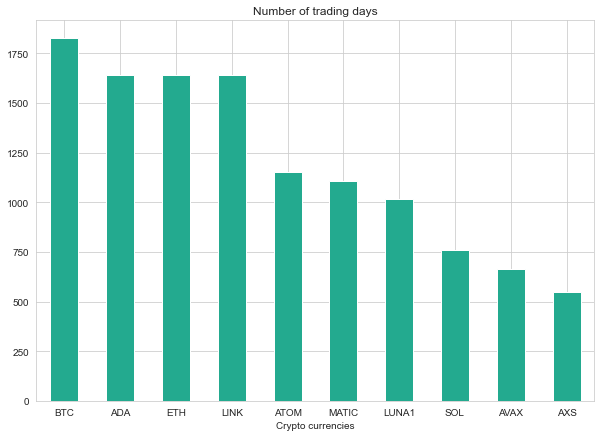

In [263]:
start_trading['TrainingDays'].sort_values(ascending=False).plot.bar(figsize=(10,7),color=color4)
plt.xticks(rotation=0)
plt.title('Number of trading days')
plt.xlabel('Crypto currencies')

#### Missing Values

In [264]:
data.isnull().sum()

open         6325
high         6325
low          6325
close        6325
adj_close    6325
volume       6325
dtype: int64

In [265]:
for i, ii in zip(start_trading['date'],start_trading.index):
    data = data.loc[((data.index.get_level_values(1)>=i)&(data.index.get_level_values(0)==ii))| (((data.index.get_level_values(0)==ii)==False)),:]
    

In [266]:
data.isnull().sum()

open         69
high         69
low          69
close        69
adj_close    69
volume       69
dtype: int64

In [267]:
data = data.loc[((data.index.get_level_values(0)=='AVAX')&(data.index.get_level_values(1)>'2020-09-21')) | ((data.index.get_level_values(0)!='AVAX'))]

In [268]:
data.isnull().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

#### Outliers

Since it's a time series prediction we won't remove any outliers because we don't want to lose any existent market movement.

#### Incoherences 

No incoherences were found (market data should not be eliminated by any means)

#### Statistical Description

In [113]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
open,11816.0,2.944701e+03,9.493588e+03,0.003143,6.336950e-01,1.202741e+01,2.225284e+02,6.754973e+04
high,11816.0,3.024037e+03,9.742067e+03,0.003380,6.788800e-01,1.276865e+01,2.281101e+02,6.878962e+04
low,11816.0,2.857487e+03,9.213025e+03,0.003012,5.895543e-01,1.135326e+01,2.158726e+02,6.638206e+04
close,11816.0,2.947851e+03,9.497849e+03,0.003141,6.385300e-01,1.211127e+01,2.225352e+02,6.756683e+04
adj_close,11816.0,2.947851e+03,9.497849e+03,0.003141,6.385300e-01,1.211127e+01,2.225352e+02,6.756683e+04
volume,11816.0,5.780855e+09,1.246041e+10,170533.000000,7.114144e+07,7.113952e+08,4.087925e+09,3.509679e+11


In [114]:
data.groupby('ticker').describe()['close']

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
ADA,1629.0,0.495561,0.668714,0.023961,0.054981,0.119883,0.917466,2.968239
ATOM,1139.0,12.144663,11.252707,1.649203,3.796566,5.413434,21.215042,44.542789
AVAX,581.0,43.200367,35.198242,2.906161,11.914669,32.016247,74.183746,134.531036
AXS,538.0,43.688947,45.210389,0.135104,3.787297,42.370087,69.652525,160.359268
BTC,1826.0,18046.097008,17663.631711,1281.079956,6496.697388,9308.620117,32812.266602,67566.828125
ETH,1629.0,1068.500044,1254.816565,84.308296,197.317535,393.888306,1806.971802,4812.087402
LINK,1629.0,9.278496,11.096676,0.145255,0.492477,2.787380,16.091297,52.198696
LUNA1,1005.0,17.860333,28.437803,0.125335,0.302750,1.064888,25.152348,116.408920
MATIC,1094.0,0.544522,0.747656,0.003141,0.016613,0.022792,1.270481,2.876757


#### Time Series Plot

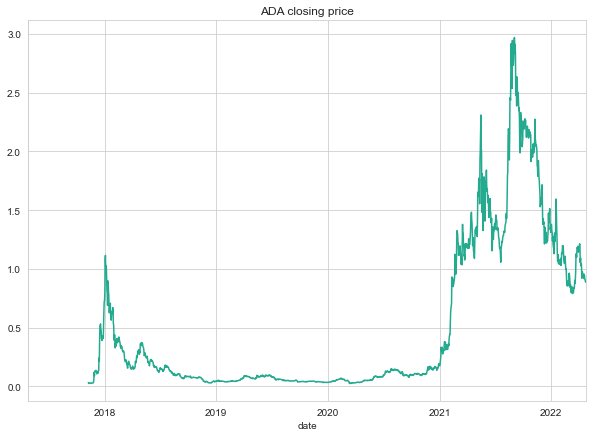

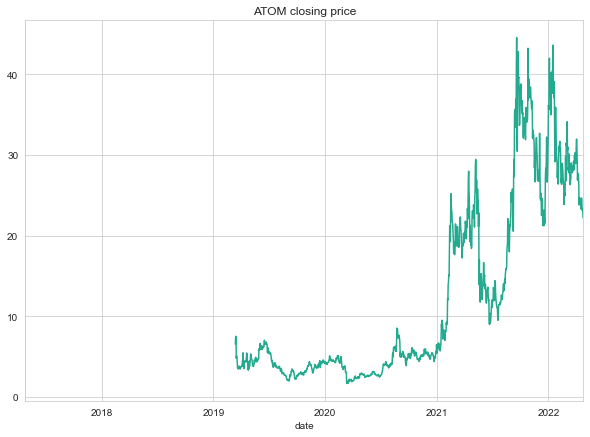

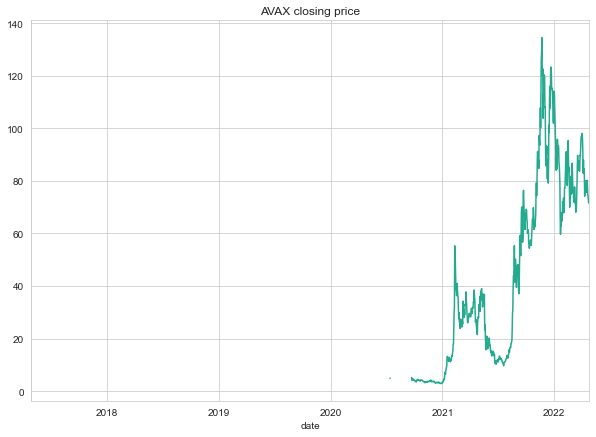

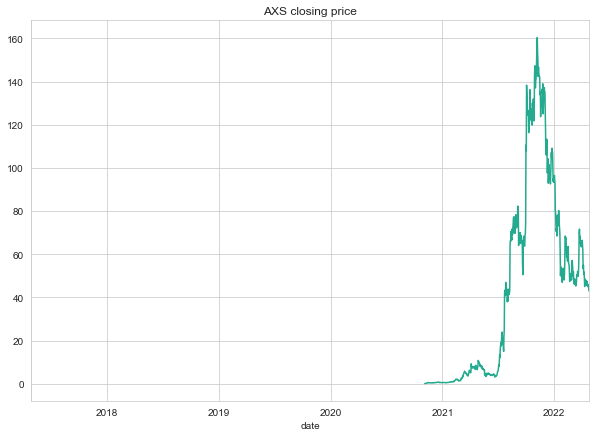

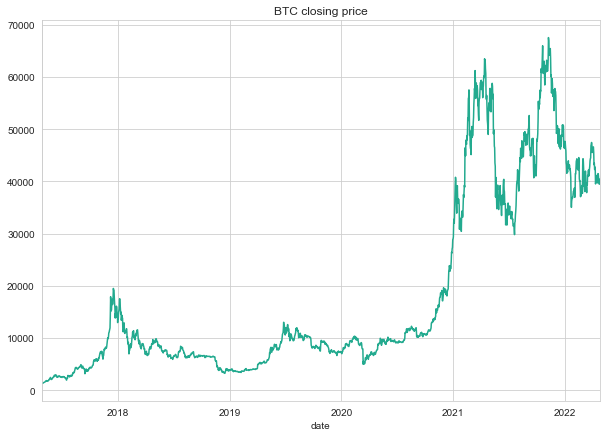

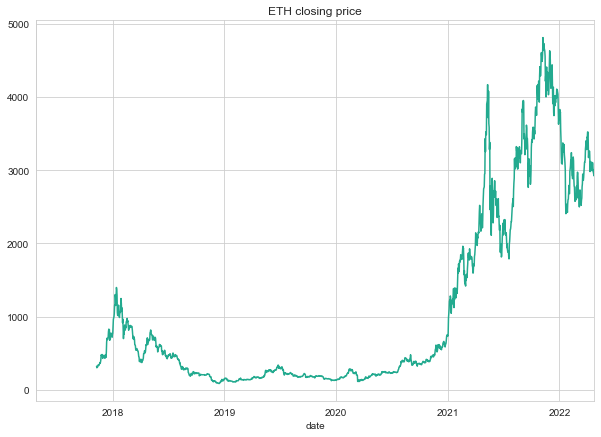

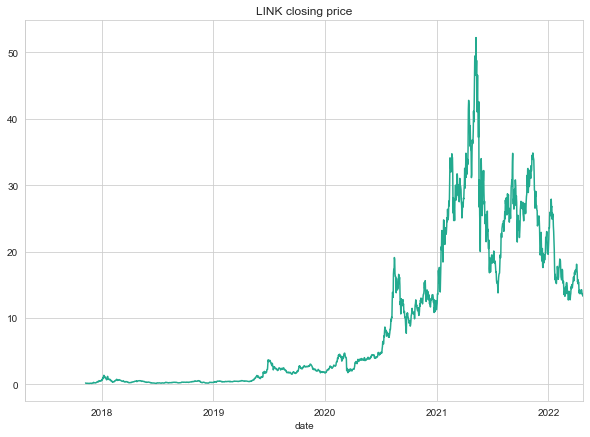

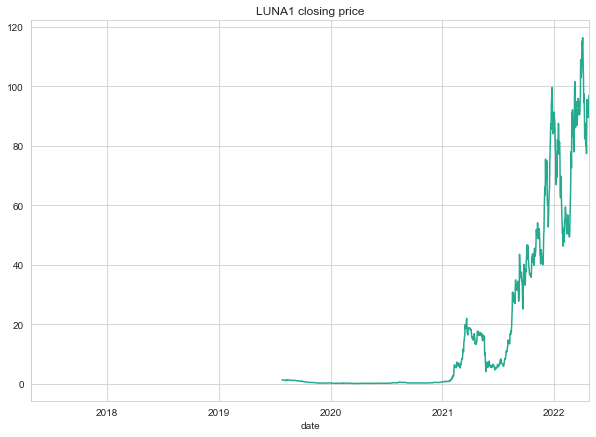

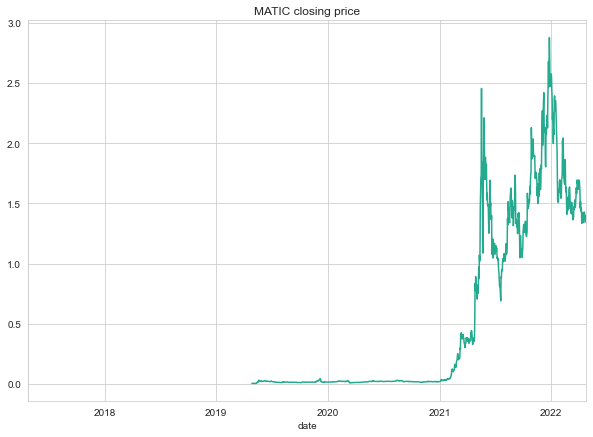

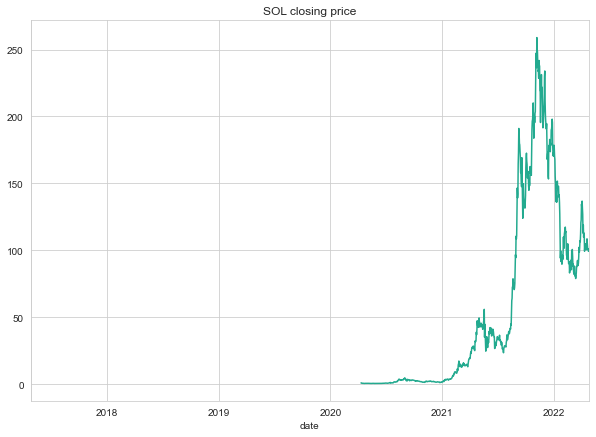

In [15]:
for i in tickers:
    data.loc[data.index.get_level_values(0)==i,'close'].droplevel('ticker').plot(figsize = (10,7),color=color4)
    plt.title(f'{i} closing price')
    plt.xlabel('date')
    plt.show()

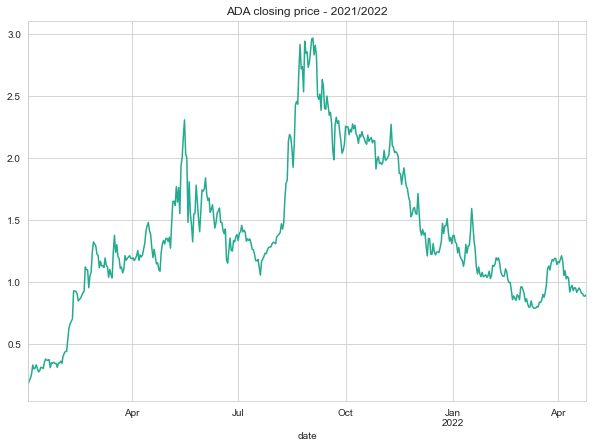

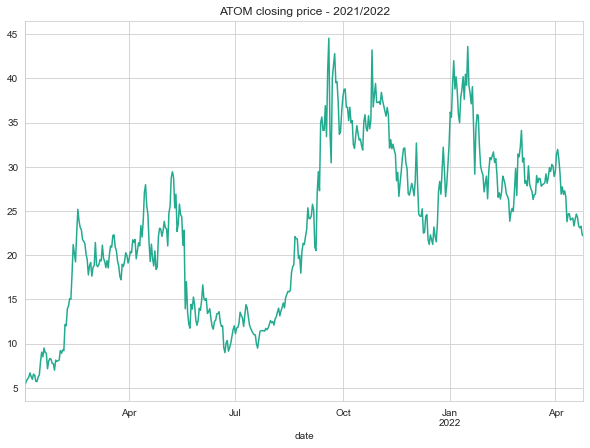

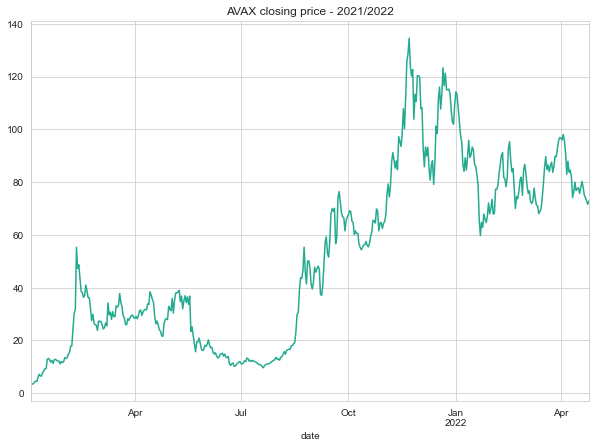

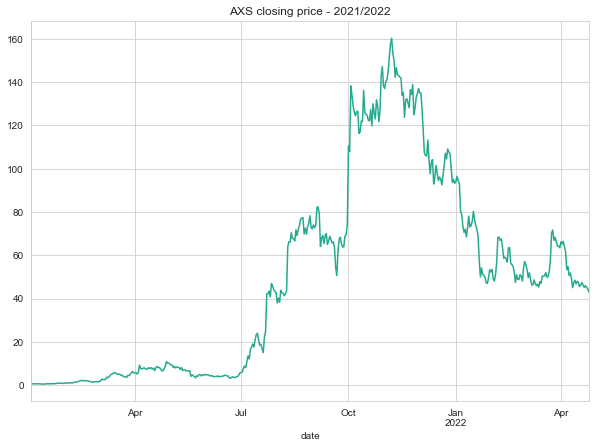

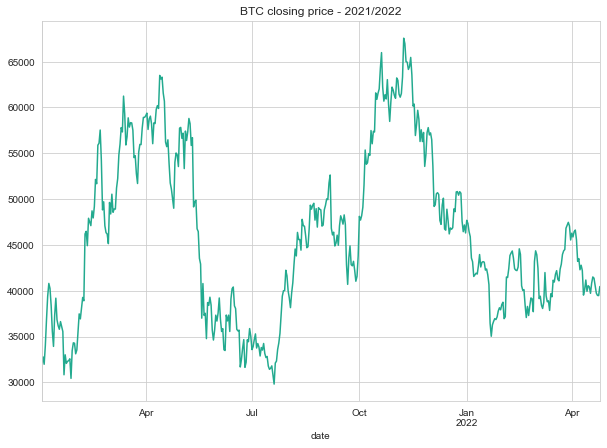

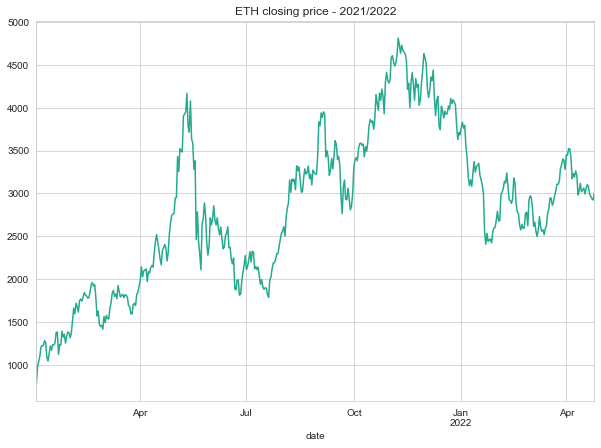

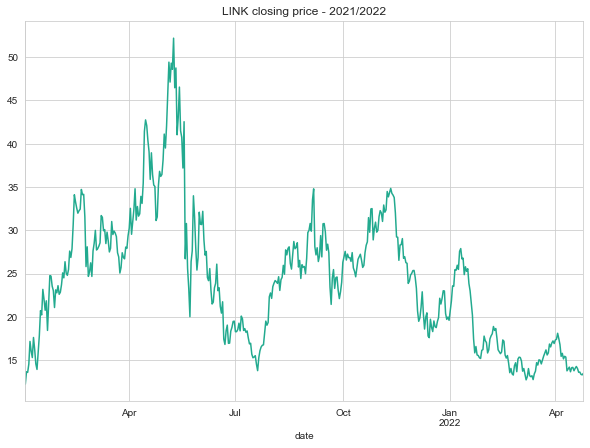

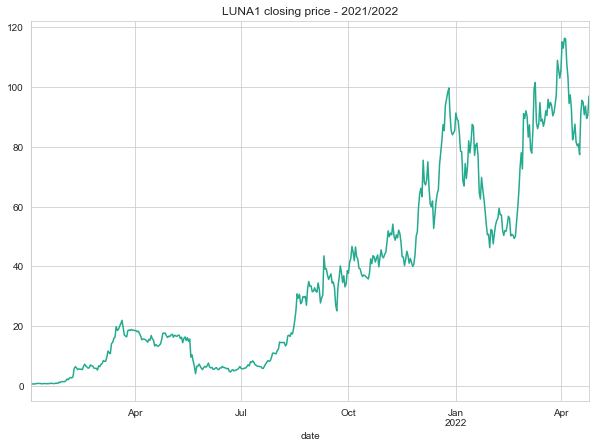

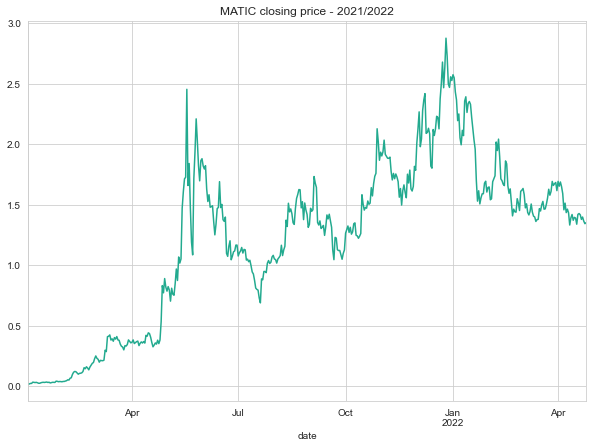

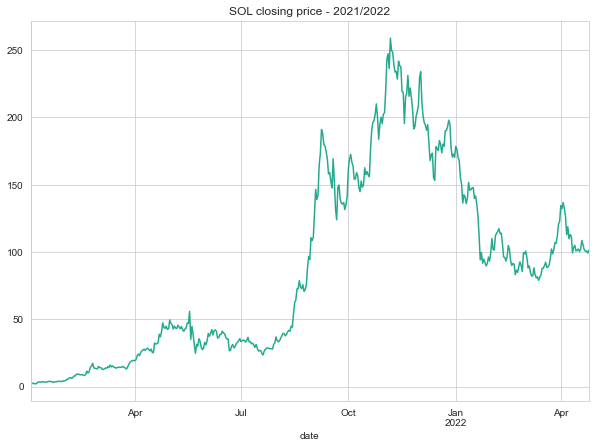

In [18]:
for i in tickers:
    data.loc[(data.index.get_level_values(0)==i) &((data.index.get_level_values(1)>'2021-01-01')),'close'].droplevel('ticker').plot(figsize = (10,7),color=color4)
    plt.title(f'{i} closing price - 2021/2022')
    plt.xlabel('date')
    plt.show()

#### Feature Engineer

In this stage the goal is to build variables that may be relevant to explain our target. To do so, many indicator from different realms of technical analysis were created, (Volatility, Trend, Momentum, Overlap Studies). Besides that, we also wanted to include gold prices to the model, so we downloaded the data from an api with the function get_metric_orices.
- __get_metric_prices -__ downloads daily data (ohlc) from a specified ticker  
-__gen_gold -__ dowloads gold data and performs feature engineer to account for momentum and volatility

##### Feature Engineer Functions

In [271]:
#https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.307.6153&rep=rep1&type=pdf

key = '54594d7278e0fa3c0831a72c60e04b8d'
import requests
def get_metric_prices (name,key):
    i = name
    
    url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{i}?apikey={key}'
    r = requests.get(url)
    data = r.json()
    d = pd.DataFrame.from_dict(data['historical'])
    d['date'] = pd.to_datetime(d['date'])
    d['ticker'] = i
    d.set_index(['ticker','date'],inplace=True)
    d.index.names = 'ticker','date'
    return(d)

def gen_gold ():
    

    oil = get_metric_prices('CLUSD',key).sort_values('date')
    gold = get_metric_prices('GCUSD',key).sort_values('date')
    S_P = get_metric_prices('^GSPC',key).sort_values('date')
    gold_cols = []
    gold_cols.append('GLclose')
    for i in [5,14]:
        gold[f'Gold_STD_{i}'] = taa.STDDEV((gold['close'] - gold['close'].shift(1))/(gold['close'].shift(1)), timeperiod=i)
        gold_cols.append(f'Gold_STD_{i}')
        gold[f'Gold_STD_{i}_adj'] = (gold[f'Gold_STD_{i}'] / gold[f'Gold_STD_{i}'].mean())-1
        gold_cols.append(f'Gold_STD_{i}_adj')

    gold['Gold_AvgP_adj'] = (gold['close'] / taa.AVGPRICE(gold['open'],gold['high'],gold['low'],gold['close']))-1
    gold = gold.rename(columns={'close':'GLclose'})

    gold_cols.append('Gold_AvgP_adj')
    gold = gold[gold_cols]
    return(gold.reset_index().drop(columns = 'ticker'))

def EMA_indicator (lag_window, name, df_orig):
    #exponential moving average
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = ta.trend.EMAIndicator(close_,window).ema_indicator()
            EMA= (indicator)
            df[i]= EMA
        tech_indicators[f'{name}_{window}'] = df.stack()

    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)

def SMA_indicator (lag_window, name, df_orig):
    #Simple Moving Average 
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = taa.SMA(close_, timeperiod=window)
            
            SMA= (indicator)
            df[i]= SMA
        tech_indicators[f'{name}_{window}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)


def RSI_indicator (lag_window, name, df_orig):
    #relative stenght index, measures momentum/trend
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = taa.RSI(close_, timeperiod=window)
            RSI= (indicator)
            df[i]= RSI
        tech_indicators[f'{name}_{window}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)

def ATR_indicator (lag_window, name, df_orig):
    #average true range, measures volatility
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = taa.NATR(high_,low_,close_, timeperiod=window)
            ATR= (indicator)
            df[i]= ATR
        tech_indicators[f'{name}_{window}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)

def Stoch_indicator (name, df_orig):
    tech_indicators = pd.DataFrame()
    df = (close - low) / (high-low)
    tech_indicators[f'{name}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)

def Volume_Trend (name, df_orig):
    #volume was divided by 1 Million to facilitate interpretation
    tech_indicators = pd.DataFrame()
    df = (((close - close.shift(1)) / close.shift(1)) * (volume.values/1000000))  
    tech_indicators[f'{name}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)


def STD_indicator (lag_window, name, df_orig):
    #std of the daily % change
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = taa.STDDEV((close_ - close_.shift(1))/(close_.shift(1)), timeperiod=window)
            std= (indicator)
            df[i]= std
        tech_indicators[f'{name}_{window}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    
    for col in tech_indicators.columns:
        for i,ii in zip(df_engineer.groupby('ticker').mean()[f'{col}'].values,df_engineer.groupby('ticker').mean()[f'{col}'].index):
            df_engineer.loc[df_engineer.index.get_level_values(0)==ii,f'{col}_Adj'] = df_engineer[f'{col}'] / i
    return(df_engineer)

def KAMA_indicator (lag_window, name, df_orig):
    #Kaufman's Adaptive Moving Average (KAMA) is a moving average designed to account for market noise or volatility
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = taa.KAMA(high_, timeperiod=window)
            kama= (indicator)
            df[i]= kama
        tech_indicators[f'{name}_{window}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])

    return(df_engineer)

#momentum
def MOM_indicator (lag_window, name, df_orig):
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = taa.MOM(close_, timeperiod=window)
            
            MOM= (indicator)
            df[i]= MOM
        tech_indicators[f'{name}_{window}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)

def OBV_indicator (df_orig):
    tech_indicators = pd.DataFrame() 
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    for i in close.columns:
        close_ = close[i]
        low_ = low[i]
        high_ = high[i]
        volume_ = volume[i]
        indicator = taa.OBV(close_, volume_)
        OBV= (indicator)
        df[i]= OBV /100000000
    tech_indicators[f'OBV'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)


def ROC_indicator (lag_window, name, df_orig):
    #rate of change = % of change
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            indicator = taa.ROC(high_, timeperiod=window)
            ROC= (indicator)
            df[i]= ROC
        tech_indicators[f'{name}_{window}'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])

    return(df_engineer)

def AROON_indicator (lag_window, name, df_orig):
    #The indicator consists of the "Aroon up" line, which measures the strength of the uptrend, 
    #and the "Aroon down" line, which measures the strength of the downtrend.
    tech_indicators = pd.DataFrame() 
    for window in lag_window:
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        for i in close.columns:
            close_ = close[i]
            low_ = low[i]
            high_ = high[i]
            ar1, ar2 = taa.AROON(high_,low_, timeperiod = window)
            
            df[i]= ar1
            df2[i] = ar2
        tech_indicators[f'{name}_down_{window}'] = df.stack()
        tech_indicators[f'{name}_up_{window}'] = df2.stack()
        
    tech_indicators.index.names = ['date','ticker']
#     tech_indicators = tech_indicators.reset_index()
#     tech_indicators['date'] = pd.to_datetime(tech_indicators['date'])
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)

def avg_price (df_orig):
    #this function compares the current price with the average price 
    tech_indicators = pd.DataFrame() 
    
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    for i in close.columns:
        open__ = open_[i]
        close_ = close[i]
        low_ = low[i]
        high_ = high[i]
        indicator = (close_ / taa.AVGPRICE(open__,high_,low_,close_ )) - 1
        avg= (indicator)
        df[i]= avg
    tech_indicators[f'Avg_Price_Disparity'] = df.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])

    return(df_engineer)

#trend indicator used to predict reversels in the market 
# if its smaller than the price then we are in in a bull market (prices are rising)
# if its larger than the price then we are in in a bear market (prices are dropping)
def SAR_indicator (df_orig):
    tech_indicators = pd.DataFrame() 
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    for i in close.columns:
        close_ = close[i]
        low_ = low[i]
        high_ = high[i]
        volume_ = volume[i]
        indicator = taa.SAR(high_, low_)
        
        SAR= (indicator)
        df[i]= SAR 
        
    SAR_adj = (close - df)
    tech_indicators[f'SAR'] = df.stack()
    tech_indicators[f'SAR_adj'] = SAR_adj.stack() 
    tech_indicators.index.names = ['date','ticker']
    df_engineer = pd.merge(df_orig.reset_index().copy(), tech_indicators.reset_index(), how='left',on=['ticker','date']).set_index(['ticker','date'])
    return(df_engineer)

def ft_engineer (data):
    import time
    
    start = time.time()
    close = data['close'].unstack(level='ticker').copy()
    high =  data['high'].unstack(level='ticker').copy()
    low = data['low'].unstack(level='ticker').copy()
    open_ = data['open'].unstack(level='ticker').copy()
    
    a = EMA_indicator([2,7,20],'EMA',data)
    a = ATR_indicator([2,7,20],'ATR',a)
    a = RSI_indicator([2,7,20],'RSI',a)
    a = MOM_indicator([2,7,20],'MOM',a)
    a = STD_indicator([2,7,20],'STD',a)
    a = Stoch_indicator('Stoch',a)
    a = KAMA_indicator([2,7,20],'KAMA',a)
    a = OBV_indicator(a)
    a = ROC_indicator([2,7,20],'ROC',a)
    a = AROON_indicator([2,7,20],'AROON',a)
    a = avg_price(a)
    a = SMA_indicator([2,7,20],'SMA',a)
    gold = gen_gold()
    df = pd.merge(a.reset_index(),gold,how='left',on='date')
    
    #weekend values are filled with the last previous value (friday)
    for i in df.iloc[:,-6:].columns:
        df[i] = df[i].ffill(axis=0)
        
        
    df = df.set_index(['ticker','date'])
    df['KAMA_Disparity'] = (df['KAMA_7']/df['KAMA_20'])-1
        
    
    end = time.time()
    print(' ')
    print (f'Feature creation lasted:, {end - start} seconds')
    return(df)
    

####  Feature Engineer Pipeline

In [272]:
#calculate returns
stocks_returns = ((data -data.groupby('ticker').shift(1)) /data.groupby('ticker').shift(1))

close = data['close'].unstack(level='ticker').copy()
high =  data['high'].unstack(level='ticker').copy()
low = data['low'].unstack(level='ticker').copy()
open_ = data['open'].unstack(level='ticker').copy()

df_engineer = ft_engineer(data.copy())

 
Feature creation lasted:, 3.4863336086273193 seconds


### EDA

#### Create Ticker Signature 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'LINK'),
  Text(1, 0, 'MATIC'),
  Text(2, 0, 'SOL'),
  Text(3, 0, 'LUNA1'),
  Text(4, 0, 'AVAX'),
  Text(5, 0, 'BTC'),
  Text(6, 0, 'ATOM'),
  Text(7, 0, 'AXS'),
  Text(8, 0, 'ETH'),
  Text(9, 0, 'ADA')])

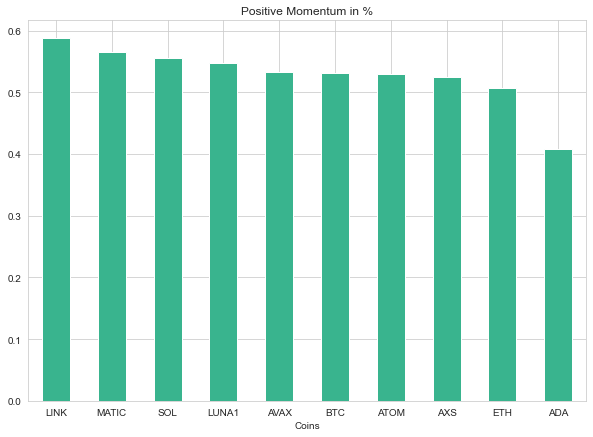

In [219]:
stocks_returns = ((data -data.groupby('ticker').shift(1)) /data.groupby('ticker').shift(1))
index = data.reset_index().groupby('ticker').agg('first').index
ticker_signature = pd.DataFrame()
ticker_signature['start_trading'] = pd.to_datetime(data.reset_index().groupby('ticker').agg('first')['date'])

ticker_signature['avg_returns'] = stocks_returns.groupby('ticker')['close'].mean()

ticker_signature['returns_std'] = stocks_returns.groupby('ticker')['close'].std()

#its the % growth since the 1st day of training
ticker_signature['lifetime_pct'] = (data.groupby('ticker').agg('last')['close']-data.groupby('ticker').agg('first')['close']) / data.groupby('ticker').agg('first')['close']

#the division between a low range MA and a high range MA
#if the low range MA is higher than the high range MA then the price of the coin is in average higher than usual
#then we calculate the mean value of each coin 
ticker_signature['avg_momentum'] = (data.groupby('ticker')['close'].rolling(7).mean() / data.groupby('ticker')['close'].rolling(30).mean()).groupby('ticker').mean() - 1


ma_analysis = pd.DataFrame(index = data.index)
ma_analysis['MA'] = (data.groupby('ticker')['close'].rolling(30).mean() / data.groupby('ticker')['close'].rolling(100).mean()).values

ma_analysis.loc[ma_analysis['MA']>1,'Ma_Signal'] = 1
ma_analysis['Ma_Signal'] = ma_analysis['Ma_Signal'].fillna(value=0)

ma_analysis['Ma_Signal'].groupby('ticker').mean().sort_values(ascending=False).plot.bar(figsize = (10,7),color=color2)
plt.title('Positive Momentum in %')
plt.xlabel('Coins')
plt.xticks(rotation= 0)

Text(0, 0.5, 'Returns Volatility')

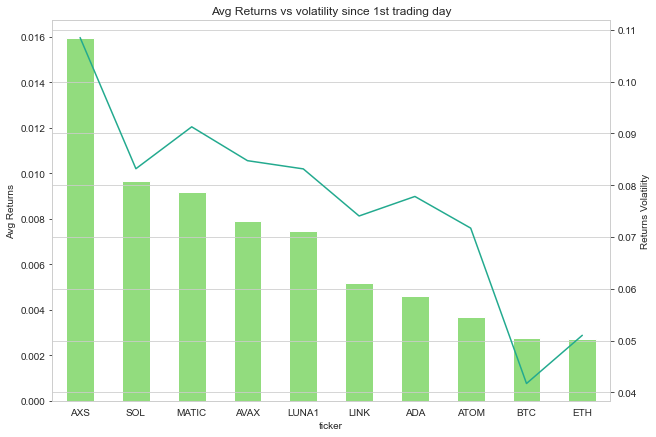

In [79]:
ticker_signature = ticker_signature.sort_values(ascending=False, by ='avg_returns' )
ax1 = ticker_signature['avg_returns'].plot.bar(figsize = (10,7),color =color1)
ax2 = ticker_signature['returns_std'].plot(secondary_y=True,color=color4)
plt.title('Avg Returns vs volatility since 1st trading day')
ax1.set_ylabel('Avg Returns')
ax2.set_ylabel('Returns Volatility')

#### Momentum Analysis

BTC


Text(0.5, 1.0, 'BTC momentum Line and price comparison')

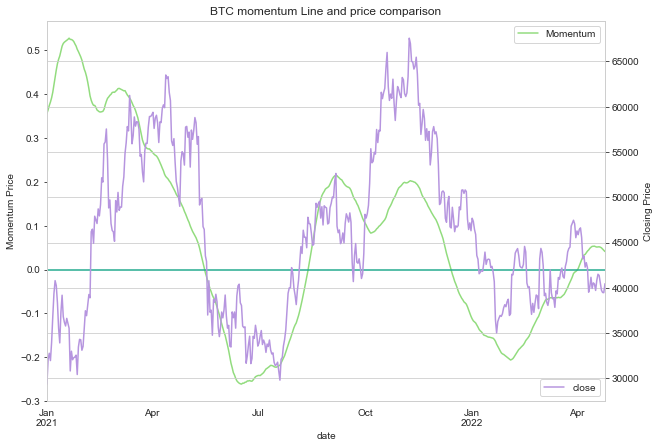

In [223]:
teste = pd.DataFrame(index = data.index)
teste = teste.reset_index()
teste['date'] = pd.to_datetime(teste['date'])
teste = teste.set_index(['ticker','date'])
teste['avg_momentum'] = (data.groupby('ticker')['close'].rolling(30).mean().values / data.groupby('ticker')['close'].rolling(100).mean().values)-1
teste['close'] = data['close'].values
teste['avg_vol'] = (data['close'] /  data.groupby('ticker')['close'].shift(-1)).groupby('ticker').rolling(30).std().values

teste['ma7'] = (data.groupby('ticker')['close'].rolling(7).mean()).values
teste['ma30'] = (data.groupby('ticker')['close'].rolling(30).mean()).values
teste['close'] = data['close'].values

#Momentum Analysis
ticker = 'BTC'
print(f'{ticker}')
years = [2017,2018,2019,2020,2021,2022]



teste = teste.loc[teste.index.get_level_values(1).year >=2021]
ax1 = teste.loc[teste.index.get_level_values(0)==ticker].droplevel('ticker')[['avg_momentum']].plot(figsize = (10,7),color=color1, )
ax1.legend(['Momentum'],loc = 4.5)
ax2 = teste.loc[teste.index.get_level_values(0)==ticker].droplevel('ticker').rename(columns={'close':'Close'})['Close'].plot(secondary_y=True,color= color5,)
ax2.legend(['close'],loc=4)
ax1.axhline(0,color=color4)
ax2.set_ylabel('Closing Price')

ax1.set_ylabel('Momentum Price')

# ax1.legend = ()
# ax2.legend = (['Closing Price'])
plt.title(f'{ticker} momentum Line and price comparison')

Text(0.5, 1.0, 'BTC Volatily Analysis and Price comparison')

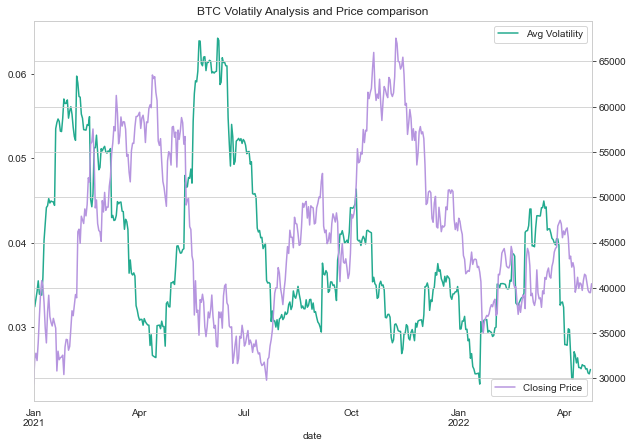

In [228]:
ticker = 'BTC'
teste = teste.loc[teste.index.get_level_values(1).year.isin(years)]
ax1 = teste.loc[teste.index.get_level_values(0)==ticker].droplevel('ticker')[['avg_vol']].plot(color=[color4])
ax1.legend(['Avg Volatility'])
ax2 = teste.loc[teste.index.get_level_values(0)==ticker].droplevel('ticker')['close'].plot(figsize=(10,7), color = color5,secondary_y=True)
ax2.legend(['Closing Price'],loc=4)

#ax1.axhline(0)
plt.title(f'{ticker} Volatily Analysis and Price comparison')

#### MA overlapping Analysis

Text(0.5, 1.0, 'BTC Moving Average overlapping analysis')

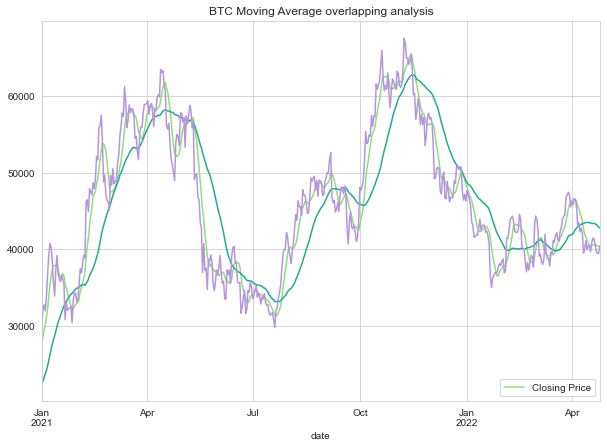

In [238]:
ticker = 'BTC'
teste = teste.loc[teste.index.get_level_values(1).year.isin(years)]
ax1 = teste.loc[teste.index.get_level_values(0)==ticker].droplevel('ticker')[['ma7','ma30']].plot(figsize=(10,7),color=[color1,color4])
ax1.legend(['MA7','MA30'],loc='upper left')
ax2 = teste.loc[teste.index.get_level_values(0)==ticker].droplevel('ticker')['close'].plot( color = color5)
ax2.legend(['Closing Price'],loc=4)

#ax1.axhline(0)
plt.title(f'{ticker} Moving Average overlapping analysis')


#### 2021 and 2022 returns and volatility analysis

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

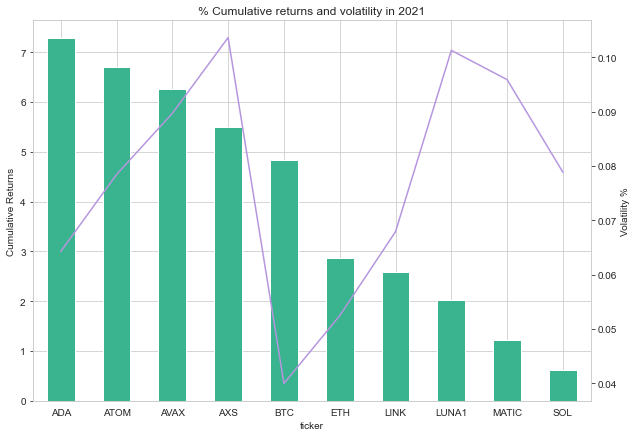

In [22]:
close_2k21 = close.loc[close.index>'2021-01-01']
returns_pct = ((close_2k21 - close_2k21.shift(1)) / close_2k21.shift(1)).dropna()
ax1 = returns_pct.cumsum().iloc[-1].sort_values(ascending=False).plot.bar(figsize = (10,7),color=color2)
ax2= returns_pct.std().plot(secondary_y=True,color= color5)
ax1.set_ylabel('Cumulative Returns')
ax2.set_ylabel('Volatility %')
ax2.grid(False)
ax1.grid(True)



plt.title('% Cumulative returns and volatility in 2021')
plt.xticks(rotation=0)

Text(0.5, 1.0, 'Correlation Analysis between closing price of the stocks')

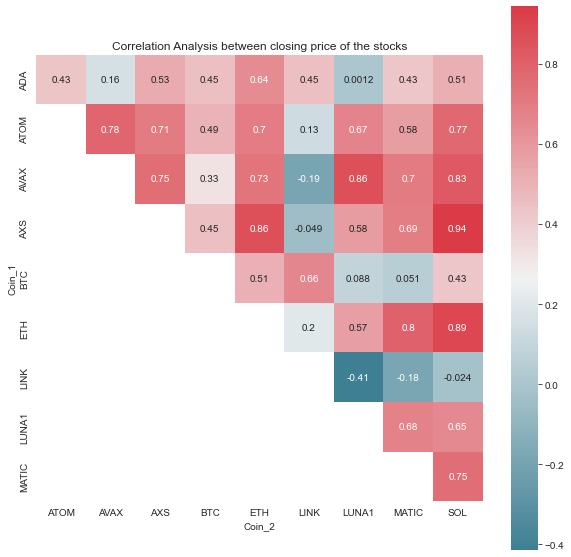

In [23]:
coin_1 = []
coin_2 = []
values = close_2k21.corr().unstack().drop_duplicates().sort_values(ascending=False)[1:].values

for i in close_2k21.corr().unstack().drop_duplicates().sort_values(ascending=False)[1:].index:
    coin_1.append(i[0])
    coin_2.append(i[1])
    
corr_analysis = pd.DataFrame()
corr_analysis['Coin_1'] = coin_1
corr_analysis['Coin_2'] = coin_2
corr_analysis['Values'] = values

corr_analy = corr_analysis.set_index(['Coin_1','Coin_2']).unstack('Coin_2')
corr_analy.columns.names = ['Values','Coin_2']

plt.figure(figsize = (10,10))
sns.heatmap(corr_analy.droplevel(axis=1, level = 'Values'), \
            cmap=sns.diverging_palette(220, 10, as_cmap=True),mask=False,annot = True, annot_kws = {"size": 10}, square = True)
plt.title('Correlation Analysis between closing price of the stocks')

Text(0.5, 1.0, 'SOL & AXS price evolution')

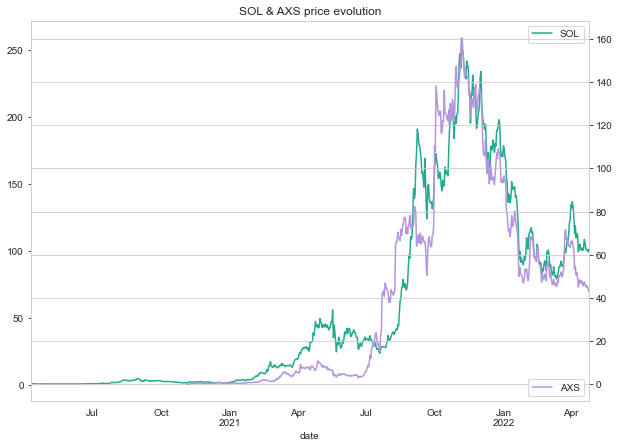

In [46]:
ax1 = data.loc[data.index.get_level_values(0)=='SOL','close'].dropna().droplevel('ticker').plot(figsize=(10,7),color = color4)
ax1.legend(['SOL'],loc='upper left')
ax2 = data.loc[data.index.get_level_values(0)=='AXS','close'].dropna().droplevel('ticker').plot(secondary_y=True,color = color5)
ax2.legend(['AXS'],loc=4)
plt.title('SOL & AXS price evolution')

#### Compare BTC prices with external data

Text(0, 0.5, 'Gold Price')

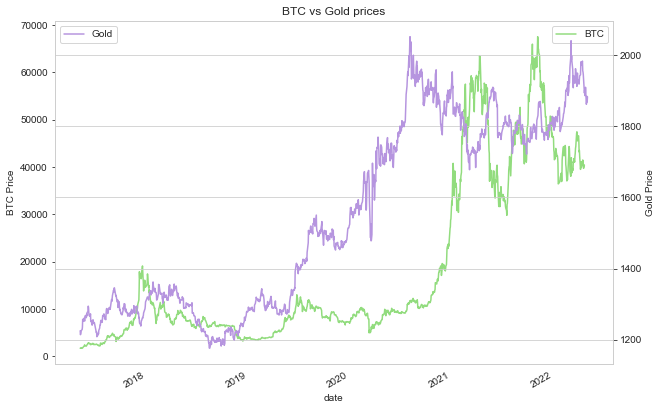

In [242]:
#download oil, gold and S&P, only for visualization
oil = get_metric_prices('CLUSD',key).sort_values('date')
gold = get_metric_prices('GCUSD',key).sort_values('date')
S_P = get_metric_prices('^GSPC',key).sort_values('date')

ax1 = close.loc[close.index.isin(gold.reset_index()['date'].unique())]['BTC'].plot(figsize = (10,7),legend = 'BTC',color = color1)
ax2 = gold['close'].droplevel('ticker').plot(secondary_y=True,legend='Gold',color = color5)
ax1.legend(['BTC'])
ax2.legend(['Gold'])
plt.title('BTC vs Gold prices')
ax1.set_ylabel('BTC Price')
ax2.set_ylabel('Gold Price')

Text(0, 0.5, 'Gold Price')

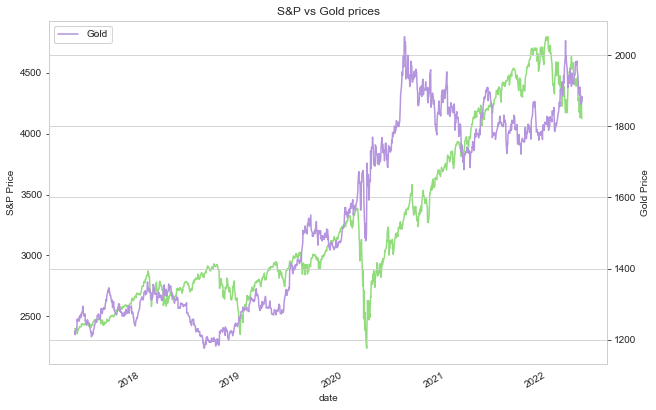

In [243]:
ax1 = S_P['close'].droplevel('ticker').plot(figsize = (10,7),legend='S&P',color = color1)

ax2 = gold['close'].droplevel('ticker').plot(secondary_y=True,legend='Gold',color=color5)
ax1.legend(['S&P'])
ax2.legend(['Gold'])

plt.title('S&P vs Gold prices')
ax1.set_ylabel('S&P Price')
ax2.set_ylabel('Gold Price')


### Cross Validation Process

- The validation process will be performed in a __sliding window__ approach, where at each validation we will train the model using __200 days__ of data and __test it next day__, so every day, except the first 200, will be used for validation, which will give us a pretty solid perspective about the perfomance of the model over time. One major __drawback__ of this approach is the __high computational costs__ necessary to perform the validation for each day at a time.  
- To ensure that the validation period is the __same for every coin__, we will filter our training data to __start at 01-01-2021__. By doing this, our validation process starts at __20-07-2021__, __200 days__ after the training data started.

In [183]:
#filter training set 
train = df_engineer.copy()
train_2021 = train.loc[train.index.get_level_values(1)>='2021-01-01']

In [184]:
#missing values originated from feature engineer because of lagging variables 
#we have 10 coins and the max lag is 20 so, we will lose 200 riows of data
train.isnull().sum()

open                     0
high                     0
low                      0
close                    0
adj_close                0
volume                   0
EMA_2                   10
EMA_7                   60
EMA_20                 190
ATR_2                   20
ATR_7                   70
ATR_20                 200
RSI_2                   20
RSI_7                   70
RSI_20                 200
MOM_2                   20
MOM_7                   70
MOM_20                 200
STD_2                   20
STD_7                   70
STD_20                 200
STD_2_Adj               20
STD_7_Adj               70
STD_20_Adj             200
Stoch                    0
KAMA_2                  20
KAMA_7                  70
KAMA_20                200
OBV                      0
ROC_2                   20
ROC_7                   70
ROC_20                 200
AROON_down_2            20
AROON_up_2              20
AROON_down_7            70
AROON_up_7              70
AROON_down_20          200
A

In [185]:
init_ = len(train)
train = train.dropna()
end_ = len(train)
print(f'We lost {init_ - end_} rows of data')

We lost 200 rows of data


In [186]:
#this function generates the target that we will predict
def pct_gen_x_y (data):
    tomorrow_p = data.groupby('ticker')['close'].shift(-1)
    today_p = data['close']
    data['target'] = (tomorrow_p - today_p) / (today_p)
    x = data.drop(columns = 'target')
    y = data['target']
    y = y.dropna()
    x = x.loc[x.index.isin(y.index)]
    
    y_true = data.groupby('ticker')['close'].shift(-1)
    y_true = y_true.loc[y_true.index.isin(y.index)]
    
    return(x, y, y_true)

#### Genrate X_train and Y_train (Only for date>=2021)

In [187]:
x_train_pct,y_train_pct,train_true = pct_gen_x_y(train_2021)



### Feature Selection
For the feature selection we will use RFE and Lasso selection. We started by performing a correlation analysis between the target and the independent variables, then we performed the RFE and the Lasso. After that, we looked at the correlation analysis betwwen the variables chosen by the model and created a final subset that will be used for prediction.

__Note:__ The functions that created the splits for the cross validation are highly inspired by:  
__https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8__

In [188]:
from dateutil.relativedelta import *
class TimeBasedCV_Continuous(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
        
    the training size increases at each split (same beggining different ends)
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []
        split_dates = pd.DataFrame()
        train_start = []
        train_end = []
        test_start = []
        test_end = []
        a = 1
        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')
            
        
            
        a = 0
        while end_test < data[date_column].max().date():
            a = a+30
            
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
#             print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
#                   "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)
            train_start.append(start_train)
            test_start.append(start_test)
            train_end.append(end_train)
            test_end.append(end_test)
            # update dates:
            start_train = validation_split_date 
            end_train = start_train + eval('relativedelta('+self.freq+f'={self.train_period+a})')
            
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        split_dates['Start_Train'] = train_start
        split_dates['End_Train'] = train_end
        split_dates['Start_Test'] = test_start
        split_dates['End_Test'] = test_end
        
        return (index_output,split_dates)
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return (self.n_splits,split_dates) 
    
    
class TimeBasedCV_block(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
        
    the training splits have always the same size and move forward to the future at each split 
    (different begginings, different ends)
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []
        split_dates = pd.DataFrame()
        train_start = []
        train_end = []
        test_start = []
        test_end = []
        
        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
#             print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
#                   "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)
            train_start.append(start_train)
            test_start.append(start_test)
            train_end.append(end_train)
            test_end.append(end_test)
            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        split_dates['Start_Train'] = train_start
        split_dates['End_Train'] = train_end
        split_dates['Start_Test'] = test_start
        split_dates['End_Test'] = test_end
        
        return (index_output,split_dates)
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return (self.n_splits,split_dates) 

#### Target Correlation Analysis

Text(0.5, 0, 'Correlation')

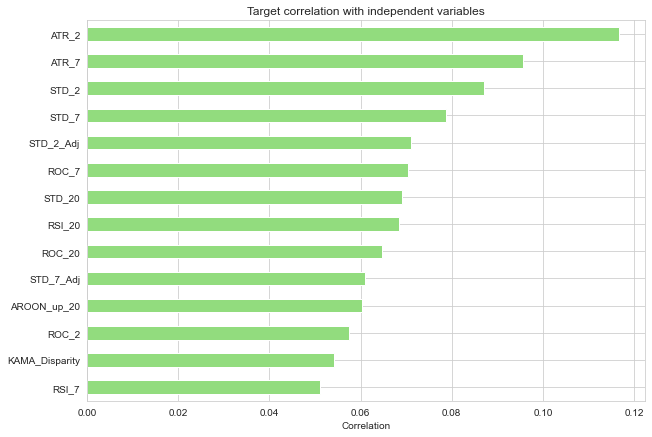

In [246]:
cor = pd.concat([x_train_pct,y_train_pct],axis=1)
abs(cor.corr()['target']).sort_values(ascending=True)[-15:-1].plot.barh(figsize = (10,7),color=color1)
plt.title('Target correlation with independent variables')
plt.xlabel('Correlation')

### RFE

In [ ]:
#RFE for regression problems
#this functions performs RFE with a custom CV created for time series 

def RFECV_regressor_TS (x,y, n_best, model):55
    from sklearn.feature_selection import RFECV
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
    
    from sklearn.model_selection import cross_validate
    model = model
    cv = TimeBasedCV_block(train_period=100,test_period=50)
    skf = cv.split(x_train.reset_index(), date_column='date')[0]
    cv_ = cross_validate(model,x,y,cv = skf,scoring=['neg_root_mean_squared_error'])
    
    test_mean = np.mean(cv_['test_neg_root_mean_squared_error']*-1).round(2)
    print(f'The test RMSE is {test_mean}')
    
    threshold = n_best # the number of most relevant features
    selector = selector = RFECV(estimator=model,cv =skf, min_features_to_select=3)
    selector_x = selector.fit_transform(x,y)
    selector_ind = selector.get_support()
    
    selector.ranking_
    selected_features = pd.Series(selector.support_, index = x.columns)
    selected_features = selected_features.sort_values(ascending=False).iloc[:n_best]
    return(selected_features)
    

In [601]:
from sklearn.tree import DecisionTreeRegressor
RFECV_pct = RFECV_regressor_TS(x_train_pct,y_train_pct,10,DecisionTreeRegressor(max_depth=4,max_features=0.6,random_state=0))

The test RMSE is 0.09


In [597]:
rfe_pct_subset = RFECV_pct.index

In [226]:
rfe_pct_subset = ['SMA_20', 'open', 'AROON_down_20', 'KAMA_20', 'OBV', 'ROC_2', 'ROC_7',
       'ROC_20', 'AROON_down_2', 'AROON_up_2']

### Lasso 

Lasso picked 29 variables and eliminated the other 20 variables


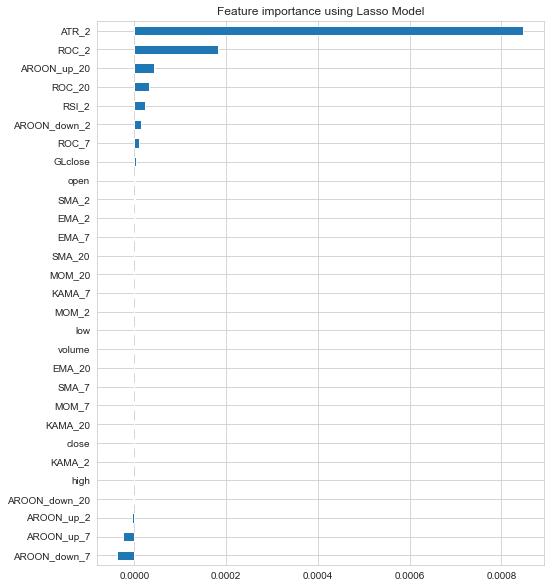

In [609]:
def lasso_selection (x, y):
    from sklearn.linear_model import Lasso
    reg = Lasso(alpha=0.005,random_state=0)
    reg.fit(x,y)
    coef = pd.Series(reg.coef_, index = x.columns)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    return(coef.loc[abs(coef.values)>0.000])

def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
    
lasso_pct = lasso_selection(x_train_pct,y_train_pct)
plot_importance(lasso_pct,'Lasso')

In [611]:
lasso_subset_pct = abs(lasso_pct).sort_values(ascending=False).index

In [612]:
lasso_subset_pct = ['ATR_2', 'RSI_2', 'ATR_7', 'ATR_20', 'RSI_20', 'ROC_2', 'AROON_up_2',
       'AROON_up_7', 'RSI_7']

#### Independent variables correlation analysis

#### Variables with correlation above absolute 0.85 will be removed from the same subset

In [614]:
def cor_heat_map (corr):
    plt.figure(figsize = (30, 30))
    sns.heatmap(corr, vmax = 1, vmin=-1, linewidths = 0.1,
               annot = True, annot_kws = {"size": 10}, square = True)
    plt.show()

In [284]:
#RFE subset after eliminating correlated variables
rfe_pct_subset = ['Avg_Price_Disparity',  'AROON_down_20', 'KAMA_20', 'OBV',
       'ROC_2', 'ROC_7', 'ROC_20', 'AROON_down_2', 'AROON_up_2']

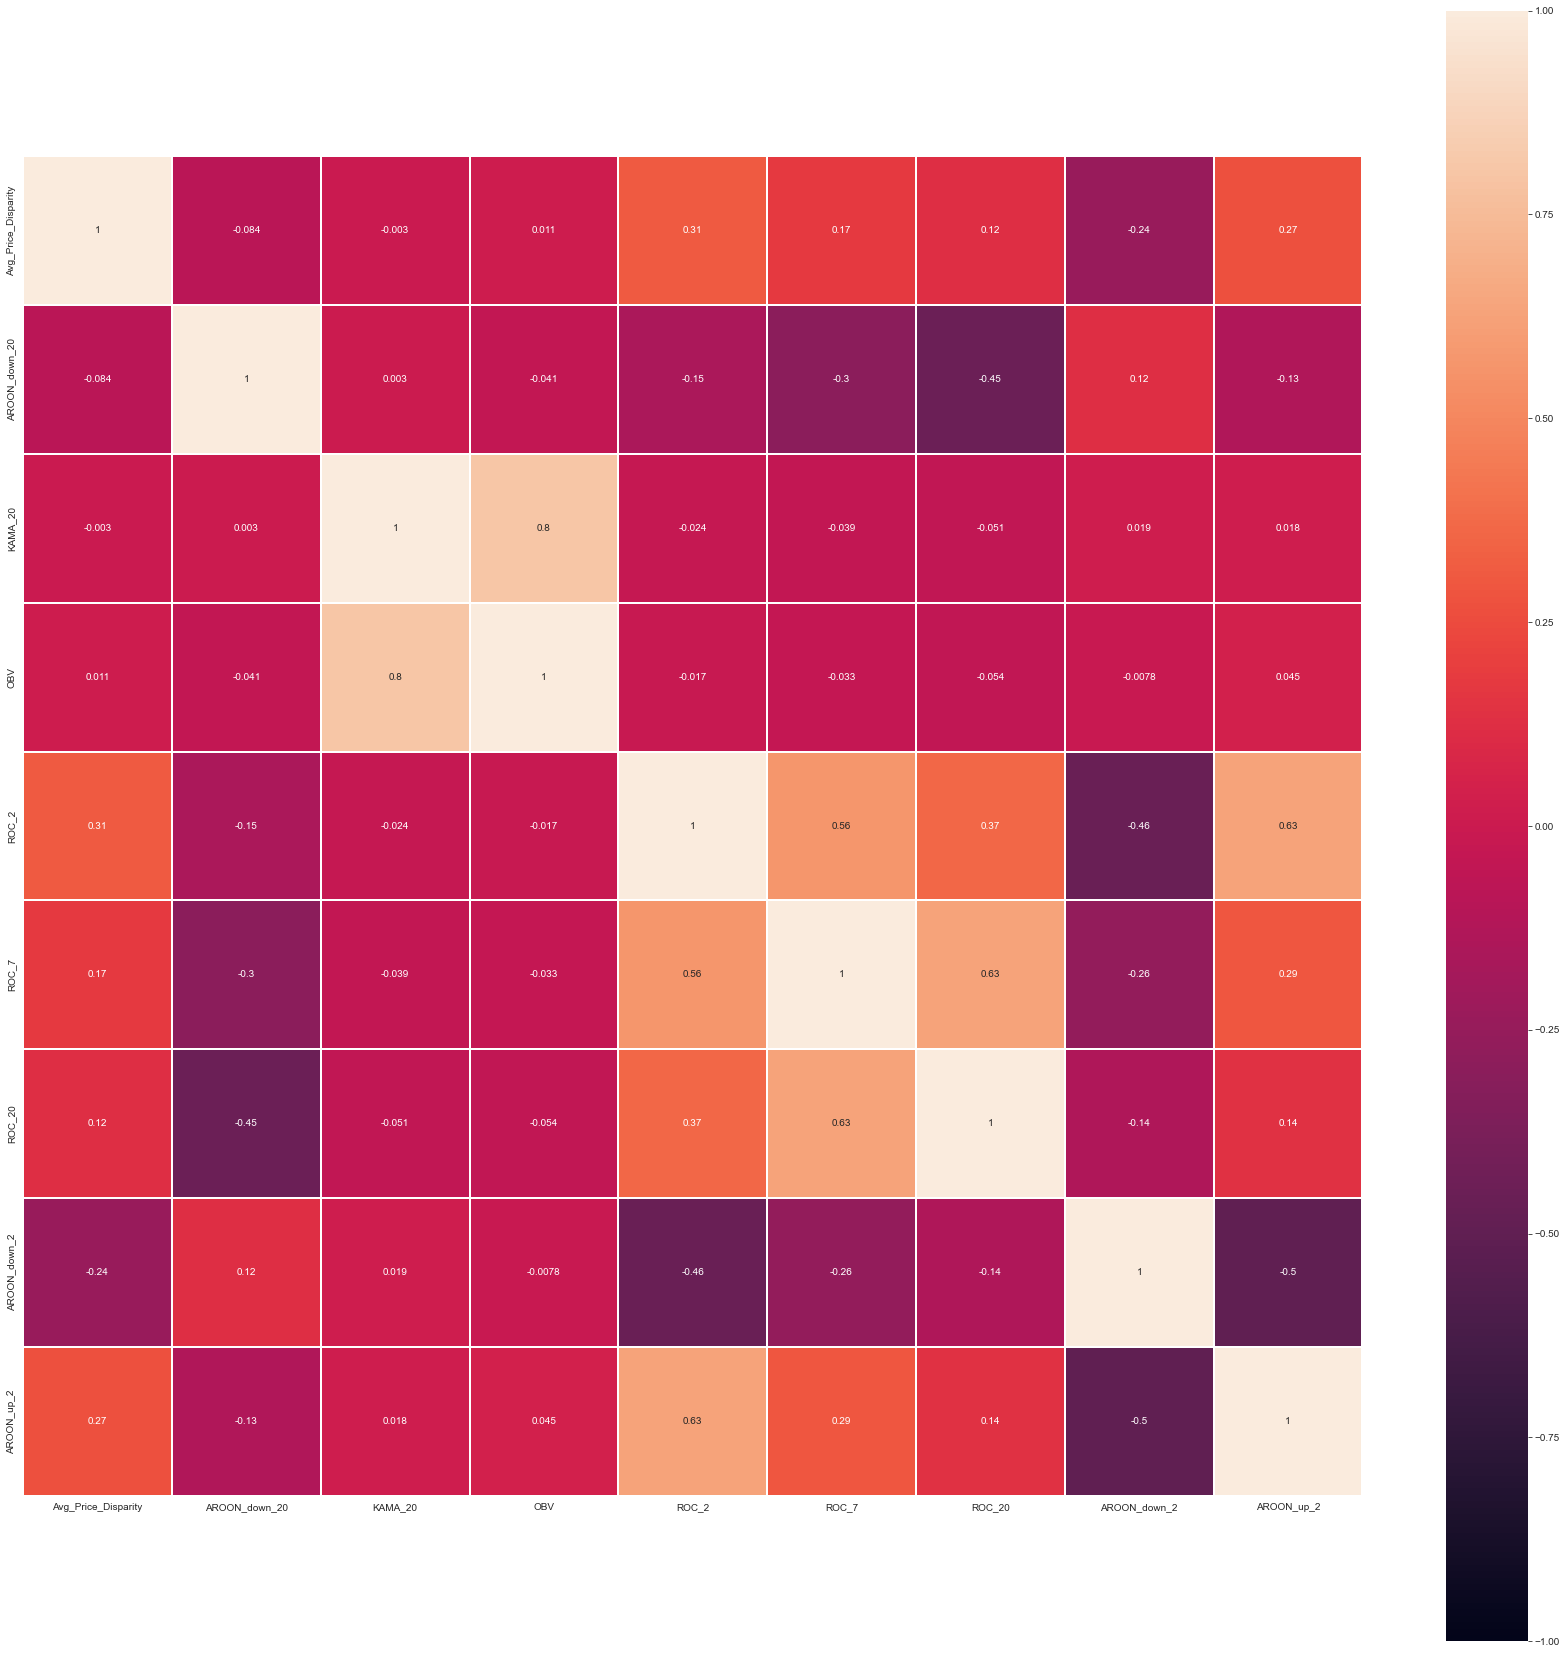

In [285]:
cor_heat_map(x_train[rfe_pct_subset].corr())

In [298]:
#Lasso subset after eliminating correlated variables
lasso_subset_pct = ['ATR_2', 'RSI_2', 'ATR_20', 'ROC_2', 'AROON_up_2',
       'AROON_up_7', 'RSI_7']

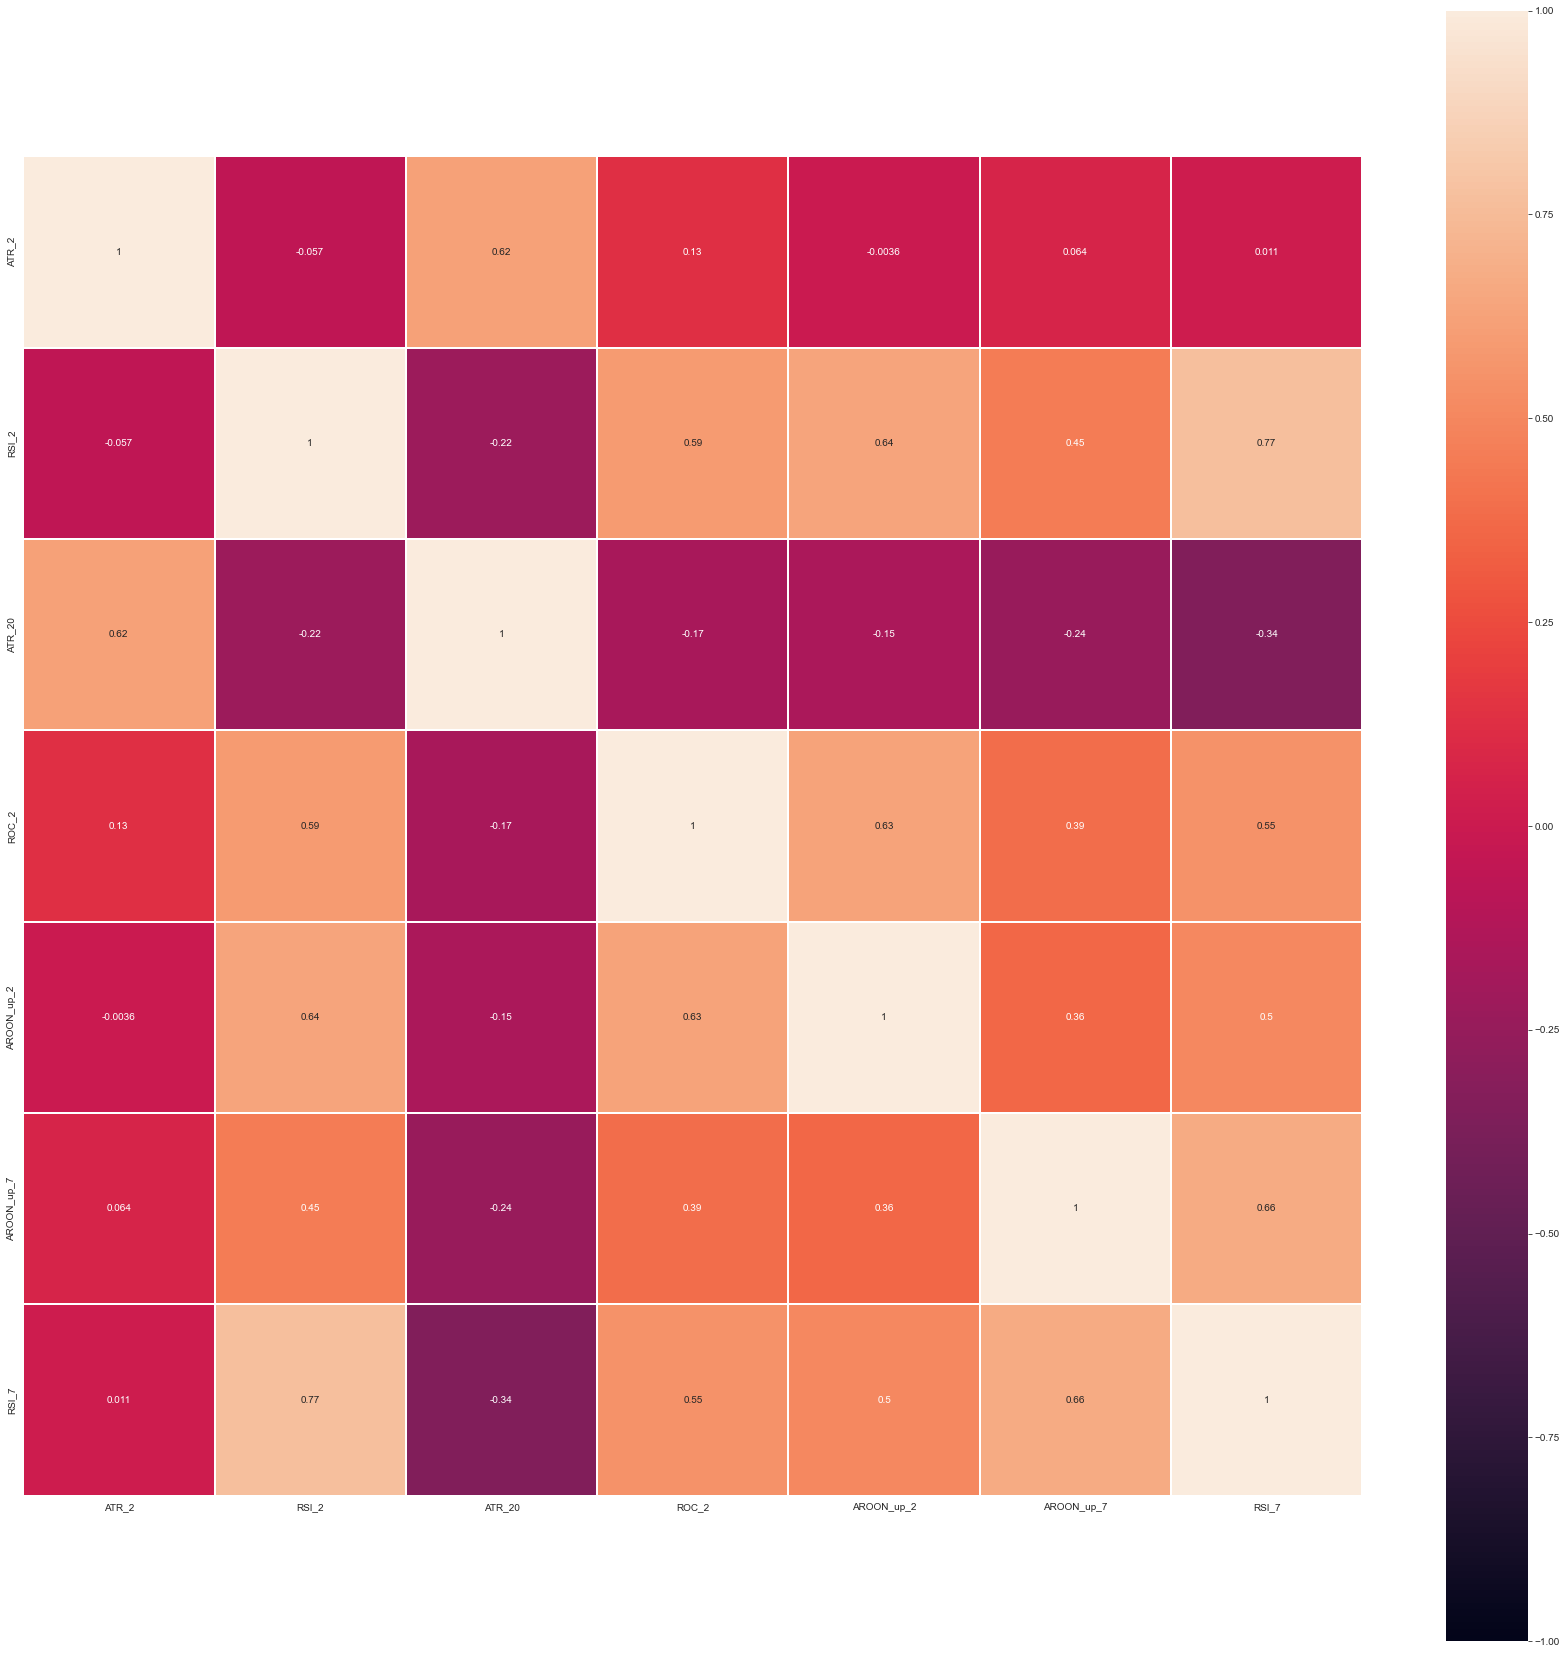

In [299]:
cor_heat_map(x_train[lasso_subset_pct].corr())

In [83]:
pct_final_subset = ['ATR_2', 'RSI_2', 'ATR_20','Avg_Price_Disparity','AROON_down_2', 'AROON_up_2','ROC_2'
                   ,'OBV','RSI_7','ROC_20']

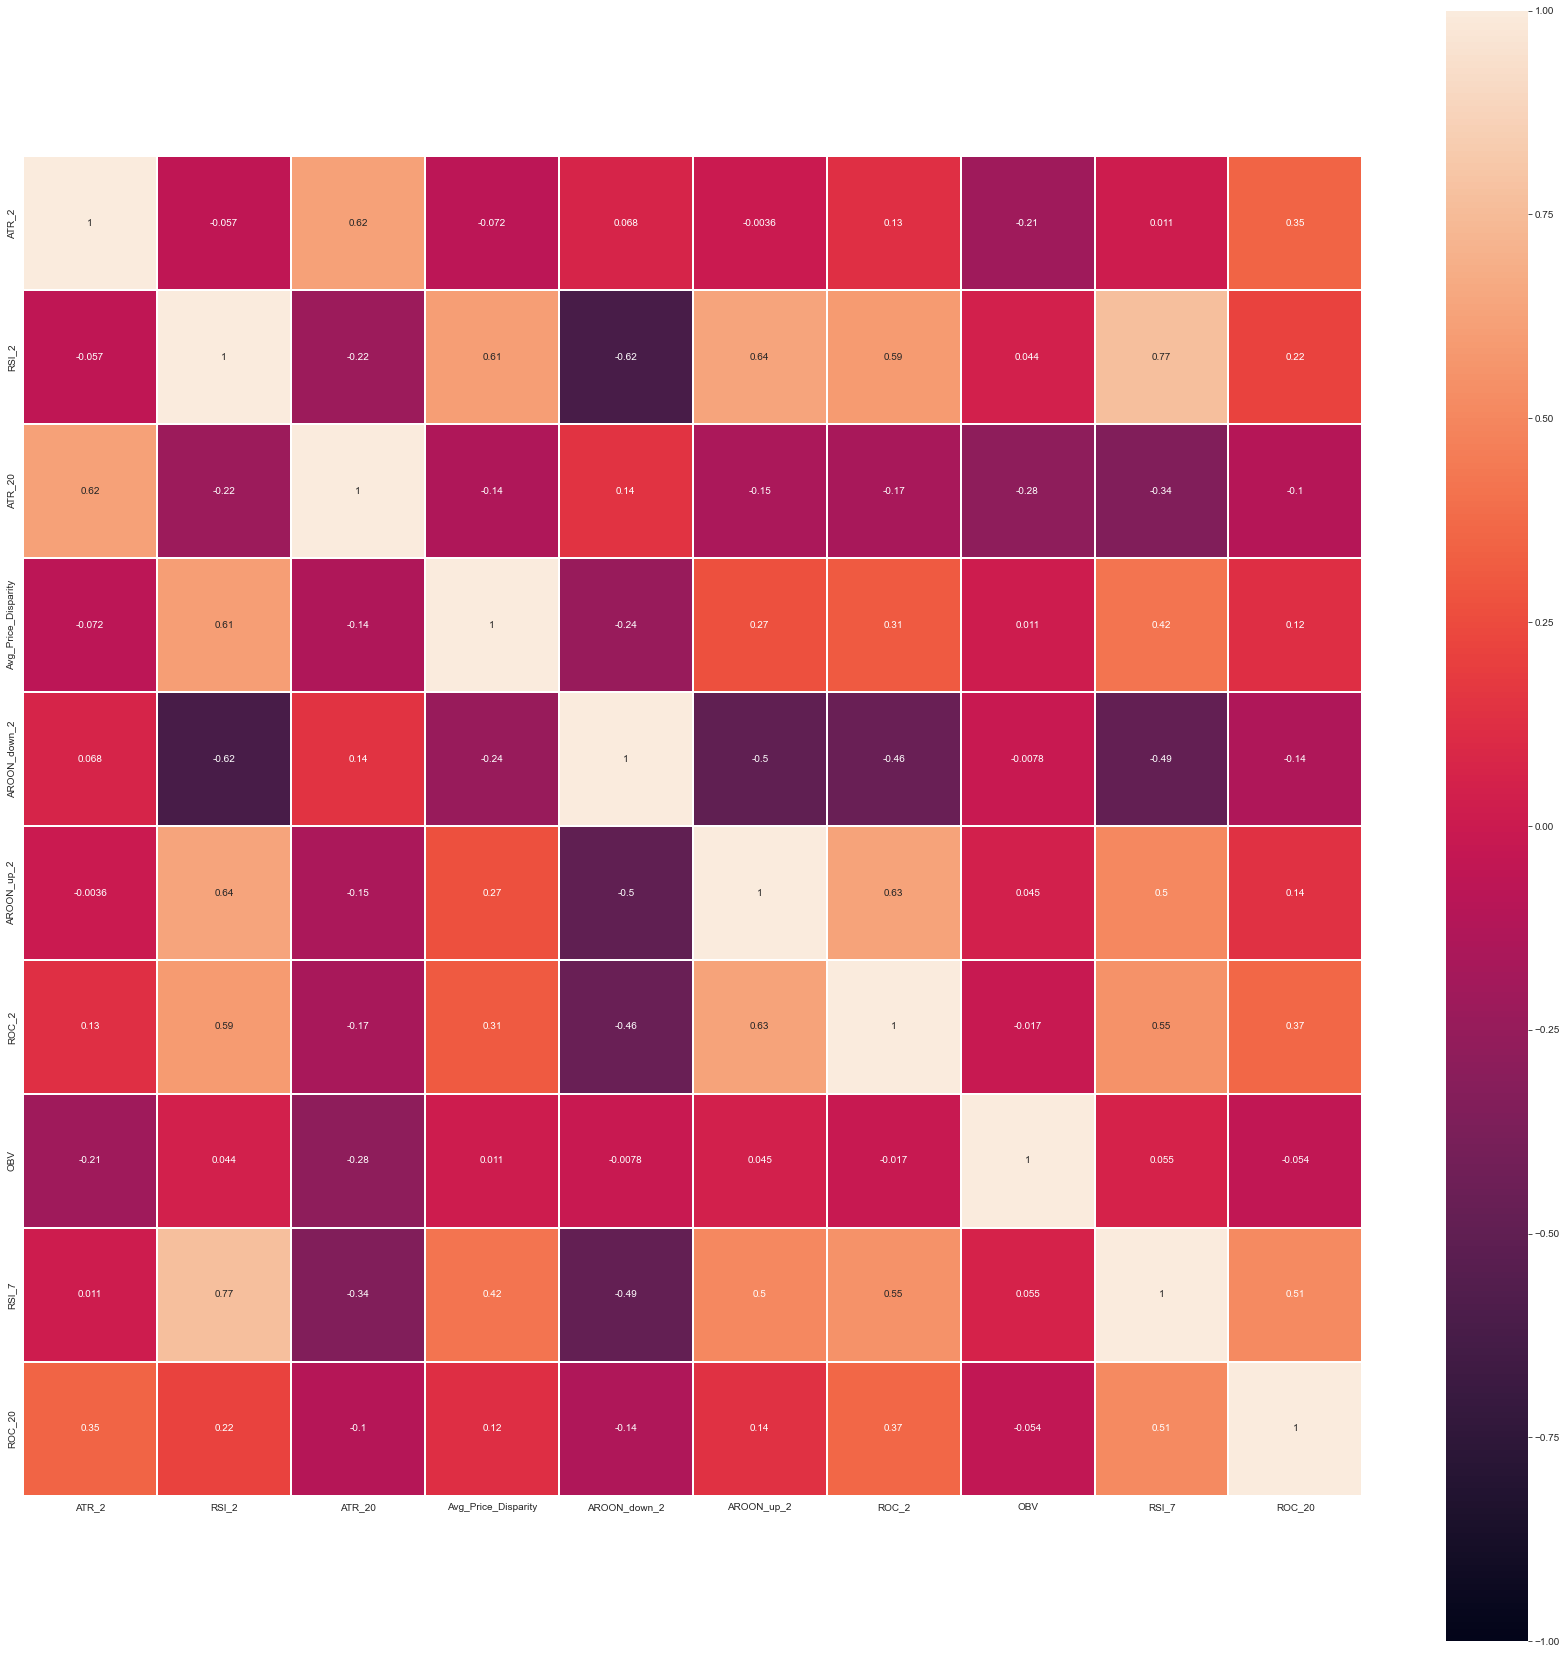

In [313]:
cor_heat_map(x_train[pct_final_subset].corr())

#### Final Subset

In [161]:
pct_final_subset = ['ATR_2', 'RSI_2', 'ATR_20','Avg_Price_Disparity','AROON_down_2', 'AROON_up_2','ROC_2'
                   ,'OBV','RSI_7','ROC_20']

print(pct_final_subset)

['ATR_2', 'RSI_2', 'ATR_20', 'Avg_Price_Disparity', 'AROON_down_2', 'AROON_up_2', 'ROC_2', 'OBV', 'RSI_7', 'ROC_20']


### Functions for modelling 

For the modelling stage, auxiliary functions were created to facilitate the process of cross validation, modelling generation and further assessment.  
- __TS_Kfold_regression_adjusted__ - generates the cross-validation process using a sliding window approach where we can determine the train and test size for each split. In our case we used a training size of 200 and a test size of 1, meaning that throughout the iterations the training and the test set advanced 1 day each until it reached the end of the training set (only the first 200 observations of the whole timestamp were not tested during the process). The function receives an x and a y, and in our case, after training the model it converts the predictions to dollar values. It stores and returns all the relevant scores and counts the CV time. generates the cross-validation process using a sliding window approach where we can determine the train and test size for each split. In our case we used a training size of 200 and a test size of 1, meaning that throughout the iterations the training and the test set advanced 1 day each until it reached the end of the training set (only the first 200 observations of the whole timestamp were not tested during the process). The function receives an x and a y, and in our case, after training the model it converts the predictions to dollar values. It stores and returns all the relevant scores and counts the CV time.  

- __TS_Kfold_regression_adjusted_gru & TS_Kfold_regression_adjusted_lstm__ - adaptation of the function above to work with keras
- __gen_GRU__ - generates and trains the GRU model, if there are many observations with the same timestamp then it's possible to filter the training session per a certain category (in our case ticker, aka, coins) when this happens, the model is trained one time for each class in the category (10 times for us) and each time a model is trained \, all the relevant assessment information is stored in dictionaries where the keys are the category classes (the tickers). The model performs an automatic min_max scaler (only fitted to the train set) that can be easily changed, it calls __GRU_NN__ to fit the model.
- __gen_LSTM__ - adaptation of the function above for LSTM, the only change is the usage of __LSTM_NN__ instead of GRU_NN
- __model_assess__ - created to train and predict all the coins using the cross-validation function, at each iteration, the function stores the trained model, the predictions, and metrics in a dictionary where the keys are the tickers (in our case each dict has 10 keys)  
- __gen_val_assess__ - created to further assess the predictions generated by the cross validation, we were using a sliding window of 1 its possible to make a detailed assessment of the evolution of rhe error over time, being able to easily spot moments were the model underperformed or not
- __assess_classification__ - created to assess the model performance regarding market movement, meaning that, if the model predicted a increase in price, then we would have a label of 1, then this results were compared with the actual moves of the market 

##### LSTM Functions

In [189]:
def reset_random_seeds():
    import random
    from numpy.random import seed
    import os
    from tensorflow import random as r
    os.environ['PYTHONHASHSEED']=str(2)
    r.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
reset_random_seeds()
#https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

def create_model(units, m):
        model = Sequential()
        model.add(m (units = units, return_sequences = True,
                    input_shape = [X_train.shape[1], X_train.shape[2]]))
        model.add(Dropout(0.2))
        model.add(m (units = units))
        model.add(Dropout(0.2))
        model.add(Dense(units = 1))
        #Compile model
        model.compile(loss='mse', optimizer='adam')
        return model
    
    
def LSTM_NN (X_train,Y_train,X_val,Y_val,epochs, batch_size,units,timestamp,optimizer = 'adam',activation = 'relu',lr=0.1):
    reset_random_seeds()
    X_train,Y_train=  create_dataset(np.array(X_train),np.array(Y_train),timestamp)
    X_val,Y_val = create_dataset(np.array(X_val),np.array(Y_val),timestamp)
    print(X_train.shape)
    
 
    #len_ =len(x_train.columns)
    from keras.models import Sequential
    from keras.layers import Dense, GRU, Dropout, LSTM,Bidirectional
    from keras.wrappers.scikit_learn import KerasClassifier
    if optimizer == 'adam':
        optimizer = keras.optimizers.adam_v2.Adam(lr=lr)
    model = Sequential() # Model
    model.add(LSTM (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]],activation=activation))
    #model.add(Dropout(0.2))
    model.add(LSTM (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer=optimizer, # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'],) # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
    
    history = model.fit(X_train,Y_train,epochs=epochs,validation_data=(X_val, Y_val),batch_size=batch_size,shuffle = False)
    return(model,history)



def gen_LSTM (x_train,y_train,x_test,y_test, subset,col,epochs,batch_size,units,optimizer = 'adam',activation = 'relu',lr=0.1):
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
    from sklearn.preprocessing import MinMaxScaler
    full_assess = pd.DataFrame()
    tickers = []
    RMSE_ = []
    MAE_ = []
    pct_RMSE_ = []
    pct_MAE_ = []
    model_dict = {}
    date= []
    history_dict = pd.DataFrame()
    for i in x_train.reset_index()[f'{col}'].unique():
        tickers.append(i)
        scaler_x = MinMaxScaler(feature_range = (-1,1))
        scaler_y = MinMaxScaler(feature_range = (-1,1))
        print(i)
        fx_train = x_train.loc[x_train.index.get_level_values(0)==i,subset].copy()
        fy_train = y_train.loc[y_train.index.get_level_values(0)==i,:].copy()
        fx_test = x_test.loc[x_test.index.get_level_values(0)==i,subset].copy()
        fy_test = y_test.loc[y_test.index.get_level_values(0)==i,:].copy()



        # Apply the scaler to training data
        input_scaler = scaler_x.fit(fx_train)
        fx_train = input_scaler.transform(fx_train)
        # Apply the scaler to test data
        fx_test = input_scaler.transform(fx_test)
        
        nn,history = LSTM_NN(fx_train,fy_train,fx_test,fy_test,epochs,batch_size,units,1,optimizer = optimizer, \
                             activation = activation,lr = 0.1)
        model = nn
        model_dict[f'{i}'] = model
        #history_dict[f'{i}'] = history


        close_temp = x_test.loc[x_test.index.get_level_values(0)==i,'close'].copy().iloc[1:]
        target_temp = x_test.loc[x_test.index.get_level_values(0)==i,'close'].groupby('ticker').shift(-1).copy().iloc[1:]
        fx_train = x_train.loc[x_train.index.get_level_values(0)==i,subset].copy()
        fy_train = y_train.loc[y_train.index.get_level_values(0)==i,:].copy()
        fx_test = x_test.loc[x_test.index.get_level_values(0)==i,:].copy()
        fy_test = y_test.loc[y_test.index.get_level_values(0)==i,:].copy()


        #print(x_train.loc[x_train.index.get_level_values(0)==i,:].copy().index.get_level_values(1).unique()[-1])
        test_x = input_scaler.transform(fx_test[subset])
        test_x, test_y = create_dataset(test_x,np.array(fy_test),1)
        gru_assess = fx_test.iloc[1:,:].copy()
        #gru_assess['close'] = close_temp
        pred = nn.predict(test_x)
        pred_ = []
        for i in pred:
            pred_.append(i[0])
        gru_assess['Prediction'] = ((close_temp * pred_) + close_temp).values
        gru_assess['Target'] = gru_assess['close'].groupby('ticker').shift(-1)
        gru_assess['Prediction_pct'] = pred
        gru_assess['Target_pct'] = fy_test
        gru_assess['date'] = close_temp.index.get_level_values(1)
        
        history_dict = pd.concat([history_dict,gru_assess],axis=0)
        

        gru_assess = gru_assess.dropna()


        rmse = np.sqrt(mean_squared_error(gru_assess['Target'], gru_assess['Prediction']))
        mae = mean_absolute_error(gru_assess['Target'], gru_assess['Prediction'])
        RMSE_.append(rmse)
        MAE_.append(mae)
        
        pct_rmse = np.sqrt(mean_squared_error(gru_assess['Target_pct'], gru_assess['Prediction_pct']))
        pct_mae = mean_absolute_error(gru_assess['Target_pct'], gru_assess['Prediction_pct']) 
        pct_RMSE_.append(pct_rmse)
        pct_MAE_.append(pct_mae)

        print(f'Test RMSE: {rmse}')
        print(f'Test MAE: {mae}')

    full_assess['Ticker'] = tickers
    full_assess['RMSE'] = RMSE_
    full_assess['MAE'] = MAE_
    full_assess['pct_RMSE'] = pct_RMSE_
    full_assess['pct_MAE'] = pct_MAE_
    return(model, full_assess,model_dict,history_dict,pred_)

    


    

##### GRU Model

In [286]:
import keras
keras.layers.convolutional

keras.layers.pooling.AveragePooling1D

In [190]:
#https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

def create_model(units, m):
        model = Sequential()
        model.add(m (units = units, return_sequences = True,
                    input_shape = [X_train.shape[1], X_train.shape[2]]))
        model.add(Dropout(0.2))
        model.add(m (units = units))
        model.add(Dropout(0.2))
        model.add(Dense(units = 1))
        #Compile model
        model.compile(loss='mse', optimizer='adam')
        return model
    
    
def GRU_NN (X_train,Y_train,X_val,Y_val,epochs, batch_size,units,timestamp,optimizer = 'adam',activation = 'relu'):
    reset_random_seeds()
    X_train,Y_train=  create_dataset(np.array(X_train),np.array(Y_train),timestamp)
    X_val,Y_val = create_dataset(np.array(X_val),np.array(Y_val),timestamp)
    print(X_train.shape)
    
 
    #len_ =len(x_train.columns)
    from keras.models import Sequential
    from keras.layers import Dense, GRU, Dropout, LSTM,Bidirectional
    from keras.wrappers.scikit_learn import KerasClassifier

    model = Sequential(name="GRU-Model") # Model
    model.add(GRU (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]],activation=activation))
    #model.add(Dropout(0.2))
    model.add(GRU (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer=optimizer, # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'],) # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
    
    history = model.fit(X_train,Y_train,epochs=epochs,validation_data=(X_val, Y_val),batch_size=batch_size,shuffle = False)
    return(model,history)



def gen_GRU (x_train,y_train,x_test,y_test, subset,col, epochs,batch_size,units,optimizer = 'adam',activation = 'relu'):
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
    from sklearn.preprocessing import MinMaxScaler
    full_assess = pd.DataFrame()
    tickers = []
    RMSE_ = []
    MAE_ = []
    pct_RMSE_ = []
    pct_MAE_ = []
    model_dict = {}
    date= []
    history_dict = pd.DataFrame()
    for i in x_train.reset_index()[f'{col}'].unique():
        tickers.append(i)
        scaler_x = MinMaxScaler(feature_range = (-1,1))
        scaler_y = MinMaxScaler(feature_range = (-1,1))
        print(i)
        fx_train = x_train.loc[x_train.index.get_level_values(0)==i,subset].copy()
        fy_train = y_train.loc[y_train.index.get_level_values(0)==i,:].copy()
        fx_test = x_test.loc[x_test.index.get_level_values(0)==i,subset].copy()
        fy_test = y_test.loc[y_test.index.get_level_values(0)==i,:].copy()



        # Apply the scaler to training data
        input_scaler = scaler_x.fit(fx_train)
        fx_train = input_scaler.transform(fx_train)
        # Apply the scaler to test data
        fx_test = input_scaler.transform(fx_test)
        
        nn,history = GRU_NN(fx_train,fy_train,fx_test,fy_test,epochs,batch_size,units,1,optimizer = optimizer,activation = activation)
        model = nn
        model_dict[f'{i}'] = model
        #history_dict[f'{i}'] = history


        close_temp = x_test.loc[x_test.index.get_level_values(0)==i,'close'].copy().iloc[1:]
        target_temp = x_test.loc[x_test.index.get_level_values(0)==i,'close'].groupby('ticker').shift(-1).copy().iloc[1:]
        fx_train = x_train.loc[x_train.index.get_level_values(0)==i,subset].copy()
        fy_train = y_train.loc[y_train.index.get_level_values(0)==i,:].copy()
        fx_test = x_test.loc[x_test.index.get_level_values(0)==i,:].copy()
        fy_test = y_test.loc[y_test.index.get_level_values(0)==i,:].copy()


        #print(x_train.loc[x_train.index.get_level_values(0)==i,:].copy().index.get_level_values(1).unique()[-1])
        test_x = input_scaler.transform(fx_test[subset])
        test_x, test_y = create_dataset(test_x,np.array(fy_test),1)
        gru_assess = fx_test.iloc[1:,:].copy()
        #gru_assess['close'] = close_temp
        pred = nn.predict(test_x)
        pred_ = []
        for i in pred:
            pred_.append(i[0])
        gru_assess['Prediction'] = ((close_temp * pred_) + close_temp).values
        gru_assess['Target'] = gru_assess['close'].groupby('ticker').shift(-1)
        gru_assess['Prediction_pct'] = pred
        gru_assess['Target_pct'] = fy_test
        gru_assess['date'] = close_temp.index.get_level_values(1)
        
        history_dict = pd.concat([history_dict,gru_assess],axis=0)
        

        gru_assess = gru_assess.dropna()


        rmse = np.sqrt(mean_squared_error(gru_assess['Target'], gru_assess['Prediction']))
        mae = mean_absolute_error(gru_assess['Target'], gru_assess['Prediction'])
        RMSE_.append(rmse)
        MAE_.append(mae)
        
        pct_rmse = np.sqrt(mean_squared_error(gru_assess['Target_pct'], gru_assess['Prediction_pct']))
        pct_mae = mean_absolute_error(gru_assess['Target_pct'], gru_assess['Prediction_pct']) 
        pct_RMSE_.append(pct_rmse)
        pct_MAE_.append(pct_mae)

        print(f'Test RMSE: {rmse}')
        print(f'Test MAE: {mae}')

    full_assess['Ticker'] = tickers
    full_assess['RMSE'] = RMSE_
    full_assess['MAE'] = MAE_
    full_assess['pct_RMSE'] = pct_RMSE_
    full_assess['pct_MAE'] = pct_MAE_
    return(model, full_assess,model_dict,history_dict,pred_)

##### Cross Validation Function

In [191]:
def TS_Kfold_regression_adjusted (X_train,y_train, y_true,date_col,model,train_lenght, test_lenght,subset):
    import time
    start = time.time()
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeBasedCV_block(train_period=train_lenght,
                   test_period=test_lenght,
                   freq='days')
    skf, split_df = tscv.split(X_train.reset_index(), date_column='date')
    avg_score_train = []
    avg_score_test = []
    avg_precision_test = []
    avg_precision_train = []
    avg_recall_test = []
    avg_recall_train = []
    avg_accuracy_train = []
    avg_accuracy_test = []
    rmse_pct_train = []
    mae_pct_train = []
    
    rmse_pct_test = []
    mae_pct_test = []
    
    scores = pd.DataFrame()
    train_score = []
    test_score = []
    train_recall = []
    test_recall = []
    train_precision = []
    test_precision = []
    train_accuracy = []
    test_accuracy = []
    
    predictions = []
    predictions_price= []
    close_price = []
    target_price = []
    target_pct = []
    date = []
    
    for train_index, test_index in skf:
        x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        algo = model.fit(x_train[subset], Y_train)
        
        tomorrow_train = y_true[train_index]
        today_train = x_train['close']
        pred_train = algo.predict(x_train[subset])
        predicted_train = (pred_train * today_train)+ today_train
        
        tomorrow_test = y_true[test_index]
        today_test = x_test['close']
        pred_test = algo.predict(x_test[subset])
        predicted_test = (pred_test * today_test)+ today_test
        predictions.append(pred_test[0])
        predictions_price.append(predicted_test[0])
        close_price.append(today_test[0])
        target_pct.append(Y_test[0])
        
        target_price.append(y_true[test_index][0])
        #print(y_true[test_index][0])
        
        date.append(x_test.index.get_level_values(1).values[0])
        
        rmse_pct_train.append(np.sqrt(mean_squared_error(Y_train,pred_train))) 
        mae_pct_train.append(mean_absolute_error(Y_train,pred_train))  
        
        rmse_pct_test.append(np.sqrt(mean_squared_error(Y_test,pred_test)))
        mae_pct_test.append(mean_absolute_error(Y_test,pred_test))  
        
        
        
        #f1 = MAE
        f1_train = mean_absolute_error(tomorrow_train,predicted_train)
        #Recall - MSE
        recall_train = np.sqrt(mean_squared_error(tomorrow_train,predicted_train))
        #precision - R2
        precision_train = r2_score(tomorrow_train,predicted_train)
        #accuracy - median absolute error
        accuracy_train = median_absolute_error(tomorrow_train,predicted_train)
        
        f1_test = mean_absolute_error(tomorrow_test,predicted_test)
        recall_test = np.sqrt(mean_squared_error(tomorrow_test,predicted_test))
        precision_test = r2_score(tomorrow_test,predicted_test)
        accuracy_test = median_absolute_error(tomorrow_test,predicted_test)
        
        train_score.append(f1_train)
        train_recall.append(recall_train)
        train_precision.append(precision_train)
        train_accuracy.append(accuracy_train)
        
        test_score.append(f1_test)
        test_recall.append(recall_test)
        test_precision.append(precision_test)
        test_accuracy.append(accuracy_test)
        
        avg_score_train.append(np.round(np.mean(train_score),3))
        avg_score_test.append(np.round(np.mean(test_score),3))
        avg_recall_test.append(np.round(np.mean(test_recall),3))
        avg_recall_train.append(np.round(np.mean(train_recall),3))
        avg_precision_test.append(np.round(np.mean(test_precision),3))
        avg_precision_train.append(np.round(np.mean(train_precision),3))
        avg_accuracy_train.append(np.round(np.mean(train_accuracy),3))
        avg_accuracy_test.append(np.round(np.mean(test_accuracy),3))
    
    #Train
    scores['R2_train'] = avg_precision_train
    scores['MAE_train'] = avg_score_train
    scores['RMSE_train'] = avg_recall_train
    scores['Median_AE_train'] = avg_accuracy_train
    scores['pct_RMSE_train'] = rmse_pct_train
    scores['pct_MAE_train'] = mae_pct_train
    
    
    #test
    scores['R2_test'] = avg_precision_test
    scores['MAE_test'] = avg_score_test
    scores['RMSE_test'] = avg_recall_test
    scores['Median_AE_test'] = avg_accuracy_test
    scores['pct_RMSE_test'] = rmse_pct_test
    scores['pct_MAE_test'] = mae_pct_test
    
    
    returns = {}
    #print(target_price)
    returns['scores'] = scores
    returns['model'] = model
    return_pred = pd.DataFrame()
    return_pred['date'] = date
    return_pred['close'] = close_price
    return_pred['Target'] = target_price
    return_pred['Predictions'] = predictions_price
    return_pred['Target_pct'] = target_pct
    return_pred['Predictions_pct'] = predictions
    
    
    print(f'Cross Validation Scores:')
    print(f'Model : {model}')
    print(' ')
    print(f'Avg Train R2: {np.round(np.mean(avg_precision_train),3)}')
    print(f'Avg Test R2: {np.round(np.mean(avg_precision_test),3)}')
    print(' ')
    print(f'Avg Train MAE: {np.round(np.mean(avg_score_train),3)}')
    print(f'Avg Test MAE: {np.round(np.mean(avg_score_test),3)}')
    print(' ')
    print(f'Avg Train RMSE: {np.round(np.mean(avg_recall_train),3)}')
    print(f'Avg Test RMSE: {np.round(np.mean(avg_recall_test),3)}')
    end = time.time()
    print(' ')
    print (f'The CV lasted:, {end - start} seconds')
    return(returns,split_df,x_train,x_test,return_pred)


##### CV function for keras

In [192]:
def TS_Kfold_regression_adjusted_gru (X_train,y_train, y_true,date_col,train_lenght, test_lenght,subset, \
                                       col, epochs,batch_size,units,optimizer, activation):
    
    import time
    start = time.time()
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeBasedCV_block(train_period=train_lenght,
                   test_period=test_lenght,
                   freq='days')
    skf, split_df = tscv.split(X_train.reset_index(), date_column='date')
    avg_score_train = []
    avg_score_test = []
    avg_precision_test = []
    avg_precision_train = []
    avg_recall_test = []
    avg_recall_train = []
    avg_accuracy_train = []
    avg_accuracy_test = []
    
    scores = pd.DataFrame()
    train_score = []
    test_score = []
    train_recall = []
    test_recall = []
    train_precision = []
    test_precision = []
    train_accuracy = []
    test_accuracy = []
    hist_dict = pd.DataFrame()
    
    to_assess = pd.DataFrame()
    a = 0
    predictions = []
    for train_index, test_index in skf:
        a = a+1
        x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        gru,assess_df,model_dict,history_dict,pred_ = gen_GRU(x_train,Y_train, x_test,Y_test, subset,col, epochs \
                                                              ,batch_size,units,optimizer=optimizer,activation=activation)
        
        
        assess_df['Validation'] = a
        to_assess = pd.concat([to_assess,assess_df],axis=0)
        predictions.append(pred)
        hist_dict = pd.concat([hist_dict,history_dict],axis=0)
        
    returns = {}
    returns['scores'] = to_assess
    returns['model'] = gru
    end = time.time()
    print(' ')
    print (f'The CV lasted:, {end - start} seconds')
    return(returns,split_df,model_dict,predictions,hist_dict)

def TS_Kfold_regression_adjusted_lstm (X_train,y_train, y_true,date_col,train_lenght, test_lenght,subset, \
                                       col, epochs,batch_size,units,optimizer, activation,lr):
    
    import time
    start = time.time()
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeBasedCV_block(train_period=train_lenght,
                   test_period=test_lenght,
                   freq='days')
    skf, split_df = tscv.split(X_train.reset_index(), date_column='date')
    avg_score_train = []
    avg_score_test = []
    avg_precision_test = []
    avg_precision_train = []
    avg_recall_test = []
    avg_recall_train = []
    avg_accuracy_train = []
    avg_accuracy_test = []
    
    scores = pd.DataFrame()
    train_score = []
    test_score = []
    train_recall = []
    test_recall = []
    train_precision = []
    test_precision = []
    train_accuracy = []
    test_accuracy = []
    hist_dict = pd.DataFrame()
    
    to_assess = pd.DataFrame()
    a = 0
    predictions = []
    for train_index, test_index in skf:
        a = a+1
        x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        gru,assess_df,model_dict,history_dict,pred_ = gen_LSTM(x_train,Y_train, x_test,Y_test, subset,col, epochs \
                                                              ,batch_size,units,optimizer=optimizer,activation=activation,lr=0.1)
        assess_df['Validation'] = a
        to_assess = pd.concat([to_assess,assess_df],axis=0)
        predictions.append(pred_)
        hist_dict = pd.concat([hist_dict,history_dict],axis=0)
        
    returns = {}
    returns['scores'] = to_assess
    returns['model'] = gru
    end = time.time()
    print(' ')
    print (f'The CV lasted:, {end - start} seconds')
    return(returns,split_df,model_dict,predictions,hist_dict)



##### Function created to assess Keras model 

In [193]:
def model_assess_lstm (x_train,y_train,subset,col,epochs,batch_size,units,train_lenght = 30, test_lenght = 1,):
    indv_train = pd.DataFrame()
    id_ = []
    ind_rmse_train = []
    ind_rmse_test = []
    ind_mae_train = []
    ind_mae_test = []
    rmse_pct_train = []
    mae_pct_train = []
    
    rmse_pct_test = []
    mae_pct_test = []
    
    
    full_assess = pd.DataFrame()
    model_dict = {}
    predictions_dict = {}
    for i in x_train.index.get_level_values(0).unique():
        id_.append(i)
        print(f'{i}:')
        x_train_t = x_train.loc[x_train.index.get_level_values(0)==i]
        y_train_t = y_train.loc[y_train.index.get_level_values(0)==i]

#         x_test_t = x_test.loc[x_test.index.get_level_values(0)==i]
#         y_test_t = y_test.loc[y_test.index.get_level_values(0)==i]
        temp_y_true = train_true.loc[train_true.index.isin(x_train_t.index)].copy()
        model_,splits, model_dic ,predictions,history_dict= TS_Kfold_regression_adjusted_lstm(x_train_t,y_train_t,temp_y_true,'date', \
                                                                                    train_lenght,test_lenght,subset, \
                                                                                    col,epochs,batch_size,unit)
        model_['scores']['ticker'] = i
        model_['scores']['start_date'] = splits['Start_Test']
        model_['scores']['end_date'] = splits['End_Test']
        model_dict[f'{i}'] = model_['model']
        predictions['ticker'] = i
        predictions_dict[f'{i}'] = predictions
        
        

        full_assess = pd.concat([full_assess, model_['scores']],axis=0)
        RMSE_train = np.mean(model_['scores']['RMSE_train'])
        
        MAE_train = np.mean(model_['scores']['MAE_train'])

        RMSE_test = np.mean(model_['scores']['RMSE_test'])
        print(RMSE_test)
        MAE_test = np.mean(model_['scores']['MAE_test'])
        
        RMSE_train_pct = np.mean(model_['scores']['pct_RMSE_train'])
        RMSE_test_pct = np.mean(model_['scores']['pct_RMSE_test'])
        
        MAE_train_pct = np.mean(model_['scores']['pct_MAE_train'])
        MAE_test_pct = np.mean(model_['scores']['pct_MAE_test'])

        ind_rmse_train.append(RMSE_train)
        ind_rmse_test.append(RMSE_test)

        ind_mae_train.append(MAE_train)
        ind_mae_test.append(MAE_test)
        
        rmse_pct_train.append(RMSE_train_pct) 
        mae_pct_train.append(MAE_train_pct)  
        
        rmse_pct_test.append(RMSE_test_pct)
        mae_pct_test.append(MAE_test_pct)
        #print(f'RMSE: {RMSE}')
        print(' ')
    indv_train['ticker'] = id_   
    indv_train['RMSE_train'] = ind_rmse_train
    indv_train['RMSE_test'] = ind_rmse_test
    indv_train['MAE_train'] = ind_mae_train
    indv_train['MAE_test'] = ind_mae_test
    
    indv_train['pct_RMSE_train'] = rmse_pct_train
    indv_train['pct_RMSE_test'] = rmse_pct_test
    
    indv_train['pct_MAE_train'] = mae_pct_train
    indv_train['pct_MAE_test'] = mae_pct_test
    
    
    return(model_dict, indv_train,full_assess,predictions_dict,history_dict)

##### Function created to further assess the CV

In [194]:
def model_assess (x_train,y_train,model,subset,train_lenght = 30, test_lenght = 1):
    indv_train = pd.DataFrame()
    id_ = []
    ind_rmse_train = []
    ind_rmse_test = []
    ind_mae_train = []
    ind_mae_test = []
    rmse_pct_train = []
    mae_pct_train = []
    
    rmse_pct_test = []
    mae_pct_test = []
    
    
    full_assess = pd.DataFrame()
    model_dict = {}
    predictions_dict = {}
    for i in x_train_pct.index.get_level_values(0).unique():
        id_.append(i)
        print(f'{i}:')
        x_train_t = x_train.loc[x_train.index.get_level_values(0)==i]
        y_train_t = y_train.loc[y_train.index.get_level_values(0)==i]

#         x_test_t = x_test.loc[x_test.index.get_level_values(0)==i]
#         y_test_t = y_test.loc[y_test.index.get_level_values(0)==i]
        temp_y_true = train_true.loc[train_true.index.isin(x_train_t.index)].copy()
        model_,splits, train_,test_ ,predictions= TS_Kfold_regression_adjusted(x_train_t,y_train_t,temp_y_true,'date', \
                                                                   model,train_lenght,test_lenght,subset)
        model_['scores']['ticker'] = i
        model_['scores']['start_date'] = splits['Start_Test']
        model_['scores']['end_date'] = splits['End_Test']
        model_dict[f'{i}'] = model_['model']
        predictions['ticker'] = i
        predictions_dict[f'{i}'] = predictions
        
        
        

        full_assess = pd.concat([full_assess, model_['scores']],axis=0)
        RMSE_train = np.mean(model_['scores']['RMSE_train'])
        
        MAE_train = np.mean(model_['scores']['MAE_train'])

        RMSE_test = np.mean(model_['scores']['RMSE_test'])
        print(RMSE_test)
        MAE_test = np.mean(model_['scores']['MAE_test'])
        
        RMSE_train_pct = np.mean(model_['scores']['pct_RMSE_train'])
        RMSE_test_pct = np.mean(model_['scores']['pct_RMSE_test'])
        
        MAE_train_pct = np.mean(model_['scores']['pct_MAE_train'])
        MAE_test_pct = np.mean(model_['scores']['pct_MAE_test'])

        ind_rmse_train.append(RMSE_train)
        ind_rmse_test.append(RMSE_test)

        ind_mae_train.append(MAE_train)
        ind_mae_test.append(MAE_test)
        
        rmse_pct_train.append(RMSE_train_pct) 
        mae_pct_train.append(MAE_train_pct)  
        
        rmse_pct_test.append(RMSE_test_pct)
        mae_pct_test.append(MAE_test_pct)
        #print(f'RMSE: {RMSE}')
        print(' ')
    indv_train['ticker'] = id_   
    indv_train['RMSE_train'] = ind_rmse_train
    indv_train['RMSE_test'] = ind_rmse_test
    indv_train['MAE_train'] = ind_mae_train
    indv_train['MAE_test'] = ind_mae_test
    
    indv_train['pct_RMSE_train'] = rmse_pct_train
    indv_train['pct_RMSE_test'] = rmse_pct_test
    
    indv_train['pct_MAE_train'] = mae_pct_train
    indv_train['pct_MAE_test'] = mae_pct_test
    
    
    return(model_dict, indv_train,full_assess,predictions_dict)

##### Function created to make classification assessment of the results

In [195]:
def assess_classification_2_1 (predictions,prediction = 'Predictions'):
    assess_classif = pd.DataFrame()
    id_ = []
    f1_ = []
    precision_ = []
    recall_ = []
    
    for i in predictions.keys():
        print(i)
        predictions[f'{i}'] = pd.merge(predictions[f'{i}'],train['close'].reset_index(),how='left',on = ['ticker','date'])
        predictions[f'{i}']['Target'] = predictions[f'{i}']['close'].shift(-1)
        predictions[f'{i}']['True_Move'] = predictions[f'{i}']['Target'] > predictions[f'{i}']['close']
        predictions[f'{i}']['Pred_Move'] = predictions[f'{i}'][f'{prediction}']>=0
        movement_assess = predictions[f'{i}']

        from sklearn.metrics import f1_score, precision_score,recall_score
        f1,precision,recall = f1_score(movement_assess['True_Move'],movement_assess['Pred_Move']), \
        precision_score(movement_assess['True_Move'],movement_assess['Pred_Move']), \
        recall_score(movement_assess['True_Move'],movement_assess['Pred_Move'])


        id_.append(i)
        precision_.append(precision)
        recall_.append(recall)
        f1_.append(f1)
        print(f'F1 Score: {f1}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        
    assess_classif['ticker'] = id_
    assess_classif['F1'] = f1_
    assess_classif['Precision'] = precision_
    assess_classif['Recall'] = recall_
    return(assess_classif)   


def assess_classification_2 (predictions,prediction = 'Predictions'):
    assess_classif = pd.DataFrame()
    id_ = []
    f1_ = []
    precision_ = []
    recall_ = []
    
    for i in predictions.keys():
        print(i)
        predictions[f'{i}']['True_Move'] = predictions[f'{i}']['Target'] > predictions[f'{i}']['close']
        predictions[f'{i}']['Pred_Move'] = predictions[f'{i}'][f'{prediction}']>=0
        movement_assess = predictions[f'{i}']

        from sklearn.metrics import f1_score, precision_score,recall_score
        f1,precision,recall = f1_score(movement_assess['True_Move'],movement_assess['Pred_Move']), \
        precision_score(movement_assess['True_Move'],movement_assess['Pred_Move']), \
        recall_score(movement_assess['True_Move'],movement_assess['Pred_Move'])


        id_.append(i)
        precision_.append(precision)
        recall_.append(recall)
        f1_.append(f1)
        print(f'F1 Score: {f1}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        
    assess_classif['ticker'] = id_
    assess_classif['F1'] = f1_
    assess_classif['Precision'] = precision_
    assess_classif['Recall'] = recall_
    return(assess_classif)        

In [196]:
def gen_val_assess (predictions,model):
    model = model
    pred_dict = predictions
    
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
    pred_NN = {}
    assess_nn = pd.DataFrame()
    id_ = []
    mse = []
    mae = []
    pct_mse = []
    pct_mae = []
    for i in tickers:
        target = x_train_pct.groupby('ticker')['close'].shift(-1).reset_index()
        pred_NN[f'{i}'] = predictions[f'{i}']
        
        #pred_NN[f'{i}'] = pd.merge(pred_dict[f'{i}'].reset_index(), target,on = ['ticker','date']).drop(columns='Target').rename(columns = {'close':'Target'})
#         pred_NN[f'{i}']['Pred'] = (pred_NN[f'{i}']['Predictions'] * pred_NN[f'{i}']['close'])+ pred_NN[f'{i}']['close']
#         pred_NN[f'{i}']['Target_pct'] = (pred_NN[f'{i}']['Target'] - pred_NN[f'{i}']['close'])/ pred_NN[f'{i}']['close']
        id_.append(i)
        mse.append(mean_squared_error(pred_NN[f'{i}']['Target'], pred_NN[f'{i}']['Predictions']))
        mae.append(mean_absolute_error(pred_NN[f'{i}']['Target'], pred_NN[f'{i}']['Predictions']))
        pct_mse.append(mean_squared_error(pred_NN[f'{i}']['Target_pct'], pred_NN[f'{i}']['Predictions_pct']))
        pct_mae.append(mean_absolute_error(pred_NN[f'{i}']['Target_pct'], pred_NN[f'{i}']['Predictions_pct']))


    assess_nn['ticker'] = id_
    assess_nn['MAE'] = mae
    assess_nn['RMSE'] = np.sqrt(mse)
    assess_nn['pct_MAE'] = pct_mae
    assess_nn['pct_RMSE'] = np.sqrt(pct_mse)
    assess_nn['Model'] = model
    return(assess_nn)

### Modelling

Models to Test:
- Linear Regression 
- Random Forest
- Sklearn MLP
- Light Gradient Booster
- LSTM RNN
- GRU RNN

#### Linear Regression

In [197]:
lr_model ,lr_assess,lr_full_assess,lr_predictions = model_assess(x_train_pct \
                                                                 ,y_train_pct,LinearRegression(), \
                                                  pct_final_subset,200,1)

ADA:
Cross Validation Scores:
Model : LinearRegression()
 
Avg Train R2: 0.947
Avg Test R2: nan
 
Avg Train MAE: 0.07
Avg Test MAE: 0.077
 
Avg Train RMSE: 0.102
Avg Test RMSE: 0.077
 
The CV lasted:, 3.4065170288085938 seconds
0.07718411552346575
 
ATOM:
Cross Validation Scores:
Model : LinearRegression()
 
Avg Train R2: 0.936
Avg Test R2: nan
 
Avg Train MAE: 1.152
Avg Test MAE: 1.467
 
Avg Train RMSE: 1.691
Avg Test RMSE: 1.467
 
The CV lasted:, 3.4146552085876465 seconds
1.467231046931408
 
AVAX:
Cross Validation Scores:
Model : LinearRegression()
 
Avg Train R2: 0.951
Avg Test R2: nan
 
Avg Train MAE: 2.066
Avg Test MAE: 3.314
 
Avg Train RMSE: 3.206
Avg Test RMSE: 3.314
 
The CV lasted:, 3.707000970840454 seconds
3.314306859205776
 
AXS:
Cross Validation Scores:
Model : LinearRegression()
 
Avg Train R2: 0.977
Avg Test R2: nan
 
Avg Train MAE: 1.851
Avg Test MAE: 5.256
 
Avg Train RMSE: 3.385
Avg Test RMSE: 5.256
 
The CV lasted:, 3.6990561485290527 seconds
5.2562238267148
 
BTC:

In [198]:
lr_assess_ = gen_val_assess(lr_predictions,'LR')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'BTC'),
  Text(1, 0, 'ETH'),
  Text(2, 0, 'ADA'),
  Text(3, 0, 'LINK'),
  Text(4, 0, 'SOL'),
  Text(5, 0, 'MATIC'),
  Text(6, 0, 'ATOM'),
  Text(7, 0, 'AVAX'),
  Text(8, 0, 'LUNA1'),
  Text(9, 0, 'AXS')])

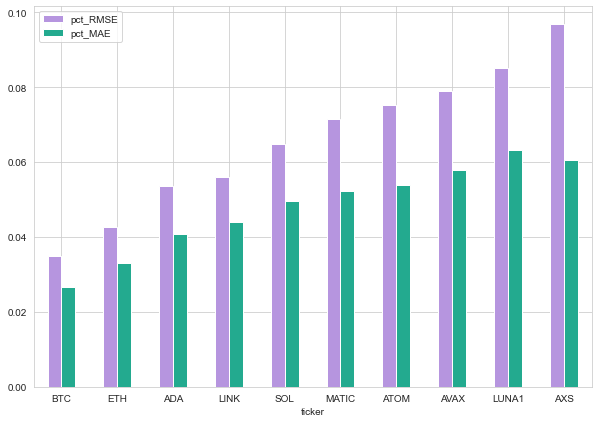

In [199]:
lr_assess_.set_index('ticker')[['pct_RMSE','pct_MAE']].sort_values( 'pct_RMSE').plot.bar(figsize = (10,7),color = [color5,color4])
plt.xticks(rotation=0)

##### Assess Movements 'Accuracy'

In [200]:
lr_classif = assess_classification_2(lr_predictions.copy(),'Predictions_pct')

ADA
F1 Score: 0.4253731343283582
Precision: 0.4351145038167939
Recall: 0.41605839416058393
ATOM
F1 Score: 0.5333333333333333
Precision: 0.5161290322580645
Recall: 0.5517241379310345
AVAX
F1 Score: 0.4046692607003891
Precision: 0.5098039215686274
Recall: 0.33548387096774196
AXS
F1 Score: 0.555205047318612
Precision: 0.4656084656084656
Recall: 0.6875
BTC
F1 Score: 0.5622775800711743
Precision: 0.572463768115942
Recall: 0.5524475524475524
ETH
F1 Score: 0.5052631578947367
Precision: 0.5179856115107914
Recall: 0.4931506849315068
LINK
F1 Score: 0.44357976653696496
Precision: 0.5277777777777778
Recall: 0.3825503355704698
LUNA1
F1 Score: 0.4444444444444445
Precision: 0.5
Recall: 0.4
MATIC
F1 Score: 0.28865979381443296
Precision: 0.5185185185185185
Recall: 0.2
SOL
F1 Score: 0.5
Precision: 0.4695121951219512
Recall: 0.5347222222222222


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'BTC'),
  Text(1, 0, 'LINK'),
  Text(2, 0, 'MATIC'),
  Text(3, 0, 'ETH'),
  Text(4, 0, 'ATOM'),
  Text(5, 0, 'AVAX'),
  Text(6, 0, 'LUNA1'),
  Text(7, 0, 'SOL'),
  Text(8, 0, 'AXS'),
  Text(9, 0, 'ADA')])

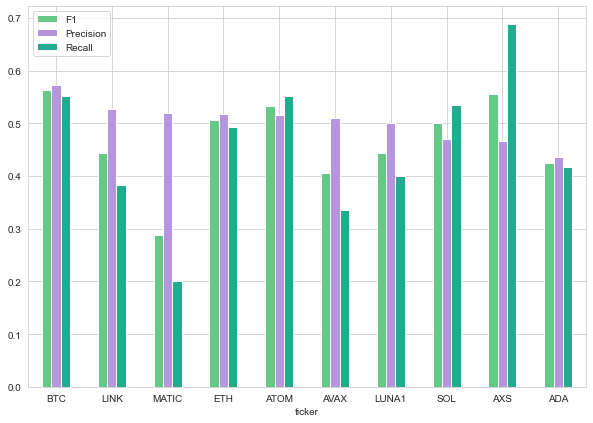

In [201]:
lr_classif.set_index('ticker').sort_values('Precision',ascending=False,).plot.bar(figsize = (10,7),color = [color3,color5,color4])
plt.xticks(rotation=0)

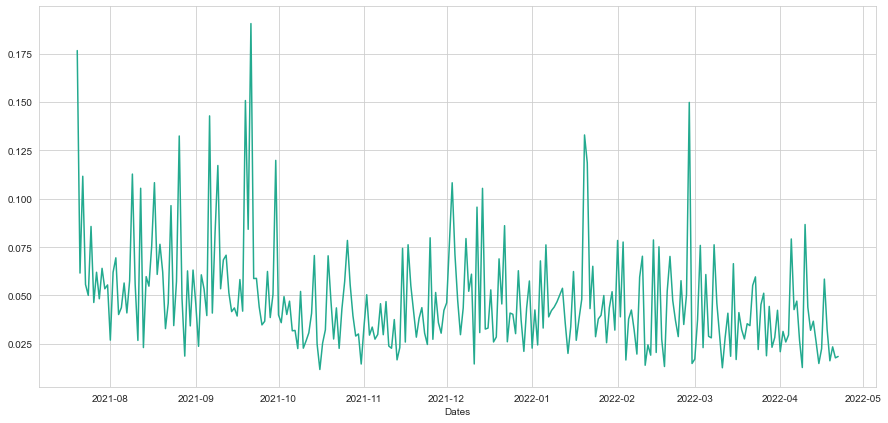

In [202]:
error_analysis = pd.DataFrame()
error_analysis['Dates'] = lr_full_assess['start_date'].unique()
#error_analysis['Year_Mon'] = str(error_analysis['Dates'].dt.year) + '_' + str(error_analysis['Dates'].dt.month)
error_analysis['RMSE'] = lr_full_assess.groupby('start_date')['pct_RMSE_test'].mean().values
error_analysis = error_analysis.set_index('Dates')
ax = error_analysis['RMSE'].plot(figsize = (15,7),color=color4)
# y0,y1 = ax.get_ylim()
# offset = teste_model['scores']['RMSE_test'].max()
# new_max = (offset - y0) / (y1 - y0)




In [203]:
lr_full_assess.groupby('ticker')['RMSE_test'].mean()

ticker
ADA         0.077184
ATOM        1.467231
AVAX        3.314307
AXS         5.256224
BTC      1318.743375
ETH       109.918552
LINK        1.138874
LUNA1       2.286581
MATIC       0.090069
SOL         6.043863
Name: RMSE_test, dtype: float64

### LGB 

__Final Parameters:__  
__boosting_type:__ Dart   
__max_depth:__ 4   
__learning_rate__: 0.01  


In [204]:
lgb_model ,lgb_assess,lgb_full_assess,lgb_pred = model_assess(x_train_pct,y_train_pct, \
                                                     lgb.LGBMRegressor(boosting_type='dart',max_depth=4, \
                                                                       learning_rate=0.01,random_state=0) \
                                                     ,pct_final_subset,200,1)


ADA:
Cross Validation Scores:
Model : LGBMRegressor(boosting_type='dart', learning_rate=0.01, max_depth=4,
              random_state=0)
 
Avg Train R2: 0.949
Avg Test R2: nan
 
Avg Train MAE: 0.068
Avg Test MAE: 0.07
 
Avg Train RMSE: 0.1
Avg Test RMSE: 0.07
 
The CV lasted:, 15.503266096115112 seconds
0.0698231046931408
 
ATOM:
Cross Validation Scores:
Model : LGBMRegressor(boosting_type='dart', learning_rate=0.01, max_depth=4,
              random_state=0)
 
Avg Train R2: 0.934
Avg Test R2: nan
 
Avg Train MAE: 1.14
Avg Test MAE: 1.334
 
Avg Train RMSE: 1.71
Avg Test RMSE: 1.334
 
The CV lasted:, 14.759154558181763 seconds
1.334155234657039
 
AVAX:
Cross Validation Scores:
Model : LGBMRegressor(boosting_type='dart', learning_rate=0.01, max_depth=4,
              random_state=0)
 
Avg Train R2: 0.948
Avg Test R2: nan
 
Avg Train MAE: 2.014
Avg Test MAE: 3.021
 
Avg Train RMSE: 3.227
Avg Test RMSE: 3.021
 
The CV lasted:, 14.595572471618652 seconds
3.020913357400721
 
AXS:
Cross Valid

In [205]:
lgb_assess_ = gen_val_assess(lgb_pred,'LGB')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'BTC'),
  Text(1, 0, 'ETH'),
  Text(2, 0, 'ADA'),
  Text(3, 0, 'LINK'),
  Text(4, 0, 'SOL'),
  Text(5, 0, 'MATIC'),
  Text(6, 0, 'ATOM'),
  Text(7, 0, 'AVAX'),
  Text(8, 0, 'LUNA1'),
  Text(9, 0, 'AXS')])

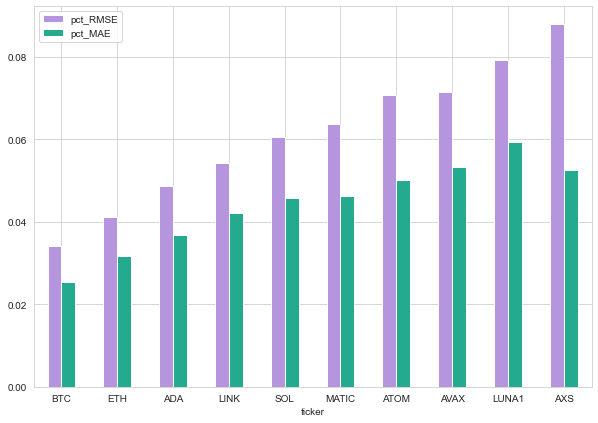

In [206]:
lgb_assess_.set_index('ticker')[['pct_RMSE','pct_MAE']].sort_values( 'pct_RMSE').plot.bar(figsize = (10,7),color = [color5,color4])
plt.xticks(rotation=0)

##### Assess Movements 'Accuracy'

In [207]:
lgb_classif = assess_classification_2(lgb_pred,'Predictions_pct')

ADA
F1 Score: 0.5073529411764705
Precision: 0.5111111111111111
Recall: 0.5036496350364964
ATOM
F1 Score: 0.6168831168831168
Precision: 0.5828220858895705
Recall: 0.6551724137931034
AVAX
F1 Score: 0.5784615384615385
Precision: 0.5529411764705883
Recall: 0.6064516129032258
AXS
F1 Score: 0.5802816901408451
Precision: 0.45374449339207046
Recall: 0.8046875
BTC
F1 Score: 0.5259515570934254
Precision: 0.5205479452054794
Recall: 0.5314685314685315
ETH
F1 Score: 0.5379746835443039
Precision: 0.5
Recall: 0.5821917808219178
LINK
F1 Score: 0.5527950310559006
Precision: 0.5144508670520231
Recall: 0.5973154362416108
LUNA1
F1 Score: 0.5861027190332326
Precision: 0.521505376344086
Recall: 0.6689655172413793
MATIC
F1 Score: 0.427536231884058
Precision: 0.4338235294117647
Recall: 0.42142857142857143
SOL
F1 Score: 0.6514285714285714
Precision: 0.5533980582524272
Recall: 0.7916666666666666


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ATOM'),
  Text(1, 0, 'SOL'),
  Text(2, 0, 'AVAX'),
  Text(3, 0, 'LUNA1'),
  Text(4, 0, 'BTC'),
  Text(5, 0, 'LINK'),
  Text(6, 0, 'ADA'),
  Text(7, 0, 'ETH'),
  Text(8, 0, 'AXS'),
  Text(9, 0, 'MATIC')])

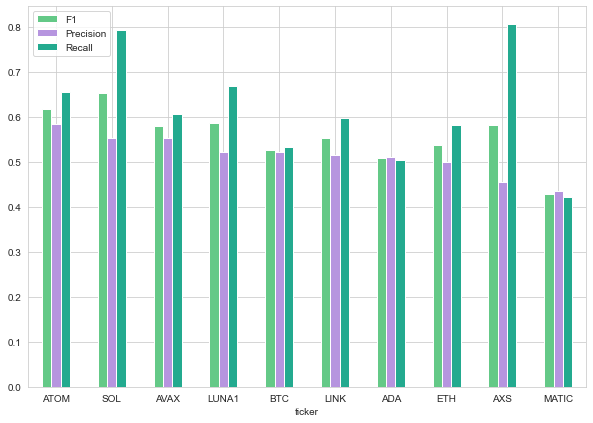

In [208]:
lgb_classif.set_index('ticker').sort_values('Precision',ascending=False,).plot.bar(figsize = (10,7),color = [color3,color5,color4])
plt.xticks(rotation=0)

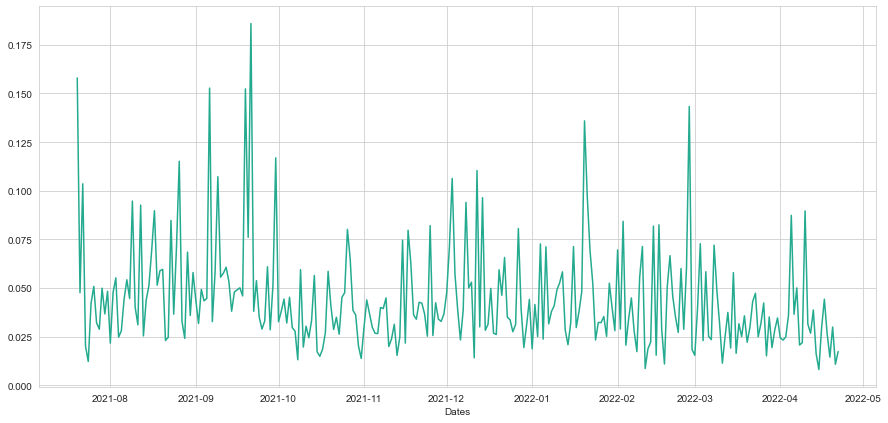

In [209]:
error_analysis = pd.DataFrame()
error_analysis['Dates'] = lgb_full_assess['start_date'].unique()
#error_analysis['Year_Mon'] = str(error_analysis['Dates'].dt.year) + '_' + str(error_analysis['Dates'].dt.month)
error_analysis['RMSE'] = lgb_full_assess.groupby('start_date')['pct_RMSE_test'].mean().values
error_analysis = error_analysis.set_index('Dates')
ax = error_analysis['RMSE'].plot(figsize = (15,7),color= color4)
# y0,y1 = ax.get_ylim()
# offset = teste_model['scores']['RMSE_test'].max()
# new_max = (offset - y0) / (y1 - y0)




### RF

__Final Parameters:__  
__min_samples_split:__ 2   
__max_depth:__ 4 
__min_impurity_decrease__: 0.02  
__n_estimators:__ 180    
__bootstrap:__ False (because it's a time series)

In [210]:
rf_model ,rf_assess,rf_full_assess,rf_pred = model_assess(x_train_pct,y_train_pct, \
             RandomForestRegressor(random_state=0, min_samples_split=2,max_depth=4,max_features='auto',min_impurity_decrease=0.02, \
                                   n_estimators=180, bootstrap=False,warm_start=True),pct_final_subset,200,1)

ADA:
Cross Validation Scores:
Model : RandomForestRegressor(bootstrap=False, max_depth=4, min_impurity_decrease=0.02,
                      n_estimators=180, random_state=0, warm_start=True)
 
Avg Train R2: 0.942
Avg Test R2: nan
 
Avg Train MAE: 0.073
Avg Test MAE: 0.071
 
Avg Train RMSE: 0.107
Avg Test RMSE: 0.071
 
The CV lasted:, 10.664987802505493 seconds
0.07097472924187725
 
ATOM:
Cross Validation Scores:
Model : RandomForestRegressor(bootstrap=False, max_depth=4, min_impurity_decrease=0.02,
                      n_estimators=180, random_state=0, warm_start=True)
 
Avg Train R2: 0.926
Avg Test R2: nan
 
Avg Train MAE: 1.214
Avg Test MAE: 1.35
 
Avg Train RMSE: 1.811
Avg Test RMSE: 1.35
 
The CV lasted:, 9.907219648361206 seconds
1.3497003610108302
 
AVAX:
Cross Validation Scores:
Model : RandomForestRegressor(bootstrap=False, max_depth=4, min_impurity_decrease=0.02,
                      n_estimators=180, random_state=0, warm_start=True)
 
Avg Train R2: 0.943
Avg Test R2: nan
 


In [211]:
rf_assess_ = gen_val_assess(rf_pred,'RF')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'BTC'),
  Text(1, 0, 'ETH'),
  Text(2, 0, 'ADA'),
  Text(3, 0, 'LINK'),
  Text(4, 0, 'SOL'),
  Text(5, 0, 'MATIC'),
  Text(6, 0, 'ATOM'),
  Text(7, 0, 'AVAX'),
  Text(8, 0, 'LUNA1'),
  Text(9, 0, 'AXS')])

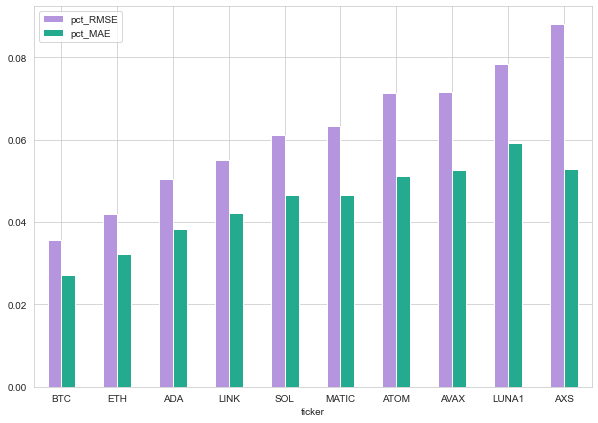

In [212]:
rf_assess_.set_index('ticker')[['pct_RMSE','pct_MAE']].sort_values( 'pct_RMSE').plot.bar(figsize = (10,7),color = [color5,color4])
plt.xticks(rotation=0)

##### Assess Movements 'Accuracy'

In [213]:
rf_classif = assess_classification_2(rf_pred,'Predictions_pct')

ADA
F1 Score: 0.6618357487922706
Precision: 0.49458483754512633
Recall: 1.0
ATOM
F1 Score: 0.6872037914691944
Precision: 0.5234657039711191
Recall: 1.0
AVAX
F1 Score: 0.7175925925925926
Precision: 0.5595667870036101
Recall: 1.0
AXS
F1 Score: 0.6320987654320989
Precision: 0.4620938628158845
Recall: 1.0
BTC
F1 Score: 0.680952380952381
Precision: 0.516245487364621
Recall: 1.0
ETH
F1 Score: 0.690307328605201
Precision: 0.5270758122743683
Recall: 1.0
LINK
F1 Score: 0.6995305164319248
Precision: 0.5379061371841155
Recall: 1.0
LUNA1
F1 Score: 0.6872037914691944
Precision: 0.5234657039711191
Recall: 1.0
MATIC
F1 Score: 0.671462829736211
Precision: 0.5054151624548736
Recall: 1.0
SOL
F1 Score: 0.6840855106888362
Precision: 0.51985559566787
Recall: 1.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'AVAX'),
  Text(1, 0, 'LINK'),
  Text(2, 0, 'ETH'),
  Text(3, 0, 'ATOM'),
  Text(4, 0, 'LUNA1'),
  Text(5, 0, 'SOL'),
  Text(6, 0, 'BTC'),
  Text(7, 0, 'MATIC'),
  Text(8, 0, 'ADA'),
  Text(9, 0, 'AXS')])

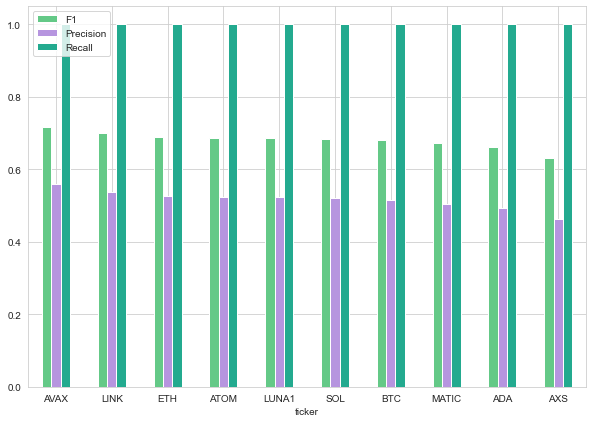

In [214]:
rf_classif.set_index('ticker').sort_values('Precision',ascending=False,).plot.bar(figsize = (10,7),color = [color3,color5,color4])
plt.xticks(rotation=0)

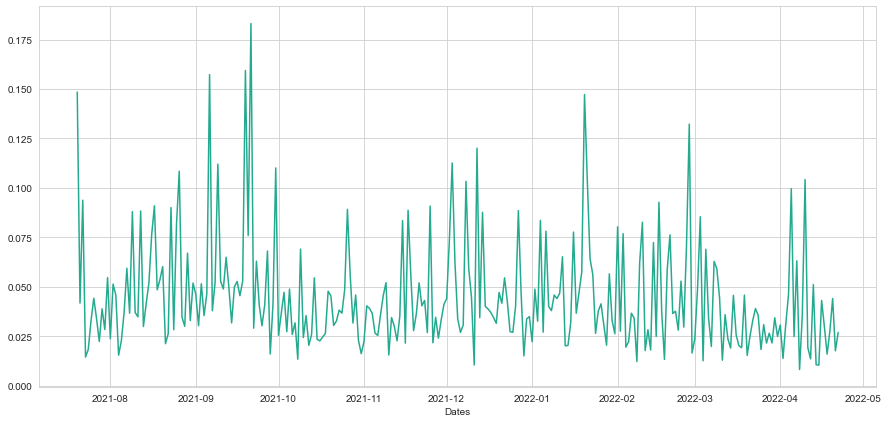

In [215]:
error_analysis = pd.DataFrame()
error_analysis['Dates'] = rf_full_assess['start_date'].unique()

error_analysis['RMSE'] = rf_full_assess.groupby('start_date')['pct_RMSE_test'].mean().values
error_analysis = error_analysis.set_index('Dates')
ax = error_analysis['RMSE'].plot(figsize = (15,7),color= color4)





### MLP

In [216]:
mlp_model ,mlp_assess,mlp_full_assess,mlp_pred = model_assess(x_train_pct,y_train_pct, \
             MLPRegressor(random_state=0),pct_final_subset,200,1)

ADA:
Cross Validation Scores:
Model : MLPRegressor(random_state=0)
 
Avg Train R2: -2567.615
Avg Test R2: nan
 
Avg Train MAE: 18.507
Avg Test MAE: 23.566
 
Avg Train RMSE: 22.88
Avg Test RMSE: 23.566
 
The CV lasted:, 8.127197504043579 seconds
23.56602888086642
 
ATOM:
Cross Validation Scores:
Model : MLPRegressor(random_state=0)
 
Avg Train R2: -6.759
Avg Test R2: nan
 
Avg Train MAE: 13.209
Avg Test MAE: 25.2
 
Avg Train RMSE: 17.969
Avg Test RMSE: 25.2
 
The CV lasted:, 51.80510640144348 seconds
25.199971119133572
 
AVAX:
Cross Validation Scores:
Model : MLPRegressor(random_state=0)
 
Avg Train R2: -4.917
Avg Test R2: nan
 
Avg Train MAE: 24.896
Avg Test MAE: 68.301
 
Avg Train RMSE: 37.047
Avg Test RMSE: 68.301
 
The CV lasted:, 52.45611310005188 seconds
68.30123826714804
 
AXS:
Cross Validation Scores:
Model : MLPRegressor(random_state=0)
 
Avg Train R2: -1.736
Avg Test R2: nan
 
Avg Train MAE: 22.25
Avg Test MAE: 101.763
 
Avg Train RMSE: 37.789
Avg Test RMSE: 101.763
 
The CV l

In [217]:
mlp_assess_ = gen_val_assess(mlp_pred,'MLP')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MATIC'),
  Text(1, 0, 'LUNA1'),
  Text(2, 0, 'ATOM'),
  Text(3, 0, 'SOL'),
  Text(4, 0, 'AVAX'),
  Text(5, 0, 'AXS'),
  Text(6, 0, 'ADA'),
  Text(7, 0, 'LINK'),
  Text(8, 0, 'ETH'),
  Text(9, 0, 'BTC')])

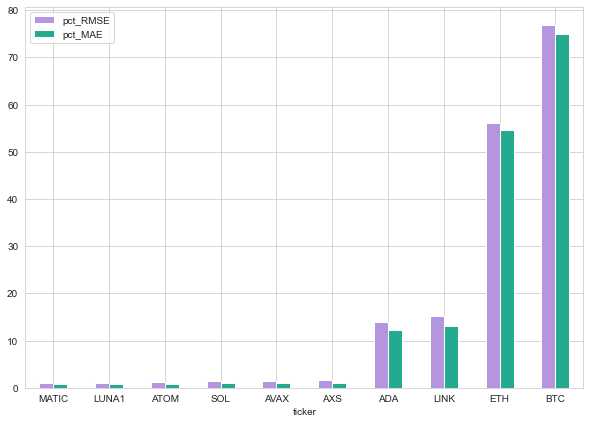

In [218]:
mlp_assess_.set_index('ticker')[['pct_RMSE','pct_MAE']].sort_values( 'pct_RMSE').plot.bar(figsize = (10,7),color = [color5,color4])
plt.xticks(rotation=0)

##### Assess Movements 'Accuracy'

In [219]:
mlp_classif = assess_classification_2(mlp_pred,'Predictions_pct')

ADA
F1 Score: 0.4260869565217391
Precision: 0.5268817204301075
Recall: 0.35766423357664234
ATOM
F1 Score: 0.6012658227848101
Precision: 0.5555555555555556
Recall: 0.6551724137931034
AVAX
F1 Score: 0.5800604229607251
Precision: 0.5454545454545454
Recall: 0.6193548387096774
AXS
F1 Score: 0.4668989547038328
Precision: 0.42138364779874216
Recall: 0.5234375
BTC
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
ETH
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
LINK
F1 Score: 0.4033613445378151
Precision: 0.5393258426966292
Recall: 0.3221476510067114
LUNA1
F1 Score: 0.5932721712538226
Precision: 0.532967032967033
Recall: 0.6689655172413793
MATIC
F1 Score: 0.6295264623955432
Precision: 0.5159817351598174
Recall: 0.8071428571428572
SOL
F1 Score: 0.5808580858085809
Precision: 0.5534591194968553
Recall: 0.6111111111111112


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ATOM'),
  Text(1, 0, 'SOL'),
  Text(2, 0, 'AVAX'),
  Text(3, 0, 'LINK'),
  Text(4, 0, 'LUNA1'),
  Text(5, 0, 'ADA'),
  Text(6, 0, 'MATIC'),
  Text(7, 0, 'AXS'),
  Text(8, 0, 'BTC'),
  Text(9, 0, 'ETH')])

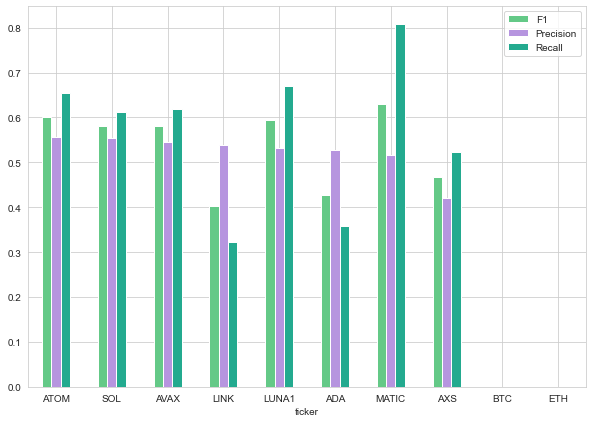

In [220]:
mlp_classif.set_index('ticker').sort_values('Precision',ascending=False,).plot.bar(figsize = (10,7),color = [color3,color5,color4])
plt.xticks(rotation=0)

Text(0, 0.5, 'Avg % error per day')

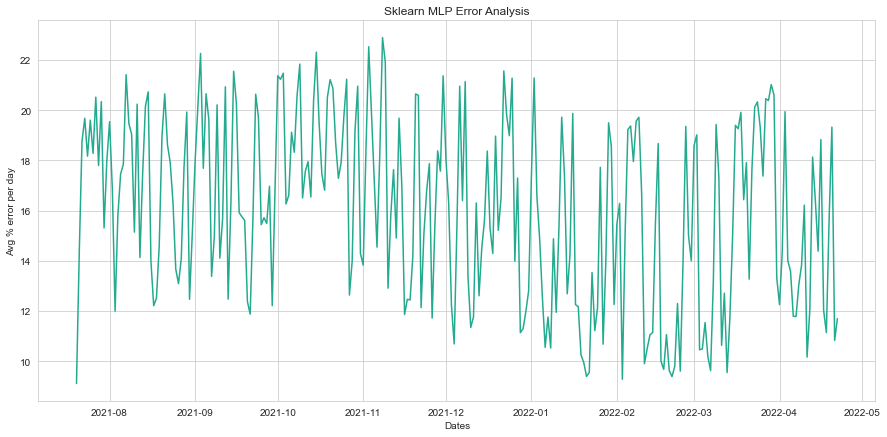

In [250]:
error_analysis = pd.DataFrame()
error_analysis['Dates'] = mlp_full_assess['start_date'].unique()
#error_analysis['Year_Mon'] = str(error_analysis['Dates'].dt.year) + '_' + str(error_analysis['Dates'].dt.month)
error_analysis['RMSE'] = mlp_full_assess.groupby('start_date')['pct_RMSE_test'].mean().values
error_analysis = error_analysis.set_index('Dates')
ax = error_analysis['RMSE'].plot(figsize = (15,7),color= color4)
plt.title('Sklearn MLP Error Analysis')
plt.ylabel('Avg % error per day')
# y0,y1 = ax.get_ylim()
# offset = teste_model['scores']['RMSE_test'].max()
# new_max = (offset - y0) / (y1 - y0)




### GRU NN

__Note:__ The optimization of the neural network will be performed without CV because of running time

__Final Parameters:__  
__Epochs:__ 1   
__Units:__ 32  
__Batch Size__: 50   
__Optimizer:__ RMSprop    
__Activation:__ Relu

In [303]:
pred_dict = {}
for i in tickers[:]:
    train_x = x_train_pct.loc[x_train_pct.index.get_level_values(0)==f'{i}']
    train_y = y_train_pct.loc[y_train_pct.index.get_level_values(0)==f'{i}']
    t_true = train_true.loc[train_true.index.isin(btc_y.index)]
    
    returns,split_df,model_dict,predictions,history_dict = TS_Kfold_regression_adjusted_gru(train_x,train_y,t_true \
                                                                                             ,'date',200,3, \
                                                                                             pct_final_subset,'ticker',1,50,32 \
                                                                                             ,optimizer='RMSprop' \
                                                                                             ,activation='relu')
    pred_dict[f'{i}'] = history_dict
    


ADA
(199, 1, 10)
4/4 [==============================] - 3s 147ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0729 - val_loss: 7.8307e-04 - val_mean_squared_error: 7.8307e-04 - val_mean_absolute_error: 0.0237
Test RMSE: 0.01025278821503428
Test MAE: 0.01025278821503428
ADA
(199, 1, 10)
4/4 [==============================] - 3s 160ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0690 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0334
Test RMSE: 0.01239802574089821
Test MAE: 0.01239802574089821
ADA
(199, 1, 10)
4/4 [==============================] - 3s 149ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0741 - val_loss: 5.9671e-04 - val_mean_squared_error: 5.9671e-04 - val_mean_absolute_error: 0.0235
Test RMSE: 0.03848717750416797
Test MAE: 0.03848717750416797
ADA
(199, 1, 10)
4/4 [==============================] - 3s 152ms/step - loss: 0.0085 - mean_squared_error: 0.00

4/4 [==============================] - 3s 149ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0602 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0304
Test RMSE: 0.043007533281879784
Test MAE: 0.043007533281879784
ADA
(199, 1, 10)
4/4 [==============================] - 3s 153ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0570 - val_loss: 1.2723e-04 - val_mean_squared_error: 1.2723e-04 - val_mean_absolute_error: 0.0108
Test RMSE: 0.030845639375888467
Test MAE: 0.030845639375888467
ADA
(199, 1, 10)
4/4 [==============================] - 4s 647ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0584 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0322
Test RMSE: 0.04800666370550788
Test MAE: 0.04800666370550788
ADA
(199, 1, 10)
4/4 [==============================] - 3s 149ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_er

4/4 [==============================] - 3s 149ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0573
Test RMSE: 0.043844407636657756
Test MAE: 0.043844407636657756
ADA
(199, 1, 10)
4/4 [==============================] - 3s 171ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0485 - val_loss: 9.8822e-04 - val_mean_squared_error: 9.8822e-04 - val_mean_absolute_error: 0.0276
Test RMSE: 0.014935640884637724
Test MAE: 0.014935640884637724
ADA
(199, 1, 10)
4/4 [==============================] - 3s 151ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0483 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0624
Test RMSE: 0.11016856875495673
Test MAE: 0.11016856875495673
ADA
(199, 1, 10)
4/4 [==============================] - 3s 154ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_er

4/4 [==============================] - 3s 153ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0495 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0329
Test RMSE: 0.010428016122830286
Test MAE: 0.010428016122830286
ADA
(199, 1, 10)
4/4 [==============================] - 3s 160ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0467 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0465
Test RMSE: 0.06841822529877373
Test MAE: 0.06841822529877373
ADA
(199, 1, 10)
4/4 [==============================] - 3s 157ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0454 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0525
Test RMSE: 0.10074294527560324
Test MAE: 0.10074294527560324
ADA
(199, 1, 10)
4/4 [==============================] - 3s 150ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.043

Test RMSE: 4.180368712893184
Test MAE: 4.180368712893184
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 149ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0697 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1615
Test RMSE: 10.365236156393827
Test MAE: 10.365236156393827
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 157ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0722 - val_loss: 9.0782e-04 - val_mean_squared_error: 9.0782e-04 - val_mean_absolute_error: 0.0284
Test RMSE: 1.536278217088089
Test MAE: 1.536278217088089
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 150ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0726 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0329
Test RMSE: 0.4023011272080481
Test MAE: 0.4023011272080481
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 154ms/s

Test RMSE: 0.46362297570252764
Test MAE: 0.46362297570252764
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 157ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0666 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0593
Test RMSE: 2.6471997867146797
Test MAE: 2.6471997867146797
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 147ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0670 - val_loss: 4.7771e-04 - val_mean_squared_error: 4.7771e-04 - val_mean_absolute_error: 0.0192
Test RMSE: 0.66154498741653
Test MAE: 0.66154498741653
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 150ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0694 - val_loss: 5.7120e-04 - val_mean_squared_error: 5.7120e-04 - val_mean_absolute_error: 0.0227
Test RMSE: 0.6974817324111342
Test MAE: 0.6974817324111342
ATOM
(199, 1, 10)
4/4 [==============================] - 

4/4 [==============================] - 3s 163ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0670 - val_loss: 8.3293e-04 - val_mean_squared_error: 8.3293e-04 - val_mean_absolute_error: 0.0288
Test RMSE: 0.867151411303837
Test MAE: 0.867151411303837
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 162ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0661 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0390
Test RMSE: 2.160228304129724
Test MAE: 2.160228304129724
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 154ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0668 - val_loss: 8.5176e-04 - val_mean_squared_error: 8.5176e-04 - val_mean_absolute_error: 0.0263
Test RMSE: 1.059955268372768
Test MAE: 1.059955268372768
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 161ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 

4/4 [==============================] - 3s 156ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0837 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1245
Test RMSE: 9.798605809387823
Test MAE: 9.798605809387823
AVAX
(199, 1, 10)
4/4 [==============================] - 3s 155ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0800 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0455
Test RMSE: 4.220575053643088
Test MAE: 4.220575053643088
AVAX
(199, 1, 10)
4/4 [==============================] - 3s 162ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0788 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0869
Test RMSE: 5.403035668559234
Test MAE: 5.403035668559234
AVAX
(199, 1, 10)
4/4 [==============================] - 4s 673ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0778 - val_los

4/4 [==============================] - 3s 155ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0706 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0504
Test RMSE: 8.592329862535252
Test MAE: 8.592329862535252
AVAX
(199, 1, 10)
4/4 [==============================] - 3s 158ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0699 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0888
Test RMSE: 3.8154562556475042
Test MAE: 3.8154562556475042
AVAX
(199, 1, 10)
4/4 [==============================] - 3s 156ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0727 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0351
Test RMSE: 4.261554215212513
Test MAE: 4.261554215212513
AVAX
(199, 1, 10)
4/4 [==============================] - 3s 149ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0745 - val_l

4/4 [==============================] - 3s 155ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1044 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0891
Test RMSE: 1.6016531968810952
Test MAE: 1.6016531968810952
AXS
(199, 1, 10)
4/4 [==============================] - 3s 162ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1101 - val_loss: 8.9599e-04 - val_mean_squared_error: 8.9599e-04 - val_mean_absolute_error: 0.0299
Test RMSE: 1.2168096056890008
Test MAE: 1.2168096056890008
AXS
(199, 1, 10)
4/4 [==============================] - 3s 153ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1070 - val_loss: 0.1205 - val_mean_squared_error: 0.1205 - val_mean_absolute_error: 0.2615
Test RMSE: 1.405392833191918
Test MAE: 1.405392833191918
AXS
(199, 1, 10)
4/4 [==============================] - 3s 157ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1134 

4/4 [==============================] - 3s 160ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0719 - val_loss: 3.1789e-05 - val_mean_squared_error: 3.1789e-05 - val_mean_absolute_error: 0.0049
Test RMSE: 0.5868844776194067
Test MAE: 0.5868844776194067
AXS
(199, 1, 10)
4/4 [==============================] - 3s 156ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0724 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1555
Test RMSE: 11.145070500054985
Test MAE: 11.145070500054985
AXS
(199, 1, 10)
4/4 [==============================] - 3s 154ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0695 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0326
Test RMSE: 3.0427731990819282
Test MAE: 3.0427731990819282
AXS
(199, 1, 10)
4/4 [==============================] - 3s 162ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.065

4/4 [==============================] - 3s 166ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0461 - val_loss: 1.0789e-04 - val_mean_squared_error: 1.0789e-04 - val_mean_absolute_error: 0.0103
Test RMSE: 430.33008121386956
Test MAE: 430.33008121386956
BTC
(199, 1, 10)
4/4 [==============================] - 3s 161ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0781
Test RMSE: 3165.4178085588064
Test MAE: 3165.4178085588064
BTC
(199, 1, 10)
4/4 [==============================] - 3s 161ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0484 - val_loss: 1.6950e-04 - val_mean_squared_error: 1.6950e-04 - val_mean_absolute_error: 0.0127
Test RMSE: 544.2479981946017
Test MAE: 544.2479981946017
BTC
(199, 1, 10)
4/4 [==============================] - 5s 159ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error:

4/4 [==============================] - 3s 140ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 3.1690e-04 - val_mean_squared_error: 3.1690e-04 - val_mean_absolute_error: 0.0149
Test RMSE: 1030.1345726548461
Test MAE: 1030.1345726548461
BTC
(199, 1, 10)
4/4 [==============================] - 3s 144ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 2.5317e-04 - val_mean_squared_error: 2.5317e-04 - val_mean_absolute_error: 0.0144
Test RMSE: 869.1708888719004
Test MAE: 869.1708888719004
BTC
(199, 1, 10)
4/4 [==============================] - 3s 145ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0405 - val_loss: 5.0862e-04 - val_mean_squared_error: 5.0862e-04 - val_mean_absolute_error: 0.0225
Test RMSE: 1032.8098691426567
Test MAE: 1032.8098691426567
BTC
(199, 1, 10)
4/4 [==============================] - 3s 153ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolut

4/4 [==============================] - 3s 146ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0584 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0363
Test RMSE: 50.6605728717941
Test MAE: 50.6605728717941
ETH
(199, 1, 10)
4/4 [==============================] - 3s 141ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0598 - val_loss: 8.6820e-04 - val_mean_squared_error: 8.6820e-04 - val_mean_absolute_error: 0.0253
Test RMSE: 32.848928089377296
Test MAE: 32.848928089377296
ETH
(199, 1, 10)
4/4 [==============================] - 3s 144ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0538 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0292
Test RMSE: 36.01774755826045
Test MAE: 36.01774755826045
ETH
(199, 1, 10)
4/4 [==============================] - 3s 146ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0545 - va

4/4 [==============================] - 3s 139ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0432 - val_loss: 9.1939e-04 - val_mean_squared_error: 9.1939e-04 - val_mean_absolute_error: 0.0303
Test RMSE: 84.21956282246992
Test MAE: 84.21956282246992
ETH
(199, 1, 10)
4/4 [==============================] - 3s 144ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0429 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0313
Test RMSE: 32.83642797744551
Test MAE: 32.83642797744551
ETH
(199, 1, 10)
4/4 [==============================] - 3s 142ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0440 - val_loss: 2.9645e-04 - val_mean_squared_error: 2.9645e-04 - val_mean_absolute_error: 0.0144
Test RMSE: 69.61120707774535
Test MAE: 69.61120707774535
ETH
(199, 1, 10)
4/4 [==============================] - 3s 141ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0

4/4 [==============================] - 3s 145ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0684 - val_loss: 8.6973e-04 - val_mean_squared_error: 8.6973e-04 - val_mean_absolute_error: 0.0266
Test RMSE: 1.0693757732533236
Test MAE: 1.0693757732533236
LINK
(199, 1, 10)
4/4 [==============================] - 3s 137ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0654 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0357
Test RMSE: 0.35520385858412595
Test MAE: 0.35520385858412595
LINK
(199, 1, 10)
4/4 [==============================] - 3s 142ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0670 - val_loss: 2.4855e-04 - val_mean_squared_error: 2.4855e-04 - val_mean_absolute_error: 0.0155
Test RMSE: 0.36532968031239577
Test MAE: 0.36532968031239577
LINK
(199, 1, 10)
4/4 [==============================] - 3s 139ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolu

4/4 [==============================] - 3s 149ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0682 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0493
Test RMSE: 1.0759327250301425
Test MAE: 1.0759327250301425
LINK
(199, 1, 10)
4/4 [==============================] - 3s 143ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0680 - val_loss: 3.0056e-04 - val_mean_squared_error: 3.0056e-04 - val_mean_absolute_error: 0.0170
Test RMSE: 0.6945383531249121
Test MAE: 0.6945383531249121
LINK
(199, 1, 10)
4/4 [==============================] - 3s 140ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0659 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0281
Test RMSE: 0.28838104936885145
Test MAE: 0.28838104936885145
LINK
(199, 1, 10)
4/4 [==============================] - 4s 147ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 

LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 142ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0890 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0986
Test RMSE: 0.5882030039183057
Test MAE: 0.5882030039183057
LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 143ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.0911 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0304
Test RMSE: 0.029014305537339524
Test MAE: 0.029014305537339524
LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 141ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0887 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0987
Test RMSE: 1.6637899420790632
Test MAE: 1.6637899420790632
LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 142ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_

4/4 [==============================] - 3s 138ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0696 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0745
Test RMSE: 0.7314115367166494
Test MAE: 0.7314115367166494
LUNA1
(199, 1, 10)
4/4 [==============================] - 4s 599ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0668 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0945
Test RMSE: 6.70104980266504
Test MAE: 6.70104980266504
LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 141ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0688 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0807
Test RMSE: 7.320925300396652
Test MAE: 7.320925300396652
LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 138ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0731 - val_

Test RMSE: 0.050420665887244365
Test MAE: 0.050420665887244365
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 170ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0832 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1316
Test RMSE: 0.21457602744517335
Test MAE: 0.21457602744517335
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 139ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0852 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0644
Test RMSE: 0.05558258021834006
Test MAE: 0.05558258021834006
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 138ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0815 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0352
Test RMSE: 0.015005958370973627
Test MAE: 0.015005958370973627
MATIC
(199, 1, 10)
4/4 [==============================] 

Test RMSE: 0.030298517010543424
Test MAE: 0.030298517010543424
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 145ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0639 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0757
Test RMSE: 0.2653106416076796
Test MAE: 0.2653106416076796
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 143ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0663 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0475
Test RMSE: 0.08807613280609106
Test MAE: 0.08807613280609106
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 140ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0670 - val_loss: 4.3152e-04 - val_mean_squared_error: 4.3152e-04 - val_mean_absolute_error: 0.0176
Test RMSE: 0.06393410290329982
Test MAE: 0.06393410290329982
MATIC
(199, 1, 10)
4/4 [============================

Test RMSE: 0.09241390225695412
Test MAE: 0.09241390225695412
MATIC
(199, 1, 10)
4/4 [==============================] - 4s 137ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0563 - val_loss: 4.3762e-04 - val_mean_squared_error: 4.3762e-04 - val_mean_absolute_error: 0.0180
Test RMSE: 0.01062605553845053
Test MAE: 0.01062605553845053
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 141ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0585 - val_loss: 5.0413e-04 - val_mean_squared_error: 5.0413e-04 - val_mean_absolute_error: 0.0182
Test RMSE: 0.04726502134116095
Test MAE: 0.04726502134116095
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 142ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0595 - val_loss: 9.4409e-04 - val_mean_squared_error: 9.4409e-04 - val_mean_absolute_error: 0.0246
Test RMSE: 0.06017187931958179
Test MAE: 0.06017187931958179
MATIC
(199, 1, 10)
4/4 [============

4/4 [==============================] - 3s 140ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0678 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0354
Test RMSE: 15.729389558514015
Test MAE: 15.729389558514015
SOL
(199, 1, 10)
4/4 [==============================] - 3s 139ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0712 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0530
Test RMSE: 16.31373760287181
Test MAE: 16.31373760287181
SOL
(199, 1, 10)
4/4 [==============================] - 3s 141ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0712 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0630
Test RMSE: 18.109341204709608
Test MAE: 18.109341204709608
SOL
(199, 1, 10)
4/4 [==============================] - 3s 160ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0733 - val_lo

In [349]:
# for i in pred_dict.keys():
#     pred_dict[f'{i}'].to_csv(f'{i}_GRU_CV.csv')

In [60]:
pred_dict = {}
for i in tickers:
    pred_dict[f'{i}'] = pd.read_csv(f'{i}_GRU_CV.csv')
    
for i in tickers:
    pred_dict[f'{i}']['date'] = pd.to_datetime(pred_dict[f'{i}']['date'])

In [61]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
pred_NN = {}
assess_nn = pd.DataFrame()
id_ = []
mse = []
mae = []
pct_mse = []
pct_mae = []
for i in tickers:
    target = x_train_pct.groupby('ticker')['close'].shift(-1).reset_index()
    pred_NN[f'{i}'] = pd.merge(pred_dict[f'{i}'].iloc[:,:-1].drop(columns='close').reset_index(), target,on = ['ticker','date']).drop(columns='Target').rename(columns = {'close':'Target'})
    id_.append(i)
    mse.append(mean_squared_error(pred_NN[f'{i}']['Target'], pred_NN[f'{i}']['Prediction']))
    mae.append(mean_absolute_error(pred_NN[f'{i}']['Target'], pred_NN[f'{i}']['Prediction']))
    pct_mse.append(mean_squared_error(pred_NN[f'{i}']['Target_pct'], pred_NN[f'{i}']['Prediction_pct']))
    pct_mae.append(mean_absolute_error(pred_NN[f'{i}']['Target_pct'], pred_NN[f'{i}']['Prediction_pct']))
    
    
assess_nn['ticker'] = id_
assess_nn['MAE'] = mae
assess_nn['RMSE'] = np.sqrt(mse)
assess_nn['pct_MAE'] = pct_mae
assess_nn['pct_RMSE'] = np.sqrt(pct_mse)
assess_nn['Model'] = 'GRU'

In [352]:
# for i in pred_NN.keys():
#     pred_NN[f'{i}'].to_csv(f'{i}_GRU_CV_transformed.csv')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'BTC'),
  Text(1, 0, 'ETH'),
  Text(2, 0, 'ADA'),
  Text(3, 0, 'LINK'),
  Text(4, 0, 'MATIC'),
  Text(5, 0, 'SOL'),
  Text(6, 0, 'AVAX'),
  Text(7, 0, 'ATOM'),
  Text(8, 0, 'LUNA1'),
  Text(9, 0, 'AXS')])

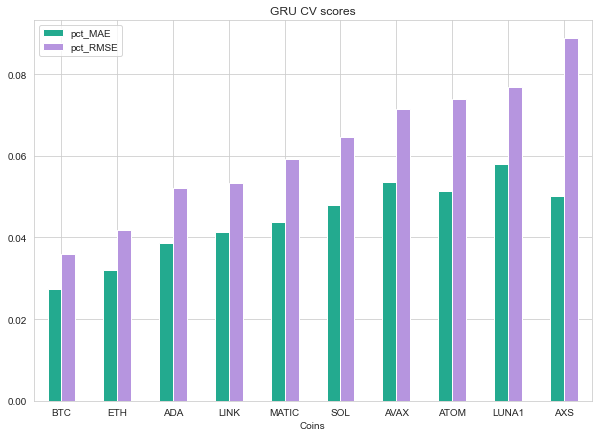

In [315]:
assess_nn.set_index('ticker').iloc[:,2:].sort_values('pct_RMSE').plot.bar(figsize=(10,7),color = [color4,color5])
plt.xlabel('Coins')
plt.title('GRU CV scores')
plt.xticks(rotation=0)

##### Assess Movements 'Accuracy'

In [63]:
gru_classif = assess_classification_2_1(pred_NN.copy(),'Prediction_pct')

ADA
F1 Score: 0.43786982248520706
Precision: 0.4457831325301205
Recall: 0.43023255813953487
ATOM
F1 Score: 0.4634146341463415
Precision: 0.5205479452054794
Recall: 0.4175824175824176
AVAX
F1 Score: 0.43870967741935485
Precision: 0.5862068965517241
Recall: 0.35051546391752575
AXS
F1 Score: 0.5142857142857143
Precision: 0.4787234042553192
Recall: 0.5555555555555556
BTC
F1 Score: 0.5524861878453038
Precision: 0.5747126436781609
Recall: 0.5319148936170213
ETH
F1 Score: 0.5333333333333333
Precision: 0.5783132530120482
Recall: 0.4948453608247423
LINK
F1 Score: 0.4099378881987578
Precision: 0.4583333333333333
Recall: 0.3707865168539326
LUNA1
F1 Score: 0.45348837209302323
Precision: 0.5064935064935064
Recall: 0.4105263157894737
MATIC
F1 Score: 0.4166666666666667
Precision: 0.4375
Recall: 0.3977272727272727
SOL
F1 Score: 0.46511627906976744
Precision: 0.4819277108433735
Recall: 0.449438202247191


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'AVAX'),
  Text(1, 0, 'ETH'),
  Text(2, 0, 'BTC'),
  Text(3, 0, 'ATOM'),
  Text(4, 0, 'LUNA1'),
  Text(5, 0, 'SOL'),
  Text(6, 0, 'AXS'),
  Text(7, 0, 'LINK'),
  Text(8, 0, 'ADA'),
  Text(9, 0, 'MATIC')])

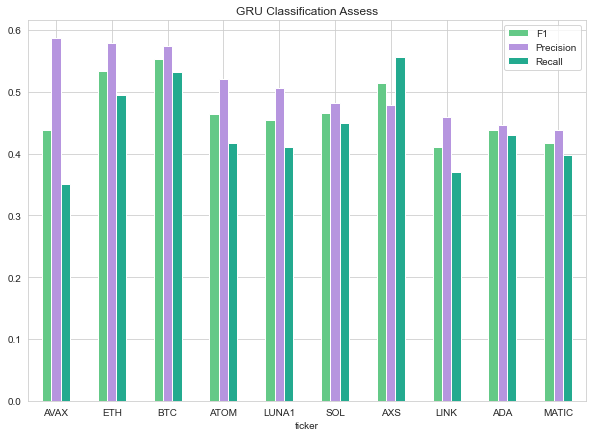

In [305]:
gru_classif.set_index('ticker').sort_values('Precision',ascending=False).plot.bar(figsize=(10,7),color = [color3,color5,color4])
plt.title('GRU Classification Assess')
plt.xticks(rotation=0)

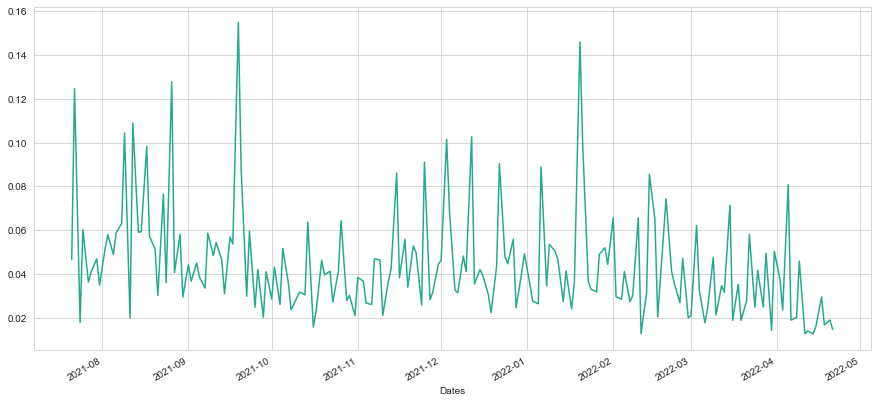

In [303]:
error_gru = pd.DataFrame()
for i in pred_NN.keys():
    error_gru = pd.concat([error_gru , pred_NN[f'{i}']],axis=0)
    
    
error_analysis = pd.DataFrame()
error_gru['Error'] = abs(error_gru['Prediction_pct']- error_gru['Target_pct'])
error_analysis['Dates'] = error_gru['date'].unique()
#error_analysis['Year_Mon'] = str(error_analysis['Dates'].dt.year) + '_' + str(error_analysis['Dates'].dt.month)
error_analysis['RMSE'] = error_gru.groupby('date')['Error'].mean().values
error_analysis = error_analysis.set_index('Dates')
ax = error_analysis['RMSE'].plot(figsize = (15,7),color = [color4])
# y0,y1 = ax.get_ylim()
# offset = teste_model['scores']['RMSE_test'].max()
# new_max = (offset - y0) / (y1 - y0)




### LSTM

In [564]:
pred_dict_LSTM = {}
for i in tickers[:]:
    train_x = x_train_pct.loc[x_train_pct.index.get_level_values(0)==f'{i}']
    train_y = y_train_pct.loc[y_train_pct.index.get_level_values(0)==f'{i}']
    t_true = train_true.loc[train_true.index.isin(train_y.index)]
    
    returns,split_df,model_dict,predictions,history_dict = TS_Kfold_regression_adjusted_lstm(train_x,train_y,t_true \
                                                                                             ,'date',200,3, \
                                                                                             pct_final_subset,'ticker',1,50,32 \
                                                                                             ,optimizer='RMSprop' \
                                                                                             ,activation='relu',lr=0.1)
    pred_dict_LSTM[f'{i}'] = history_dict
    


ADA
(199, 1, 10)
4/4 [==============================] - 2s 149ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0595 - val_loss: 1.3080e-04 - val_mean_squared_error: 1.3080e-04 - val_mean_absolute_error: 0.0112
Test RMSE: 0.010327123870775834
Test MAE: 0.010327123870775834
ADA
(199, 1, 10)
4/4 [==============================] - 2s 151ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0576 - val_loss: 2.9979e-04 - val_mean_squared_error: 2.9979e-04 - val_mean_absolute_error: 0.0164
Test RMSE: 0.013208201945220654
Test MAE: 0.013208201945220654
ADA
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0557 - val_loss: 8.6821e-06 - val_mean_squared_error: 8.6821e-06 - val_mean_absolute_error: 0.0029
Test RMSE: 0.003024843334335614
Test MAE: 0.003024843334335614
ADA
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0059 - mean_squar

Test RMSE: 0.03664588288770565
Test MAE: 0.03664588288770565
ADA
(199, 1, 10)
4/4 [==============================] - 2s 147ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0469 - val_loss: 1.4751e-04 - val_mean_squared_error: 1.4751e-04 - val_mean_absolute_error: 0.0121
Test RMSE: 0.023861960028906726
Test MAE: 0.023861960028906726
ADA
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0466 - val_loss: 1.3686e-04 - val_mean_squared_error: 1.3686e-04 - val_mean_absolute_error: 0.0115
Test RMSE: 0.020508525577046743
Test MAE: 0.020508525577046743
ADA
(199, 1, 10)
4/4 [==============================] - 2s 143ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0465 - val_loss: 8.2332e-04 - val_mean_squared_error: 8.2332e-04 - val_mean_absolute_error: 0.0286
Test RMSE: 0.06433608411552472
Test MAE: 0.06433608411552472
ADA
(199, 1, 10)
4/4 [================

Test RMSE: 0.050389168108384785
Test MAE: 0.050389168108384785
ADA
(199, 1, 10)
4/4 [==============================] - 2s 154ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0380 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0449
Test RMSE: 0.053283459626654484
Test MAE: 0.053283459626654484
ADA
(199, 1, 10)
4/4 [==============================] - 4s 151ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0378 - val_loss: 5.6353e-04 - val_mean_squared_error: 5.6353e-04 - val_mean_absolute_error: 0.0194
Test RMSE: 0.006699599615181739
Test MAE: 0.006699599615181739
ADA
(199, 1, 10)
4/4 [==============================] - 2s 153ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0370 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0788
Test RMSE: 0.13011090578662943
Test MAE: 0.13011090578662943
ADA
(199, 1, 10)
4/4 [==============================

Test RMSE: 0.02271677313073872
Test MAE: 0.02271677313073872
ADA
(199, 1, 10)
4/4 [==============================] - 2s 143ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0362 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0309
Test RMSE: 0.05782474998029152
Test MAE: 0.05782474998029152
ADA
(199, 1, 10)
4/4 [==============================] - 2s 148ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0361 - val_loss: 1.3503e-04 - val_mean_squared_error: 1.3503e-04 - val_mean_absolute_error: 0.0116
Test RMSE: 0.013271487819618955
Test MAE: 0.013271487819618955
ADA
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0361 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0724
Test RMSE: 0.13981252085071283
Test MAE: 0.13981252085071283
ADA
(199, 1, 10)
4/4 [==============================] - 

Test RMSE: 4.058970215284049
Test MAE: 4.058970215284049
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0610 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1849
Test RMSE: 11.483039321599982
Test MAE: 11.483039321599982
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 148ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0632 - val_loss: 3.0359e-04 - val_mean_squared_error: 3.0359e-04 - val_mean_absolute_error: 0.0140
Test RMSE: 0.9741278646951628
Test MAE: 0.9741278646951628
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 145ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0641 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0400
Test RMSE: 0.3612494804229627
Test MAE: 0.3612494804229627
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 143ms

Test RMSE: 0.16801032750663936
Test MAE: 0.16801032750663936
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 149ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0555 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0740
Test RMSE: 3.102672037814166
Test MAE: 3.102672037814166
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 148ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0559 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0366
Test RMSE: 0.7910711246742785
Test MAE: 0.7910711246742785
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 145ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0554 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0424
Test RMSE: 1.061745234138506
Test MAE: 1.061745234138506
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 147ms/step - 

4/4 [==============================] - 2s 141ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0593 - val_loss: 2.9142e-04 - val_mean_squared_error: 2.9142e-04 - val_mean_absolute_error: 0.0134
Test RMSE: 0.08106469218567725
Test MAE: 0.08106469218567725
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0575 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0406
Test RMSE: 2.061411064680172
Test MAE: 2.061411064680172
ATOM
(199, 1, 10)
4/4 [==============================] - 2s 152ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0578 - val_loss: 8.8069e-04 - val_mean_squared_error: 8.8069e-04 - val_mean_absolute_error: 0.0286
Test RMSE: 0.9948118967460822
Test MAE: 0.9948118967460822
ATOM
(199, 1, 10)
4/4 [==============================] - 3s 154ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_e

Test RMSE: 8.250783038218202
Test MAE: 8.250783038218202
AVAX
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0702 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1047
Test RMSE: 8.525822252444165
Test MAE: 8.525822252444165
AVAX
(199, 1, 10)
4/4 [==============================] - 2s 149ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0665 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0943
Test RMSE: 6.660427813629909
Test MAE: 6.660427813629909
AVAX
(199, 1, 10)
4/4 [==============================] - 2s 151ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0663 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0924
Test RMSE: 5.570485501724619
Test MAE: 5.570485501724619
AVAX
(199, 1, 10)
4/4 [==============================] - 2s 155ms/step - loss: 

4/4 [==============================] - 2s 144ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0640 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.1099
Test RMSE: 10.034352227401328
Test MAE: 10.034352227401328
AVAX
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0645 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0615
Test RMSE: 4.343820049770301
Test MAE: 4.343820049770301
AVAX
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0639 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0866
Test RMSE: 0.010851956086554537
Test MAE: 0.010851956086554537
AVAX
(199, 1, 10)
4/4 [==============================] - 2s 144ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0635 -

4/4 [==============================] - 3s 151ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0975 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0907
Test RMSE: 2.6543578935109764
Test MAE: 2.6543578935109764
AXS
(199, 1, 10)
4/4 [==============================] - 3s 146ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0970 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0360
Test RMSE: 1.0184003552305327
Test MAE: 1.0184003552305327
AXS
(199, 1, 10)
4/4 [==============================] - 2s 143ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0972 - val_loss: 0.0992 - val_mean_squared_error: 0.0992 - val_mean_absolute_error: 0.2297
Test RMSE: 0.5968646064489889
Test MAE: 0.5968646064489889
AXS
(199, 1, 10)
4/4 [==============================] - 3s 146ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.0995 - val_

4/4 [==============================] - 3s 149ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0642 - val_loss: 8.3441e-04 - val_mean_squared_error: 8.3441e-04 - val_mean_absolute_error: 0.0276
Test RMSE: 2.7749658624418174
Test MAE: 2.7749658624418174
AXS
(199, 1, 10)
4/4 [==============================] - 4s 145ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0615 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1496
Test RMSE: 10.997967725226957
Test MAE: 10.997967725226957
AXS
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0598 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0360
Test RMSE: 3.0890762309204334
Test MAE: 3.0890762309204334
AXS
(199, 1, 10)
4/4 [==============================] - 2s 145ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.057

4/4 [==============================] - 2s 141ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0322 - val_loss: 1.5270e-04 - val_mean_squared_error: 1.5270e-04 - val_mean_absolute_error: 0.0123
Test RMSE: 548.7316010940849
Test MAE: 548.7316010940849
BTC
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0322 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0570
Test RMSE: 2301.7800439297716
Test MAE: 2301.7800439297716
BTC
(199, 1, 10)
4/4 [==============================] - 2s 143ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0325 - val_loss: 2.7240e-04 - val_mean_squared_error: 2.7240e-04 - val_mean_absolute_error: 0.0133
Test RMSE: 193.57162730748678
Test MAE: 193.57162730748678
BTC
(199, 1, 10)
4/4 [==============================] - 2s 137ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error:

4/4 [==============================] - 2s 146ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0278 - val_loss: 2.8134e-04 - val_mean_squared_error: 2.8134e-04 - val_mean_absolute_error: 0.0162
Test RMSE: 488.61088389516226
Test MAE: 488.61088389516226
BTC
(199, 1, 10)
4/4 [==============================] - 2s 144ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0280 - val_loss: 6.7530e-04 - val_mean_squared_error: 6.7530e-04 - val_mean_absolute_error: 0.0240
Test RMSE: 1393.9182329915857
Test MAE: 1393.9182329915857
BTC
(199, 1, 10)
4/4 [==============================] - 2s 147ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0281 - val_loss: 5.5430e-05 - val_mean_squared_error: 5.5430e-05 - val_mean_absolute_error: 0.0067
Test RMSE: 437.62591328724375
Test MAE: 437.62591328724375
BTC
(199, 1, 10)
4/4 [==============================] - 3s 162ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absol

4/4 [==============================] - 2s 142ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0445 - val_loss: 4.3690e-04 - val_mean_squared_error: 4.3690e-04 - val_mean_absolute_error: 0.0199
Test RMSE: 46.762894043830784
Test MAE: 46.762894043830784
ETH
(199, 1, 10)
4/4 [==============================] - 2s 144ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0447 - val_loss: 7.6714e-04 - val_mean_squared_error: 7.6714e-04 - val_mean_absolute_error: 0.0230
Test RMSE: 24.057462893000775
Test MAE: 24.057462893000775
ETH
(199, 1, 10)
4/4 [==============================] - 2s 147ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0438 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0372
Test RMSE: 101.15213411760124
Test MAE: 101.15213411760124
ETH
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_erro

4/4 [==============================] - 2s 148ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0347 - val_loss: 1.8043e-04 - val_mean_squared_error: 1.8043e-04 - val_mean_absolute_error: 0.0133
Test RMSE: 31.300742786738283
Test MAE: 31.300742786738283
ETH
(199, 1, 10)
4/4 [==============================] - 2s 144ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0337 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0332
Test RMSE: 43.45090961556298
Test MAE: 43.45090961556298
ETH
(199, 1, 10)
4/4 [==============================] - 3s 162ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0331 - val_loss: 1.5187e-04 - val_mean_squared_error: 1.5187e-04 - val_mean_absolute_error: 0.0098
Test RMSE: 50.44397127103366
Test MAE: 50.44397127103366
ETH
(199, 1, 10)
4/4 [==============================] - 4s 801ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0

4/4 [==============================] - 3s 153ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0584 - val_loss: 1.2005e-04 - val_mean_squared_error: 1.2005e-04 - val_mean_absolute_error: 0.0082
Test RMSE: 0.4200244296950615
Test MAE: 0.4200244296950615
LINK
(199, 1, 10)
4/4 [==============================] - 3s 151ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0572 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0483
Test RMSE: 0.8592277838867233
Test MAE: 0.8592277838867233
LINK
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0582 - val_loss: 9.3814e-04 - val_mean_squared_error: 9.3814e-04 - val_mean_absolute_error: 0.0233
Test RMSE: 1.239140057022901
Test MAE: 1.239140057022901
LINK
(199, 1, 10)
4/4 [==============================] - 2s 145ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_err

4/4 [==============================] - 2s 143ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0465 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0621
Test RMSE: 1.564605094647824
Test MAE: 1.564605094647824
LINK
(199, 1, 10)
4/4 [==============================] - 2s 151ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0465 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0448
Test RMSE: 1.1461949201038824
Test MAE: 1.1461949201038824
LINK
(199, 1, 10)
4/4 [==============================] - 4s 149ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0464 - val_loss: 3.7273e-04 - val_mean_squared_error: 3.7273e-04 - val_mean_absolute_error: 0.0184
Test RMSE: 0.42173441010739054
Test MAE: 0.42173441010739054
LINK
(199, 1, 10)
4/4 [==============================] - 2s 148ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.

LUNA1
(199, 1, 10)
4/4 [==============================] - 2s 143ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0793 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0883
Test RMSE: 0.6975363008314988
Test MAE: 0.6975363008314988
LUNA1
(199, 1, 10)
4/4 [==============================] - 2s 149ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0797 - val_loss: 9.2258e-04 - val_mean_squared_error: 9.2258e-04 - val_mean_absolute_error: 0.0297
Test RMSE: 0.30469567997283065
Test MAE: 0.30469567997283065
LUNA1
(199, 1, 10)
4/4 [==============================] - 2s 153ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0788 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0760
Test RMSE: 1.4150892518976654
Test MAE: 1.4150892518976654
LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 151ms/step - loss: 0.0165 - mean_squared_error: 0.0165 -

4/4 [==============================] - 2s 153ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0621 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0789
Test RMSE: 1.2482470487052097
Test MAE: 1.2482470487052097
LUNA1
(199, 1, 10)
4/4 [==============================] - 4s 148ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0623 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0900
Test RMSE: 6.508768879213633
Test MAE: 6.508768879213633
LUNA1
(199, 1, 10)
4/4 [==============================] - 2s 144ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0625 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0850
Test RMSE: 7.673131330795968
Test MAE: 7.673131330795968
LUNA1
(199, 1, 10)
4/4 [==============================] - 3s 148ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0630 - va

Test RMSE: 0.020539386426067452
Test MAE: 0.020539386426067452
MATIC
(199, 1, 10)
4/4 [==============================] - 3s 148ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0746 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1184
Test RMSE: 0.205155393336532
Test MAE: 0.205155393336532
MATIC
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0753 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0536
Test RMSE: 0.016907197459423928
Test MAE: 0.016907197459423928
MATIC
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0737 - val_loss: 8.2117e-04 - val_mean_squared_error: 8.2117e-04 - val_mean_absolute_error: 0.0208
Test RMSE: 0.0011772459110974687
Test MAE: 0.0011772459110974687
MATIC
(199, 1, 10)
4/4 [========================

4/4 [==============================] - 2s 149ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0504 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0425
Test RMSE: 0.10168037436737043
Test MAE: 0.10168037436737043
MATIC
(199, 1, 10)
4/4 [==============================] - 2s 150ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 3.3607e-04 - val_mean_squared_error: 3.3607e-04 - val_mean_absolute_error: 0.0173
Test RMSE: 0.016007099095206145
Test MAE: 0.016007099095206145
MATIC
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0496 - val_loss: 9.8452e-04 - val_mean_squared_error: 9.8452e-04 - val_mean_absolute_error: 0.0289
Test RMSE: 0.06192412392344959
Test MAE: 0.06192412392344959
MATIC
(199, 1, 10)
4/4 [==============================] - 2s 147ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean

Test RMSE: 6.5734633554902615
Test MAE: 6.5734633554902615
SOL
(199, 1, 10)
4/4 [==============================] - 2s 149ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0660 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0421
Test RMSE: 6.069279389905375
Test MAE: 6.069279389905375
SOL
(199, 1, 10)
4/4 [==============================] - 2s 145ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0663 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.1140
Test RMSE: 11.297557694687839
Test MAE: 11.297557694687839
SOL
(199, 1, 10)
4/4 [==============================] - 3s 145ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0660 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0924
Test RMSE: 13.709759647219911
Test MAE: 13.709759647219911
SOL
(199, 1, 10)
4/4 [==============================] - 2s 145ms/step - loss

4/4 [==============================] - 2s 146ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0597 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0500
Test RMSE: 20.848734261262166
Test MAE: 20.848734261262166
SOL
(199, 1, 10)
4/4 [==============================] - 2s 143ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0600 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0442
Test RMSE: 16.57340402953801
Test MAE: 16.57340402953801
SOL
(199, 1, 10)
4/4 [==============================] - 2s 146ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0608 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0475
Test RMSE: 18.96007334419724
Test MAE: 18.96007334419724
SOL
(199, 1, 10)
4/4 [==============================] - 3s 163ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0609 - val_loss

In [568]:
#create assess Df for LSTM from predictions generated by the code 
# the predictions were exported to cvs due to long run times 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
pred_NN_lstm = {}
assess_nn_lstm = pd.DataFrame()
id_ = []
mse = []
mae = []
pct_mse = []
pct_mae = []
for i in tickers:
    target = x_train_pct.groupby('ticker')['close'].shift(-1).reset_index()
    pred_NN_lstm[f'{i}'] = pd.merge(pred_dict_LSTM[f'{i}'].iloc[:,-5:-1].reset_index(), target,on = ['ticker','date']).drop(columns='Target').rename(columns = {'close':'Target'})
    id_.append(i)
    mse.append(mean_squared_error(pred_NN_lstm[f'{i}']['Target'], pred_NN_lstm[f'{i}']['Prediction']))
    mae.append(mean_absolute_error(pred_NN_lstm[f'{i}']['Target'], pred_NN_lstm[f'{i}']['Prediction']))
    pct_mse.append(mean_squared_error(pred_NN_lstm[f'{i}']['Target_pct'], pred_NN_lstm[f'{i}']['Prediction_pct']))
    pct_mae.append(mean_absolute_error(pred_NN_lstm[f'{i}']['Target_pct'], pred_NN_lstm[f'{i}']['Prediction_pct']))
    
    
assess_nn_lstm['ticker'] = id_
assess_nn_lstm['MAE'] = mae
assess_nn_lstm['RMSE'] = np.sqrt(mse)
assess_nn_lstm['pct_MAE'] = pct_mae
assess_nn_lstm['pct_RMSE'] = np.sqrt(pct_mse)
assess_nn_lstm['Model'] = 'LSTM'

In [576]:
# for i in pred_NN_lstm.keys():
#     pred_NN_lstm[f'{i}'].to_csv(f'{i}_LSTM_CV_transformed.csv')

In [240]:
pred_NN_LSTM = {}
for i in tickers:
    pred_NN_LSTM[f'{i}'] = pd.read_csv(f'{i}_LSTM_CV_transformed.csv')
    pred_NN_LSTM[f'{i}']['date'] = pd.to_datetime(pred_NN_LSTM[f'{i}']['date'])

In [241]:
#create assess Df for LSTM from exported predictions
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
pred_NN_lstm = pred_NN_LSTM
assess_nn_lstm = pd.DataFrame()
id_ = []
mse = []
mae = []
pct_mse = []
pct_mae = []
for i in tickers:
#     target = x_train_pct.groupby('ticker')['close'].shift(-1).reset_index()
#     pred_NN_lstm[f'{i}'] = pd.merge(pred_dict_LSTM[f'{i}'].iloc[:,-5:-1].reset_index(), target,on = ['ticker','date']).drop(columns='Target').rename(columns = {'close':'Target'})
    id_.append(i)
    mse.append(mean_squared_error(pred_NN_lstm[f'{i}']['Target'], pred_NN_lstm[f'{i}']['Prediction']))
    mae.append(mean_absolute_error(pred_NN_lstm[f'{i}']['Target'], pred_NN_lstm[f'{i}']['Prediction']))
    pct_mse.append(mean_squared_error(pred_NN_lstm[f'{i}']['Target_pct'], pred_NN_lstm[f'{i}']['Prediction_pct']))
    pct_mae.append(mean_absolute_error(pred_NN_lstm[f'{i}']['Target_pct'], pred_NN_lstm[f'{i}']['Prediction_pct']))
    
    
assess_nn_lstm['ticker'] = id_
assess_nn_lstm['MAE'] = mae
assess_nn_lstm['RMSE'] = np.sqrt(mse)
assess_nn_lstm['pct_MAE'] = pct_mae
assess_nn_lstm['pct_RMSE'] = np.sqrt(pct_mse)
assess_nn_lstm['Model'] = 'LSTM'

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'BTC'),
  Text(1, 0, 'ETH'),
  Text(2, 0, 'ADA'),
  Text(3, 0, 'LINK'),
  Text(4, 0, 'MATIC'),
  Text(5, 0, 'SOL'),
  Text(6, 0, 'AVAX'),
  Text(7, 0, 'ATOM'),
  Text(8, 0, 'LUNA1'),
  Text(9, 0, 'AXS')])

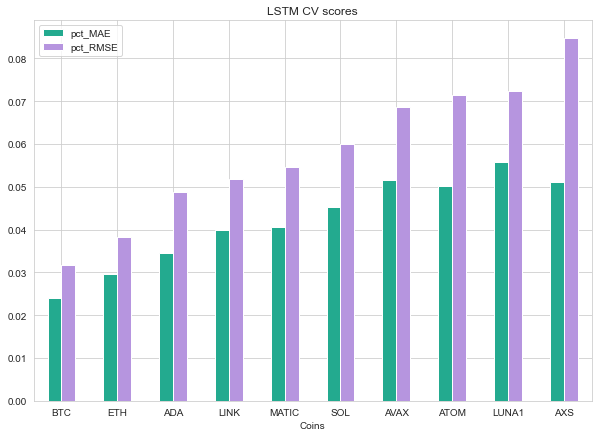

In [242]:
assess_nn_lstm.set_index('ticker').iloc[:,2:].sort_values('pct_RMSE').plot.bar(figsize=(10,7),color = [color4,color5])
plt.xlabel('Coins')
plt.title('LSTM CV scores')
plt.xticks(rotation=0)

In [243]:
lstm_classif = assess_classification_2_1(pred_NN_LSTM.copy(),'Prediction_pct')

ADA
F1 Score: 0.4632768361581921
Precision: 0.45054945054945056
Recall: 0.47674418604651164
ATOM
F1 Score: 0.6160337552742616
Precision: 0.5
Recall: 0.8021978021978022
AVAX
F1 Score: 0.6566037735849057
Precision: 0.5178571428571429
Recall: 0.8969072164948454
AXS
F1 Score: 0.5972850678733032
Precision: 0.4714285714285714
Recall: 0.8148148148148148
BTC
F1 Score: 0.527363184079602
Precision: 0.4953271028037383
Recall: 0.5638297872340425
ETH
F1 Score: 0.6046511627906976
Precision: 0.5508474576271186
Recall: 0.6701030927835051
LINK
F1 Score: 0.4639175257731959
Precision: 0.42857142857142855
Recall: 0.5056179775280899
LUNA1
F1 Score: 0.6715328467153285
Precision: 0.5139664804469274
Recall: 0.968421052631579
MATIC
F1 Score: 0.5714285714285714
Precision: 0.47058823529411764
Recall: 0.7272727272727273
SOL
F1 Score: 0.587719298245614
Precision: 0.48201438848920863
Recall: 0.7528089887640449


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ETH'),
  Text(1, 0, 'AVAX'),
  Text(2, 0, 'LUNA1'),
  Text(3, 0, 'ATOM'),
  Text(4, 0, 'BTC'),
  Text(5, 0, 'SOL'),
  Text(6, 0, 'AXS'),
  Text(7, 0, 'MATIC'),
  Text(8, 0, 'ADA'),
  Text(9, 0, 'LINK')])

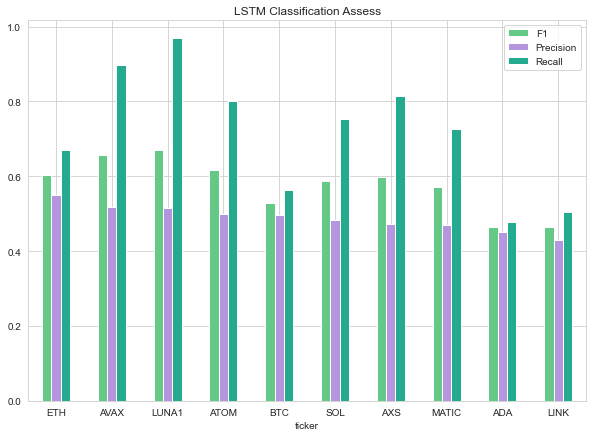

In [244]:
lstm_classif.set_index('ticker').sort_values('Precision',ascending=False).plot.bar(figsize=(10,7),color = [color3,color5,color4])
plt.title('LSTM Classification Assess')
plt.xticks(rotation=0)

Text(0, 0.5, 'Avg % error per day')

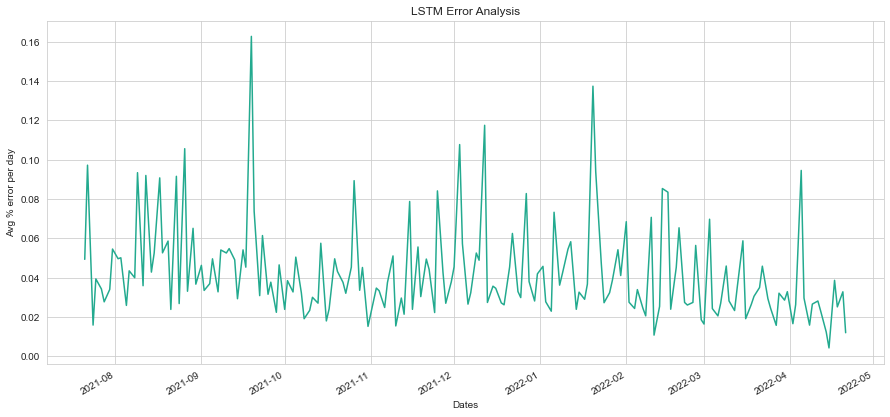

In [246]:
error_lstm = pd.DataFrame()
for i in pred_NN_LSTM.keys():
    error_lstm = pd.concat([error_lstm, pred_NN_LSTM[f'{i}']],axis=0)
    
    
error_analysis = pd.DataFrame()
error_lstm['Error'] = abs(error_lstm['Prediction_pct']- error_lstm['Target_pct'])
error_analysis['Dates'] = error_lstm['date'].unique()
#error_analysis['Year_Mon'] = str(error_analysis['Dates'].dt.year) + '_' + str(error_analysis['Dates'].dt.month)
error_analysis['RMSE'] = error_lstm.groupby('date')['Error'].mean().values
error_analysis = error_analysis.set_index('Dates')
ax = error_analysis['RMSE'].plot(figsize = (15,7),color = color4)
plt.title('LSTM Error Analysis')
plt.ylabel('Avg % error per day')
# y0,y1 = ax.get_ylim()
# offset = teste_model['scores']['RMSE_test'].max()
# new_max = (offset - y0) / (y1 - y0)




### Assess all models

In [582]:
# assess_nn.to_csv(f'GRU_Assess.csv')
# assess_nn_lstm.to_csv(f'LSTM_Assess.csv')

In [223]:
assess_nn = pd.read_csv(f'GRU_Assess.csv')
assess_nn_lstm = pd.read_csv(f'LSTM_Assess.csv')

In [225]:
df_assess = pd.DataFrame()
for i in [assess_nn_lstm,rf_assess_,lr_assess_,assess_nn,lgb_assess_,mlp_assess_]:
    df_assess = pd.concat([df_assess,i],axis=0)
    
# df_assess.iloc[:,1:].set_index(['ticker','Model']).to_csv('full_assess.csv')

In [325]:
rmse_assess = df_assess.round(3).set_index(['ticker','Model'])[['pct_RMSE']].unstack().droplevel(axis=1, level = 0).drop(columns = 'MLP')
#rmse_assess = rmse_assess.columns.droplevel(0)

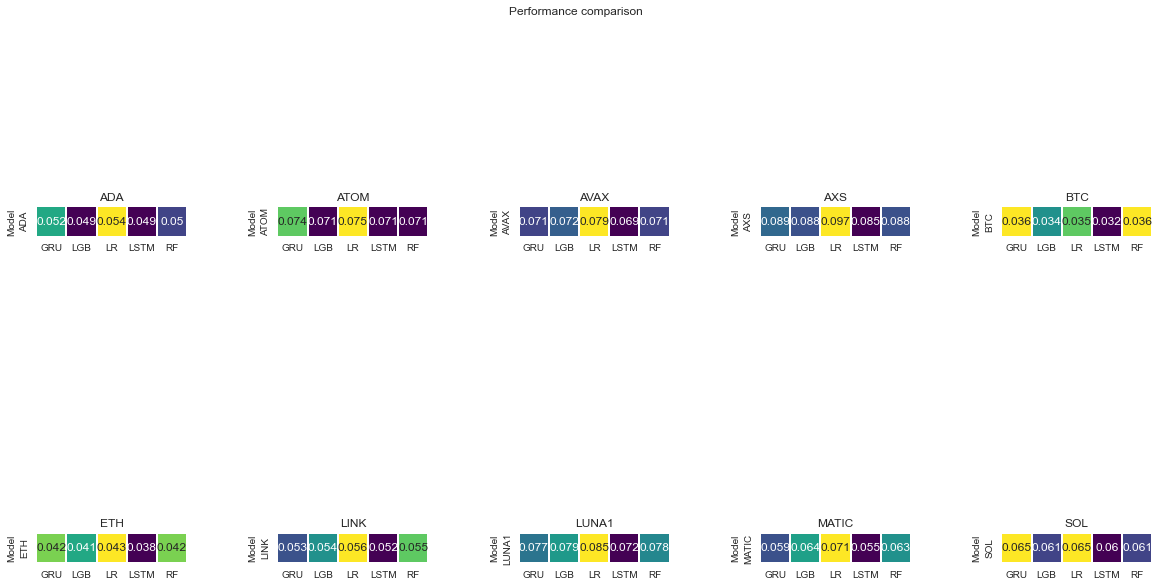

In [326]:
fig, axes = plt.subplots(2, ceil(len(tickers) / 2), figsize=(20, 11))

    
for ax, feat in zip(axes.flatten(), tickers): 

    sns.heatmap(rmse_assess.loc[rmse_assess.index.isin([feat])], linewidths = 0.1,annot = True, \
                annot_kws = {"size": 12}, square = True,cbar=False,cmap = 'viridis',ax=ax )
    ax.set_title(feat)
    ax.set_xlabel('')
    ax.set_ylabel('Model')

title = "Performance comparison"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.6)

In [327]:
rmse_assess_price = df_assess.round(5).set_index(['ticker','Model'])[['RMSE']].unstack().droplevel(axis=1, level = 0).drop(columns = 'MLP')

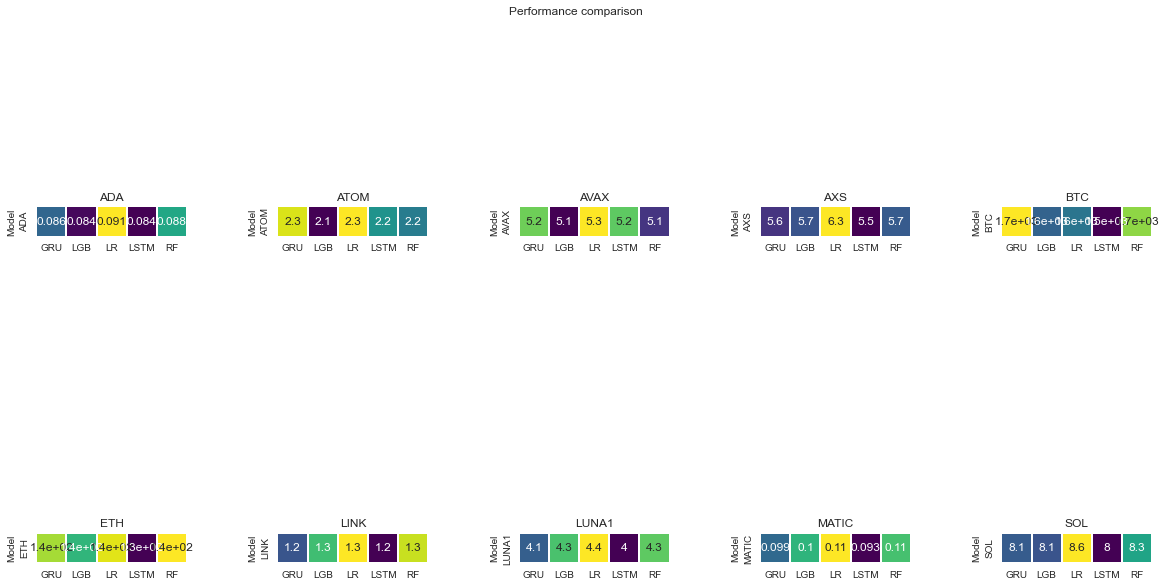

In [328]:
fig, axes = plt.subplots(2, ceil(len(tickers) / 2), figsize=(20, 11))

    
for ax, feat in zip(axes.flatten(), tickers): 

    sns.heatmap(rmse_assess_price.loc[rmse_assess_price.index.isin([feat])], linewidths = 0.1,annot = True, \
                annot_kws = {"size": 12}, square = True,cbar=False,cmap = 'viridis',ax=ax )
    ax.set_title(feat)
    ax.set_xlabel('')
    ax.set_ylabel('Model')

title = "Performance comparison"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.6)

### Generate Predictions

The functions below generates a training and a test set with feature engineering inplace, where the test set represents the days that we want to predict. Then predictions for the next day and the day after that are generated and returned in a dictionary where each key represents a coin.

In [257]:
def gen_x_y_day (data,day):
    tomorrow_p = data.groupby('ticker')['close'].shift(-day)
    today_p = data['close']
    data['target'] = (tomorrow_p - today_p) / (today_p)
    x = data.drop(columns = 'target')
    y = data['target']
    y = y.dropna()
    x = x.loc[x.index.isin(y.index)]
    y_true = data.groupby('ticker')['close'].shift(-day)
    y_true = y_true.loc[y_true.index.isin(y.index)]
    return(x,y)

def gen_data(data, days,day):
    data = ft_engineer(data.copy()).dropna()
    
    date_indexes = data.index.get_level_values(1).unique().sort_values()
    len_ = len(date_indexes)
    

    train_indexes = date_indexes[:-(days+1)]
    test_indexes = date_indexes[-(days+1):]
    x_train ,y_train = gen_x_y_day(data.loc[data.index.get_level_values(1).isin(train_indexes)],day)
    x_test ,y_test = gen_x_y_day(data.loc[data.index.get_level_values(1).isin(test_indexes)],day)
    return(x_train,y_train,x_test,y_test)  


def make_predictions (x_train,y_train,x_test,y_test):
    pct_final_subset = ['ATR_2', 'RSI_2', 'ATR_20','Avg_Price_Disparity','AROON_down_2', 'AROON_up_2','ROC_2'
                   ,'OBV','RSI_7','ROC_20']
    predictions_ = {}
    models = {}
    
    for i in tickers:
        x_tr = x_train.loc[x_train.index.get_level_values(0)==i]
        y_tr = y_train.loc[y_train.index.get_level_values(0)==i]
        x_t = x_test.loc[x_test.index.get_level_values(0)==i]
        y_t = y_test.loc[y_test.index.get_level_values(0)==i]
        model, full_assess,model_dict,history_dict,pred = gen_LSTM(x_tr,y_tr,x_t,y_t,pct_final_subset,'ticker',5,1,32,optimizer='RMSprop',activation='relu',lr=0.1)
        close = x_t['close'].iloc[1:]
        predictions_[f'{i}'] = (pred * close) + close
        models[f'{i}'] = model
        
    return(predictions_, models)

#### Get predictions for the next day

In [279]:
x_train_1,y_train_1,x_test_1,y_test_1 = gen_data(data,3,1)
x_train_1 = pd.concat([x_train_1,x_test_1],axis=0)
y_train_1 = pd.concat([y_train_1,y_test_1],axis=0)
predict_day_1,day_1_models = make_predictions(x_train_1,y_train_1,x_test_1,y_test_1)



 
Feature creation lasted:, 3.710188627243042 seconds
ADA
(1619, 1, 10)
Epoch 1/5
1619/1619 [==============================] - 6s 3ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0457 - val_loss: 4.4311e-04 - val_mean_squared_error: 4.4311e-04 - val_mean_absolute_error: 0.0209
Epoch 2/5
1619/1619 [==============================] - 5s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0450 - val_loss: 4.7825e-04 - val_mean_squared_error: 4.7825e-04 - val_mean_absolute_error: 0.0216
Epoch 3/5
1619/1619 [==============================] - 4s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0451 - val_loss: 4.4449e-04 - val_mean_squared_error: 4.4449e-04 - val_mean_absolute_error: 0.0209
Epoch 4/5
1619/1619 [==============================] - 4s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0449 - val_loss: 5.4399e-04 - val_mean_squared_error: 5.4399e-04 - val_mean_absolute_er

In [280]:
pct_final_subset = ['ATR_2', 'RSI_2', 'ATR_20','Avg_Price_Disparity','AROON_down_2', 'AROON_up_2','ROC_2'
                   ,'OBV','RSI_7','ROC_20']

predictions_1 = pd.DataFrame()
pred_1 = {}
ticker = []
date = []
pred = []
pct_pred = []
for i in tickers:
    scaler = MinMaxScaler()
    scaler.fit(x_train_1.loc[x_train_1.index.get_level_values(0)==i,pct_final_subset].copy())
    x_pred = df_engineer.loc[(df_engineer.index.get_level_values(1)>='2022-05-07') &(df_engineer.index.get_level_values(0)==i),:].copy()
    y = x_pred['close']
    x_pred = scaler.transform(x_pred[pct_final_subset])
    x_pred,y_pred = create_dataset(x_pred,np.array(y),1)
    pred_pct = day_1_models[f'{i}'].predict(x_pred)[0]
    pct_pred.append(pred_pct[0])
    date.append(pd.to_datetime(y.index.get_level_values(1)[1] + datetime.timedelta(days=1)))
    ticker.append(i)
    pred.append(((y[1] * pred_pct) + y[1])[0])
    
    pred_1[f'{i}'] = (y[1] * pred_pct) + y[1]
    
predictions_1['date'] = date
predictions_1['ticker'] = ticker
predictions_1['Predictions'] = pred
predictions_1['Predictions_pct'] = pct_pred

In [281]:
predictions_1

,date,ticker,Predictions,Predictions_pct
0,2022-05-09,ADA,0.745904,0.002071
1,2022-05-09,ATOM,15.650371,-0.008565
2,2022-05-09,AVAX,51.355385,-0.007246
3,2022-05-09,AXS,30.692999,0.009440
4,2022-05-09,BTC,33973.171875,-0.007410
5,2022-05-09,ETH,2509.109619,-0.009151
6,2022-05-09,LINK,9.967952,-0.007602
7,2022-05-09,LUNA1,65.207932,0.016069
8,2022-05-09,MATIC,0.986460,0.006813
9,2022-05-09,SOL,75.538849,0.000031


#### Get Predictions for 2 days ahead

In [282]:
x_train_1,y_train_1,x_test_1,y_test_1 = gen_data(data,4,2)
x_train_1 = pd.concat([x_train_1,x_test_1],axis=0)
y_train_1 = pd.concat([y_train_1,y_test_1],axis=0)
pred_day_2 ,day_2_models= make_predictions(x_train_1,y_train_1,x_test_1,y_test_1)

 
Feature creation lasted:, 3.536893367767334 seconds
ADA
(1617, 1, 10)
Epoch 1/5
1617/1617 [==============================] - 8s 4ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0638 - val_loss: 4.9208e-04 - val_mean_squared_error: 4.9208e-04 - val_mean_absolute_error: 0.0216
Epoch 2/5
1617/1617 [==============================] - 4s 3ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0637 - val_loss: 6.1536e-04 - val_mean_squared_error: 6.1536e-04 - val_mean_absolute_error: 0.0241
Epoch 3/5
1617/1617 [==============================] - 4s 3ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0633 - val_loss: 5.2343e-04 - val_mean_squared_error: 5.2343e-04 - val_mean_absolute_error: 0.0220
Epoch 4/5
1617/1617 [==============================] - 4s 3ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0634 - val_loss: 6.0498e-04 - val_mean_squared_error: 6.0498e-04 - val_mean_absolute_er

In [141]:
pct_final_subset = ['ATR_2', 'RSI_2', 'ATR_20','Avg_Price_Disparity','AROON_down_2', 'AROON_up_2','ROC_2'
                   ,'OBV','RSI_7','ROC_20']

predictions_2 = pd.DataFrame()
pred_2 = {}
ticker = []
date = []
pred = []
pct_pred = []
for i in tickers:
    scaler = MinMaxScaler()
    scaler.fit(x_train_1.loc[x_train_1.index.get_level_values(0)==i,pct_final_subset].copy())
    x_pred = df_engineer.loc[(df_engineer.index.get_level_values(1)>='2022-05-07') &(df_engineer.index.get_level_values(0)==i),:].copy()
    y = x_pred['close']
    x_pred = scaler.transform(x_pred[pct_final_subset])
    x_pred,y_pred = create_dataset(x_pred,np.array(y),1)
    pred_pct = day_2_models[f'{i}'].predict(x_pred)[0]
    pct_pred.append(pred_pct[0])
    date.append(pd.to_datetime(y.index.get_level_values(1)[1] + datetime.timedelta(days=2)))
    ticker.append(i)
    pred.append(((y[1] * pred_pct) + y[1])[0])
    
    pred_2[f'{i}'] = (y[1] * pred_pct) + y[1]
    
predictions_2['date'] = date
predictions_2['ticker'] = ticker
predictions_2['Predictions'] = pred
predictions_2['Predictions_pct'] = pct_pred

In [81]:
final_predictions = pd.concat([predictions_1,predictions_2],axis=0).sort_values('ticker')

In [84]:
final_predictions.to_csv('Final_predictions_GroupE.csv')